In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


# Update train data

In [2]:
# Update train data
home_dir_novozymes = '/kaggle/input/novozymes-enzyme-stability-prediction'

train = pd.read_csv(f"{home_dir_novozymes}/train.csv", index_col="seq_id")
train_updates = pd.read_csv(f"{home_dir_novozymes}/train_updates_20220929.csv", index_col="seq_id")

all_features_nan = train_updates.isnull().all("columns")

drop_indices = train_updates[all_features_nan].index
train = train.drop(index=drop_indices)

swap_ph_tm_indices = train_updates[~all_features_nan].index
train.loc[swap_ph_tm_indices, ["pH", "tm"]] = train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

# Find wildtype candidates for each length of protein string

In [3]:
from statistics import mode, StatisticsError
from collections import defaultdict
from operator import itemgetter

In [4]:
train['x'] = train.protein_sequence.str.len()
vc = train.x.value_counts()
vc.head()

164    748
231    318
455    245
155    243
148    241
Name: x, dtype: int64

In [5]:
# INSERTION DELETION THRESHOLD
D_THRESHOLD = 1
# MIN GROUP SIZE
MIN_GROUP_SIZE = 5

def max_item_count(seq):
    d = defaultdict(int)
    for item in seq:
        d[item] += 1
    return max(d.items(), key=itemgetter(1))

def get_wildtype(proteins, is_retry=False):
    if not is_retry:
        ## try to get the mode, the simpler algorithm
        wildtype = []
        try:
            for i in range(len(proteins.iloc[0])):
                wildtype.append(mode([p[i] for p in proteins]))
            return ''.join(wildtype)
        except StatisticsError:
            pass
    ## Either failed mode above, or this is a retry because the resulting wildtype didn't actually fit enough proteins
    ##
    ## Two sequences with single mutation from the same wildtype are no more than 2 points different.
    ## Therefore, at least 1/3rd length consecutive string must match. Find max counts of starts, middles, and ends
    ## This technically isn't a guaranteed or precise algorithm, but it is fast and effective,
    ##   based on comparison with more precise grouping methods.
    k = len(proteins.iloc[0])//3
    starts = [p[:k] for p in proteins]
    middles = [p[k:2*k] for p in proteins]
    ends = [p[-k:] for p in proteins]
    ## get the most common substring, and the count of that substring
    start = max_item_count(starts)
    middle = max_item_count(middles)
    end = max_item_count(ends)
    ## reduce the proteins to the ones that match the most common substring
    if (start[1] >= middle[1]) and (start[1] >= end[1]) and (start[1] >= MIN_GROUP_SIZE):
        proteins = [p for p in proteins if p[:k] == start[0]]
        assert(start[1] == len(proteins))
    elif (middle[1] >= end[1]) and (middle[1] >= MIN_GROUP_SIZE):
        proteins = [p for p in proteins if p[k:2*k] == middle[0]]
        assert(middle[1] == len(proteins))
    elif end[1] >= MIN_GROUP_SIZE:
        proteins = [p for p in proteins if p[-k:] == end[0]]
        assert(end[1] == len(proteins))
    else:
        return ''
    ## use the reduced list to find the entire wildtype
    wildtype = []
    try:
        for i in range(len(proteins[0])):
            wildtype.append(mode([p[i] for p in proteins]))
        return ''.join(wildtype)
    except StatisticsError:
        return ""

In [6]:
train['group'] = -1
train['wildtype'] = ''
grp = 0

for k in range(len(vc)):
    if vc.iloc[k] < MIN_GROUP_SIZE:
        break
    c = vc.index[k]
    print(f'rows={vc.iloc[k]}, k:{k}, protein length:{c}')
    is_retry = False
    # SUBSET OF TRAIN DATA WITH SAME PROTEIN LENGTH (not enough deletions to matter for step 1, finding the wildtype)
    tmp = train.loc[(train.x==c)&(train.group==-1)]

    ## It is possible that the same length protein string might have multiple wildtypes in the raw data, keep searching until we've found all of them
    while len(tmp) >= MIN_GROUP_SIZE:
        if len(tmp)<=1: break
        # Ignore Levenstein distance, which is overkill
        # Directly attempt to find wildtype
        # Drop duplicates for wildtype guesstimation
        proteins = tmp.protein_sequence.drop_duplicates()

        # Create most likely wildtype
        wildtype = get_wildtype(proteins, is_retry=is_retry)
        if wildtype == '':
            break

        # SUBSET OF TRAIN DATA WITH SAME PROTEIN LENGTH PLUS MINUS D_THRESHOLD
        tmp = train.loc[(train.x>=c-D_THRESHOLD)&(train.x<=c+D_THRESHOLD)&(train.group==-1)]
        for idx in tmp.index:
            p = train.loc[idx, 'protein_sequence']
            half = c//2
            ## Use fast method to guess that it is only a single point mutation away. Later we double check and actually count number of mutations.
            if (wildtype[:half] == p[:half]) or (wildtype[-half:] == p[-half:]):
                train.loc[idx,'group'] = grp
                train.loc[idx,'wildtype'] = wildtype
        if len(train.loc[train.group==grp]) >= MIN_GROUP_SIZE:
            print(f"{train.loc[(train.group==grp)].shape[0]}: Group {grp} results")
            grp += 1
            is_retry = False
        else:
            train.loc[idx,'group'] = -1
            train.loc[idx,'wildtype'] = ''
            ## to avoid an infinite loop, break out if we've already failed last time
            if is_retry:
                break
            is_retry = True

        # Get ready for next loop
        tmp = train.loc[(train.x==c)&(train.group==-1)]

rows=748, k:0, protein length:164
708: Group 0 results
rows=318, k:1, protein length:231
273: Group 1 results
rows=245, k:2, protein length:455
211: Group 2 results
rows=243, k:3, protein length:155
180: Group 3 results
34: Group 4 results
rows=241, k:4, protein length:148
194: Group 5 results
rows=233, k:5, protein length:448
130: Group 6 results
61: Group 7 results
rows=193, k:6, protein length:246
151: Group 8 results
rows=165, k:7, protein length:170
144: Group 9 results
rows=164, k:8, protein length:150
124: Group 10 results
rows=145, k:9, protein length:96
127: Group 11 results
rows=125, k:10, protein length:142
78: Group 12 results
rows=123, k:11, protein length:101
78: Group 13 results
32: Group 14 results
rows=116, k:12, protein length:109
78: Group 15 results
rows=115, k:13, protein length:485
84: Group 16 results
rows=99, k:14, protein length:268
53: Group 17 results
rows=99, k:15, protein length:537
72: Group 18 results
rows=99, k:16, protein length:144
68: Group 19 results

In [7]:
print(grp)

79


In [8]:
train.head()

protein_sequence   pH  \
seq_id                                                           
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   

                              data_source    tm     x  group wildtype  
seq_id                                                                 
0       doi.org/10.1038/s41592-020-0801-4  75.7   341     -1           
1       doi.org/10.1038/s41592-020-0801-4  50.5   286     -1           
2       doi.org/10.1038/s41592-020-0801-4  40.5   497     -1           
3       doi.org/10.1038/s41592-020-0801-4  47.2   265     -1           
4       doi.org/10.1038/s41592-020-0801-4  49.5  1451     -1

# Display Groups

In [9]:
def argsort(seq, reverse=False):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__, reverse=reverse)

groups = [0] * grp
for k in range(grp):
    groups[k] = len(train.loc[train.group==k])

groupCount = 0
rowCount = 0
for k in argsort(groups, reverse=True):
    if train.loc[train.group==k].shape[0] == 0:
        continue
    proteins = train.loc[train.group==k, "protein_sequence"]
    wildtype = train.loc[train.group==k, "wildtype"].values[0]

    ## no insertions in the dataset, that I've found.
    ## Handle deletions by adding a '-' symbol in the correct place
    for i in range(len(proteins)):
        if len(proteins.iloc[i]) < len(proteins.iloc[0]):
            if proteins.iloc[i] == wildtype[:-1]:
                proteins.iloc[i] = proteins.iloc[i] + "-"
            else:
                for j in range(len(proteins.iloc[i])):
                    if proteins.iloc[i][j] != wildtype[j]:
                        proteins.iloc[i] = proteins.iloc[i][:j-1] + "-" + proteins.iloc[i][j:]
                        break
        assert(len(proteins.iloc[i]) == len(proteins.iloc[0]))

    ## In very rare cases, the simplified logic to group proteins will group a protein that is NOT a single mutation away from the wildtype.
    ## Ungroup those proteins.
    ungroup = []
    for p in proteins:
        mut = 0
        for j in range(len(wildtype)):
            if p[j] != wildtype[j]:
                mut += 1
        if mut > 1:
            if p not in ungroup:
                ungroup.append(p)
    for p in ungroup:
        train.loc[train.protein_sequence==p, 'group'] = -1
        train.loc[train.protein_sequence==p, 'wildtype'] = ''
    ## Remove entire group if it is now smaller than the min group size
    if train.loc[train.group==k].shape[0] < MIN_GROUP_SIZE:
        train.loc[train.group==k, 'wildtype'] = ''
        train.loc[train.group==k, 'group'] = -1
        continue

    ## Print a line for every group, and a bunch of stats for the first few groups
    print(f'{k}: {train.loc[train.group==k].shape[0]}')
    if groupCount < 5:
        display( train.loc[train.group==k] )
        for c in train.columns:
            print(c, train.loc[train.group==k, c].nunique() + train.loc[train.group==k, c].isnull().values.any())
        print(wildtype)
        print("")
    groupCount += 1
    rowCount += train.loc[train.group==k].shape[0]

print(groupCount, rowCount)

0: 708


protein_sequence   pH  \
seq_id                                                           
18020   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
18021   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  4.2   
18022   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
18023   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
18060   MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
...                                                   ...  ...   
19949   MNWFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
19950   MNWFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
19964   MNYFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
19965   MNYFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
19966   MNYFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  4.2   

                data_source    tm    x  group  \
seq_id                                          
18020   10.1021/bi00535a054  38.1  164      0   
18021                   NaN  53.3  164      0   
18022      10.1038/334406a0  38.1  164      0   
18023      10.1038/334406a0  62.9  164      0   
18060                   NaN  41.9  164      0   
...                     ...   ...  ...    ...   
19949      10.1038/334406a0  56.7  164      0   
19950      10.1038/334406a0  25.5  164      0   
19964      10.1038/334406a0  32.4  164      0   
19965      10.1038/334406a0  58.8  164      0   
19966                   NaN  53.3  164      0   

                                                 wildtype  
seq_id                                                     
18020   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
18021   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
18022   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
18023   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
18060   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
...                                                   ...  
19949   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
19950   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
19964   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
19965   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
19966   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  

[708 rows x 7 columns]

protein_sequence 292
pH 54
data_source 59
tm 295
x 1
group 1
wildtype 1
MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNCNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRCALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSIWYNQTPNRAKRVITTFRTGTWDAYKNL

1: 273


protein_sequence    pH  \
seq_id                                                            
16542   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  7.00   
16544   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  5.40   
16554   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  7.00   
16555   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  7.00   
16559   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  7.00   
...                                                   ...   ...   
17299   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  7.00   
17304   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  5.42   
17306   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  5.40   
17314   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  7.00   
17316   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  7.00   

                      data_source    tm    x  group  \
seq_id                                                
16542         10.1021/bi00006a025  50.9  231      1   
16544                         NaN  40.0  231      1   
16554   10.1016/j.bpc.2006.10.014  50.1  231      1   
16555   10.1016/j.bpc.2006.10.014  48.9  231      1   
16559   10.1016/j.bpc.2006.10.014  51.1  231      1   
...                           ...   ...  ...    ...   
17299   10.1016/j.bpc.2006.10.014  48.5  231      1   
17304         10.1021/bi00471a003  45.7  231      1   
17306                         NaN  40.0  231      1   
17314   10.1016/j.bpc.2006.10.014  52.4  231      1   
17316   10.1016/j.bpc.2006.10.014  51.1  231      1   

                                                 wildtype  
seq_id                                                     
16542   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
16544   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
16554   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
16555   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
16559   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
...                                                   ...  
17299   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
17304   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
17306   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
17314   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  
17316   MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...  

[273 rows x 7 columns]

protein_sequence 143
pH 17
data_source 17
tm 153
x 1
group 1
wildtype 1
MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSCLVLTLVVVSSLSSSANASQTDNGVNRSGSEDPTVYSATSTKKLHKEPATLIKAIDGDTVKLMYKGQPMTFRLLLVDTPETKHPKKGVEKYGPEASAFTKKMVENAKKIEVEFDKGQRTDKYGRGLAYIYADGKMVNEALVRQGLAKVAYVYKPNNTHEQHLRKSEAQAKKEKLNIWSEDNADSGQ

2: 211


protein_sequence   pH  \
seq_id                                                           
19480   MNQSVKSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  8.0   
19481   MNQSVSSLAEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  8.0   
19482   MNQSVSSLKEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  8.0   
19483   MNQSVSSLPEKDIQYQLHPYTDARLHQELGPLIIERGEGIYVYDDQ...  8.0   
19484   MNQSVSSLPEKDIQYQLHPYTEARLHQELGPLIIERGEGIYVYDDQ...  8.0   
...                                                   ...  ...   
19686   MNQSVSSLPEKDIQYQLHPYTNARLHQKLGPLIIERGEGIYVYDDQ...  8.0   
19687   MNQSVSSLPEKDIQYQLHPYTNARLMQELGPLIIERGEGIYVYDDQ...  8.0   
19688   MNQSVSSLPEKDIQYQLHPYTNLRLHQELGPLIIERGEGIYVYDDQ...  8.0   
19689   MNQSVSSLPEKDKQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  8.0   
19690   MNQSVSSLREKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  8.0   

                     data_source    tm    x  group  \
seq_id                                               
19480   10.1021/acscatal.9b05223  62.5  455      2   
19481   10.1021/acscatal.9b05223  64.0  455      2   
19482   10.1021/acscatal.9b05223  63.5  455      2   
19483   10.1021/acscatal.9b05223  62.0  455      2   
19484   10.1021/acscatal.9b05223  61.5  455      2   
...                          ...   ...  ...    ...   
19686   10.1021/acscatal.9b05223  62.5  455      2   
19687   10.1021/acscatal.9b05223  62.0  455      2   
19688   10.1021/acscatal.9b05223  62.0  455      2   
19689   10.1021/acscatal.9b05223  62.0  455      2   
19690   10.1021/acscatal.9b05223  62.5  455      2   

                                                 wildtype  
seq_id                                                     
19480   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
19481   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
19482   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
19483   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
19484   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
...                                                   ...  
19686   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
19687   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
19688   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
19689   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  
19690   MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...  

[211 rows x 7 columns]

protein_sequence 211
pH 1
data_source 1
tm 31
x 1
group 1
wildtype 1
MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQGKGYIEAMAGLWSAALGFSNQRLIKAAEQQFNTLPFYHLFSHKSHRPSIELAEKLIEMAPVPMSKVFFTNSGSEANDTVVKMVWYLNNALGKPAKKKFISRVNGYHGITVASASLTGLPGNQRGFDLPLPGFLHVGCPHHYRFALAGESEEHFADRLAVELEQKILAEGPETIAAFIGEPLMGAGGVIVPPRTYWEKIQKVCRKYDILVIADEVICGFGRTGQMFGSQTFGIQPDIMVLSKQLSSSYQPIAAILINAPVFEGIADQSQALGALGHGFTGSGHPVATAVALENLKIIEEESLVEHAAQMGQLLRSGLQHFIDHPLVGEIRGCGLIAAVELVGDRVSKAPYQALGTLGRYMAGRAQEHGMITRAMGDAVAFCPPLIVNEQEVGMIVERFARALDDTTQWVG

5: 194


protein_sequence   pH  \
seq_id                                                           
13269   MKALIVLGLVLLSVTVQGAVFERCELARTLKRLGMDGYRGISLANW...  2.7   
13270   MKALIVLGLVLLSVTVQGKAFERCELARTLKRLGMDGYRGISLANW...  2.7   
13271   MKALIVLGLVLLSVTVQGKAFERCELARTLKRLGMDGYRGISLANW...  2.7   
13273   MKALIVLGLVLLSVTVQGKDFERCELARTLKRLGMDGYRGISLANW...  2.7   
13275   MKALIVLGLVLLSVTVQGKFFERCELARTLKRLGMDGYRGISLANW...  2.7   
...                                                   ...  ...   
13569   MKALIVLGLVLLSVTVQGKVFERCQLARTLKRLGMDGYRGISLANW...  2.2   
13570   MKALIVLGLVLLSVTVQGKVFERCQLARTLKRLGMDGYRGISLANW...  4.0   
13571   MKALIVLGLVLLSVTVQGKVFERCQLARTLKRLGMDGYRGISLANW...  2.3   
13573   MKALIVLGLVLLSVTVQGKYFERCELARTLKRLGMDGYRGISLANW...  2.7   
13574   MKALIVLGLVLLSVTVQGMVFERCELARTLKRLGMDGYRGISLANW...  2.7   

                             data_source    tm    x  group  \
seq_id                                                       
13269   10.1046/j.1432-1327.1999.00918.x  62.7  148      5   
13270                  10.1021/bi9621829  60.3  148      5   
13271             10.1006/jmbi.1998.1906  41.3  148      5   
13273             10.1074/jbc.M110728200  60.4  148      5   
13275                  10.1021/bi0015717  62.2  148      5   
...                                  ...   ...  ...    ...   
13569                  10.1021/bi000849s  57.8  148      5   
13570                  10.1021/bi000849s  76.2  148      5   
13571                  10.1021/bi000849s  54.6  148      5   
13573             10.1074/jbc.M110728200  63.7  148      5   
13574   10.1046/j.1432-1327.1999.00918.x  64.4  148      5   

                                                 wildtype  
seq_id                                                     
13269   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
13270   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
13271   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
13273   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
13275   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
...                                                   ...  
13569   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
13570   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
13571   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
13573   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  
13574   MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...  

[194 rows x 7 columns]

protein_sequence 122
pH 12
data_source 20
tm 110
x 1
group 1
wildtype 1
MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV

3: 180


protein_sequence   pH  \
seq_id                                                           
15685   MLKQVEIFTAGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  3.0   
15686   MLKQVEIFTAGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  9.0   
15687   MLKQVEIFTAGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  5.5   
15688   MLKQVEIFTAGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  5.8   
15690   MLKQVEIFTDGSCLGNPGPGGYAAILRYRGREKTFSAGYTRTTNNR...  4.2   
...                                                   ...  ...   
15875   MLKQVEIFTNGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  9.0   
15876   MLKQVEIFTNGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  3.0   
15878   MLKQVEIFTSGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  9.0   
15879   MLKQVEIFTSGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  3.0   
15880   MLKQVEIFTSGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  6.0   

                     data_source    tm    x  group  \
seq_id                                               
15685   10.1074/jbc.271.51.32729  58.1  155      3   
15686   10.1074/jbc.271.51.32729  60.7  155      3   
15687              10.1038/12277  62.6  155      3   
15688                        NaN  40.7  155      3   
15690                        NaN  51.5  155      3   
...                          ...   ...  ...    ...   
15875   10.1074/jbc.271.51.32729  53.8  155      3   
15876   10.1074/jbc.271.51.32729  47.4  155      3   
15878   10.1074/jbc.271.51.32729  56.2  155      3   
15879   10.1074/jbc.271.51.32729  52.4  155      3   
15880                        NaN  48.5  155      3   

                                                 wildtype  
seq_id                                                     
15685   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
15686   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
15687   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
15688   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
15690   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
...                                                   ...  
15875   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
15876   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
15878   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
15879   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  
15880   MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...  

[180 rows x 7 columns]

protein_sequence 74
pH 11
data_source 11
tm 93
x 2
group 1
wildtype 1
MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNRMELMAAIVALEALKEHCEVILSTDSQYVRQGITQWIHNWKKRGWKTADKKPVKNVDLWQRLDAALGQHQIKWEWVKGHAGHPENERCDELARAAAMNPTLEDTGYQVEV

8: 151
9: 144
6: 130
11: 127
10: 124
16: 84
12: 78
13: 78
15: 78
18: 72
19: 68
30: 62
7: 61
20: 60
29: 59
36: 55
24: 54
25: 54
17: 53
26: 53
48: 52
21: 51
22: 49
53: 45
28: 41
32: 36
4: 34
14: 32
38: 31
54: 30
23: 28
35: 28
60: 27
31: 26
33: 25
47: 24
73: 21
34: 19
44: 19
46: 19
27: 16
51: 17
75: 17
37: 16
45: 16
41: 13
71: 13
72: 13
40: 12
43: 12
58: 12
62: 12
69: 12
68: 11
39: 10
49: 10
52: 10
55: 10
57: 10
59: 10
77: 10
64: 9
61: 8
67: 8
70: 8
76: 8
78: 8
56: 7
42: 6
63: 6
65: 6
74: 6
50: 5
78 4195


In [10]:
# display( train.loc[train.group==0] )
train.head()

protein_sequence   pH  \
seq_id                                                           
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   

                              data_source    tm     x  group wildtype  
seq_id                                                                 
0       doi.org/10.1038/s41592-020-0801-4  75.7   341     -1           
1       doi.org/10.1038/s41592-020-0801-4  50.5   286     -1           
2       doi.org/10.1038/s41592-020-0801-4  40.5   497     -1           
3       doi.org/10.1038/s41592-020-0801-4  47.2   265     -1           
4       doi.org/10.1038/s41592-020-0801-4  49.5  1451     -1

In [11]:
## Re-number groups from largest to smallest
groups = [0] * grp
for k in range(grp):
    groups[k] = len(train.loc[train.group==k])

n = 10000
for k in argsort(groups, reverse=True):
    train.loc[train.group==k, "group"] = n
    n += 1

train.loc[train.group>=10000, "group"] = train.loc[train.group>=10000, "group"] - 10000
train.loc[train.group==-1, "group"] = 1000
train = train.sort_values(axis=0, by=['group'], kind='mergesort')#.reset_index(drop=True)
train.loc[train.group==1000, "group"] = -1

# train = train.drop('x',axis=1)
train_wildtype_groups = train.loc[train.wildtype != '']
train_no_wildtype = train.loc[train.wildtype == '']
print(train_wildtype_groups.shape)
print(train_no_wildtype.shape)

(4195, 7)
(24786, 7)


# Save Groups

In [12]:
train_wildtype_groups.to_csv('train_wildtype_groups.csv',index=False)
# train_wildtype_groups.to_csv('train_wildtype_groups.csv')
train_wildtype_groups.head()

protein_sequence   pH  \
seq_id                                                           
18020   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
18021   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  4.2   
18022   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   
18023   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  6.5   
18060   MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  2.0   

                data_source    tm    x  group  \
seq_id                                          
18020   10.1021/bi00535a054  38.1  164      0   
18021                   NaN  53.3  164      0   
18022      10.1038/334406a0  38.1  164      0   
18023      10.1038/334406a0  62.9  164      0   
18060                   NaN  41.9  164      0   

                                                 wildtype  
seq_id                                                     
18020   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
18021   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
18022   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
18023   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  
18060   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...

In [13]:
train_no_wildtype.to_csv('train_no_wildtype.csv',index=False)
train_no_wildtype.head()

protein_sequence   pH  \
seq_id                                                           
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   

                              data_source    tm     x  group wildtype  
seq_id                                                                 
0       doi.org/10.1038/s41592-020-0801-4  75.7   341     -1           
1       doi.org/10.1038/s41592-020-0801-4  50.5   286     -1           
2       doi.org/10.1038/s41592-020-0801-4  40.5   497     -1           
3       doi.org/10.1038/s41592-020-0801-4  47.2   265     -1           
4       doi.org/10.1038/s41592-020-0801-4  49.5  1451     -1

# !!! Experiment !!!

In [14]:
def get_base_mutations(row):
    for i, (a, b) in enumerate(zip(row.protein_sequence, row.wildtype)):
        if a != b:
            row['base'] = b
            row['mutation'] = a if len(row.protein_sequence) == len(row.wildtype) else '-'
            row['position'] = i + 1
            break
    return row

experiment_df = train_wildtype_groups.copy()
experiment_df = experiment_df.apply(get_base_mutations, axis=1)
experiment_df.head()

base          data_source  group mutation   pH  position  \
seq_id                                                            
18020     I  10.1021/bi00535a054      0        A  2.0       3.0   
18021     I                  NaN      0        A  4.2       3.0   
18022     I     10.1038/334406a0      0        A  2.0       3.0   
18023     I     10.1038/334406a0      0        A  6.5       3.0   
18060     I                  NaN      0        C  2.0       3.0   

                                         protein_sequence    tm  \
seq_id                                                            
18020   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  38.1   
18021   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  53.3   
18022   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  38.1   
18023   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  62.9   
18060   MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  41.9   

                                                 wildtype    x  
seq_id                                                          
18020   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164  
18021   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164  
18022   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164  
18023   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164  
18060   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164

In [15]:
experiment_df.to_csv('train_groups.csv')

In [16]:
deleties = experiment_df.loc[experiment_df.mutation == '-']
deleties.head()

Empty DataFrame
Columns: [base, data_source, group, mutation, pH, position, protein_sequence, tm, wildtype, x]
Index: []

In [27]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


In [64]:
pH_df = experiment_df.loc[(experiment_df.pH >= 6) & (experiment_df.pH <= 9)]
pH_df.head()

base       data_source  group mutation   pH  position  \
seq_id                                                         
18023     I  10.1038/334406a0      0        A  6.5       3.0   
18061     I               NaN      0        C  6.5       3.0   
18062     I               NaN      0        C  6.5       3.0   
18072     I  10.1038/334406a0      0        D  6.5       3.0   
18113     I  10.1038/334406a0      0        E  6.5       3.0   

                                         protein_sequence    tm  \
seq_id                                                            
18023   MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  62.9   
18061   MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  65.0   
18062   MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  64.7   
18072   MNDFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  56.2   
18113   MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  59.0   

                                                 wildtype    x  
seq_id                                                          
18023   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164  
18061   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164  
18062   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164  
18072   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164  
18113   MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...  164

In [73]:
pH_groups = pH_df.group.unique()
print(pH_groups)

[ 0  1  2  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26
 27 28 29 31 32 34 35 36 38 39 40 41 42 43 44 45 47 48 49 50 51 52 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 71 72 73 74 75]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


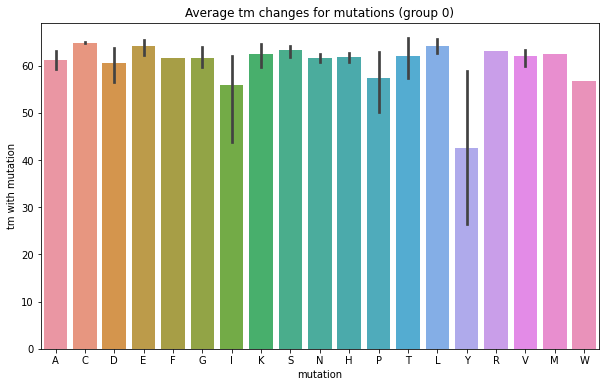

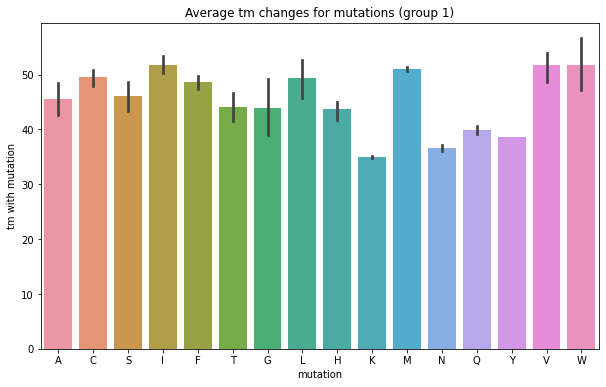

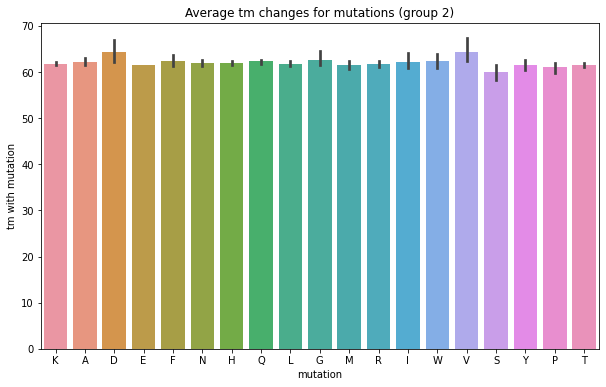

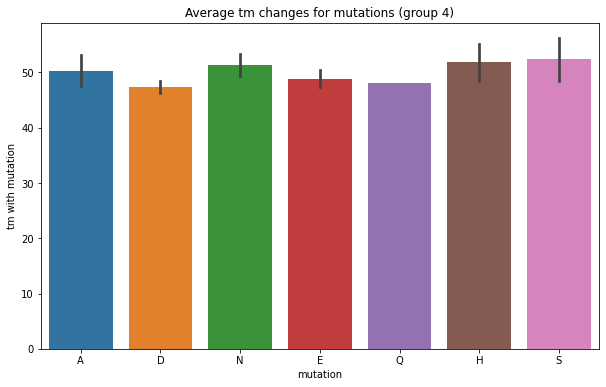

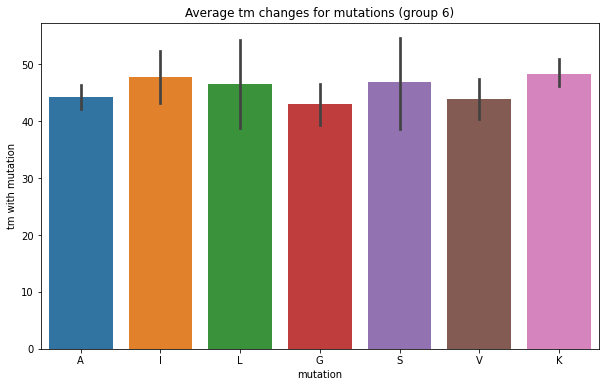

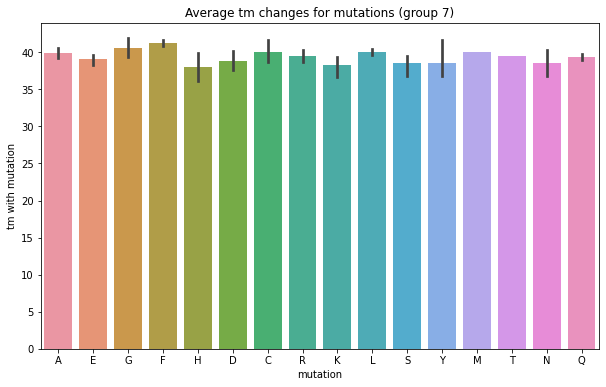

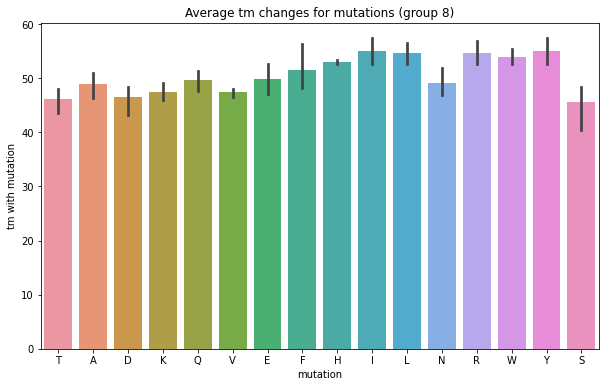

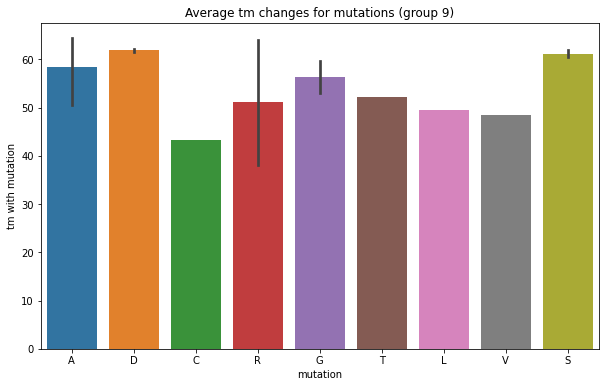

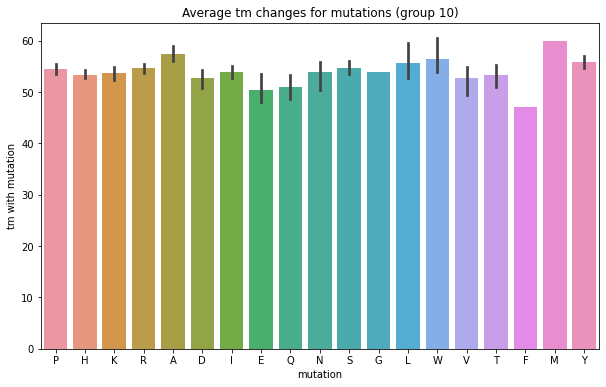

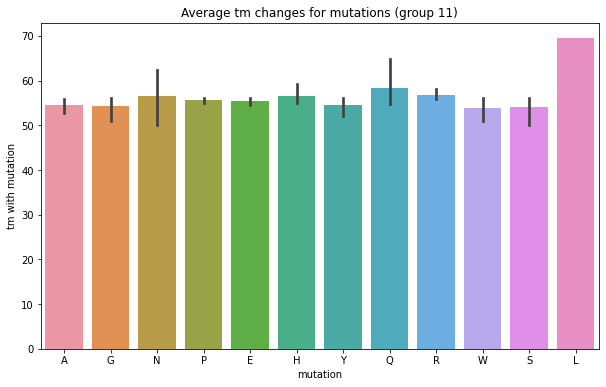

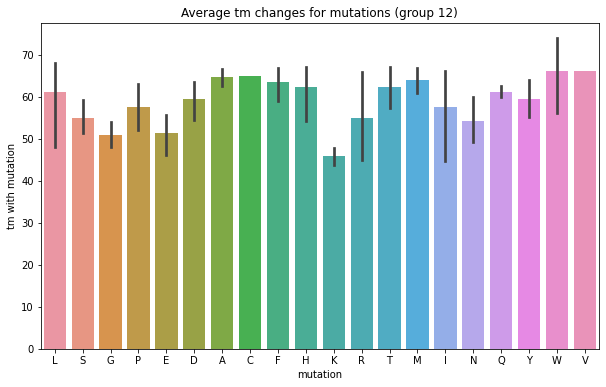

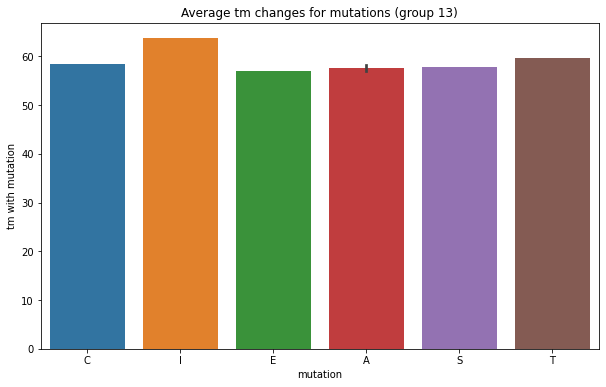

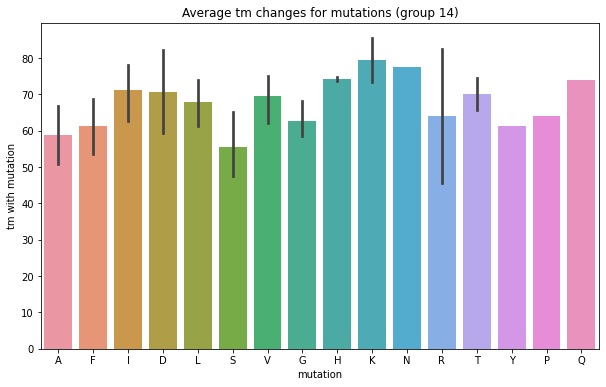

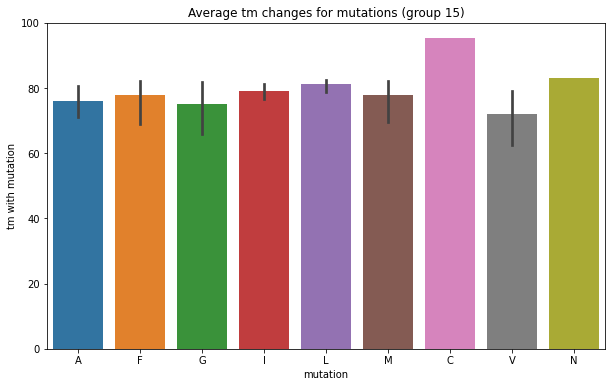

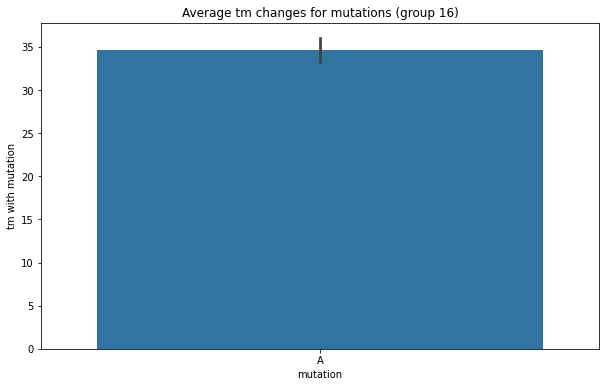

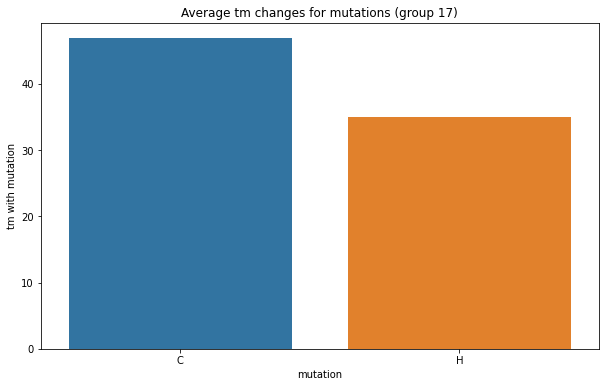

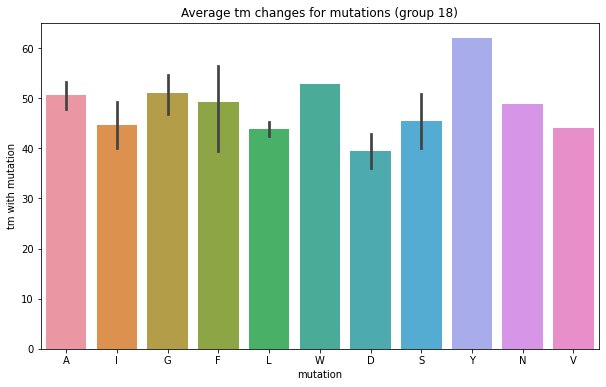

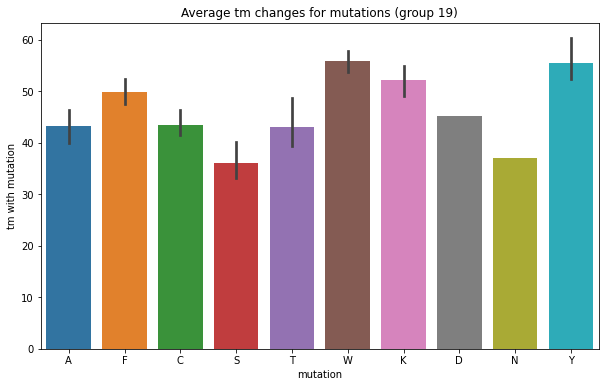

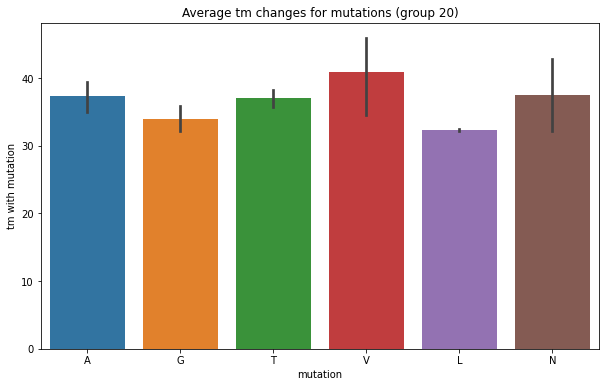

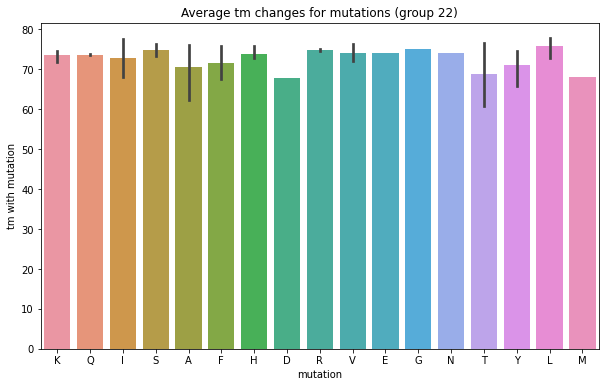

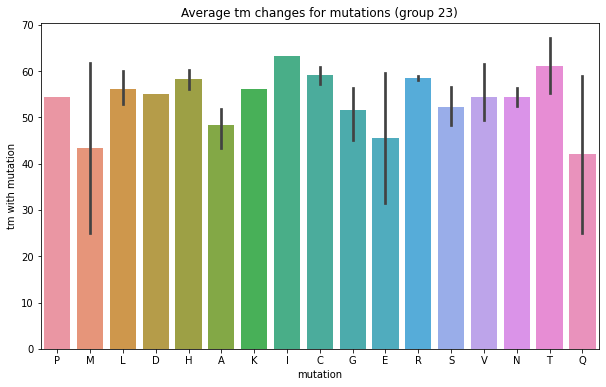

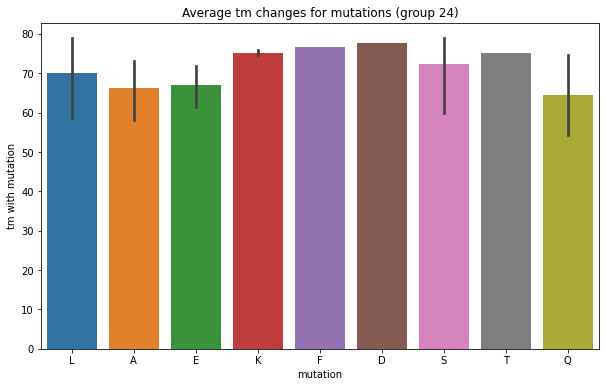

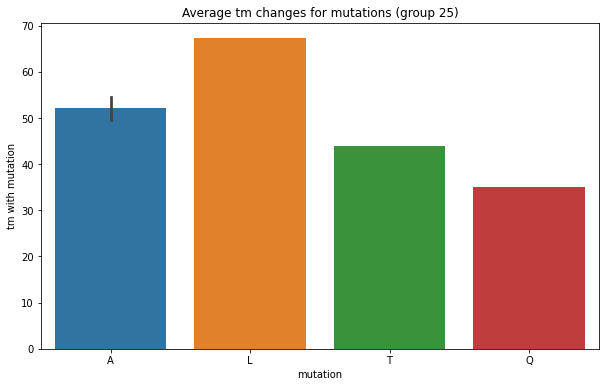

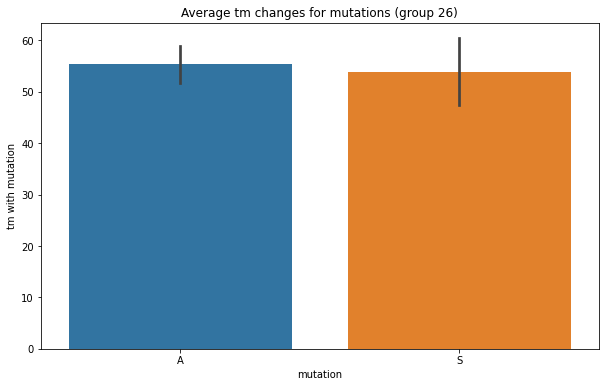

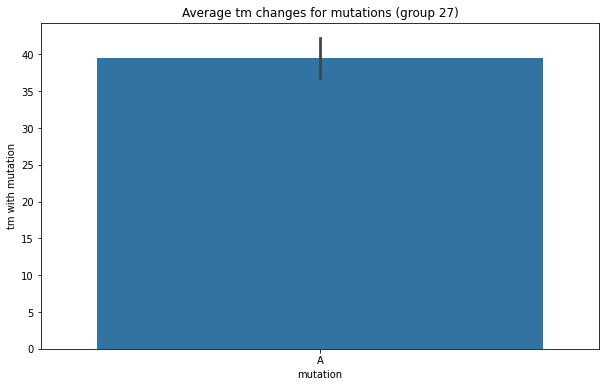

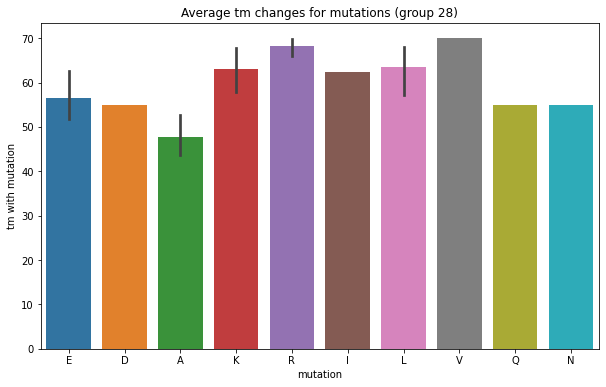

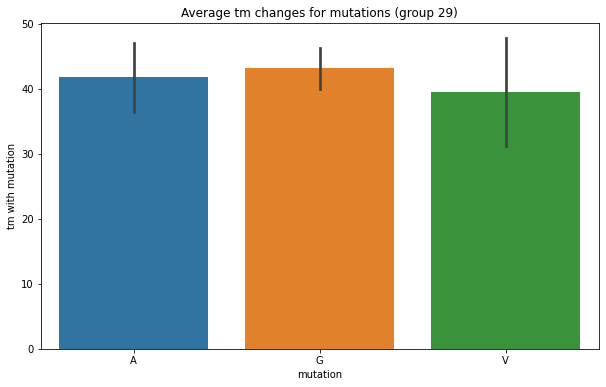

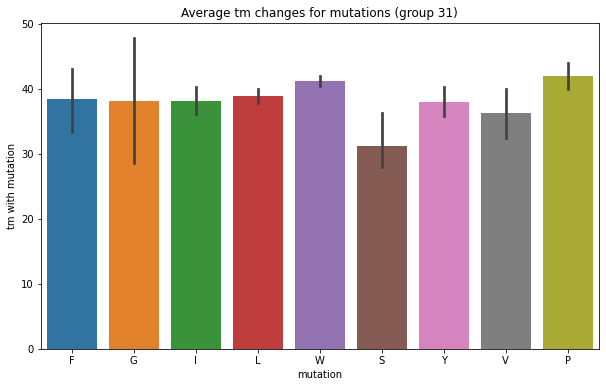

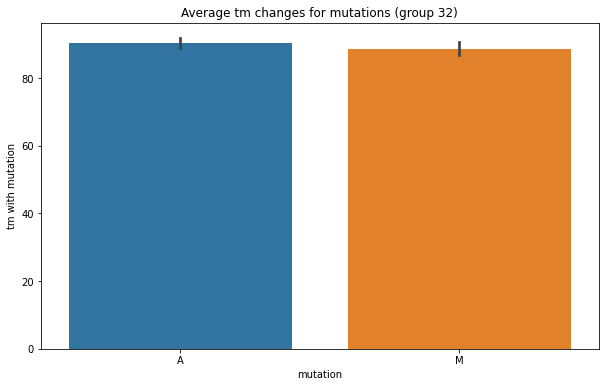

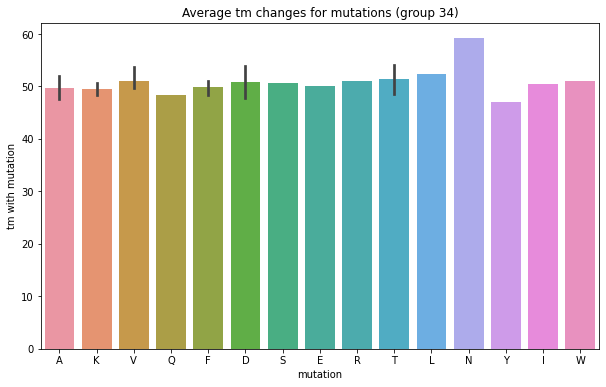

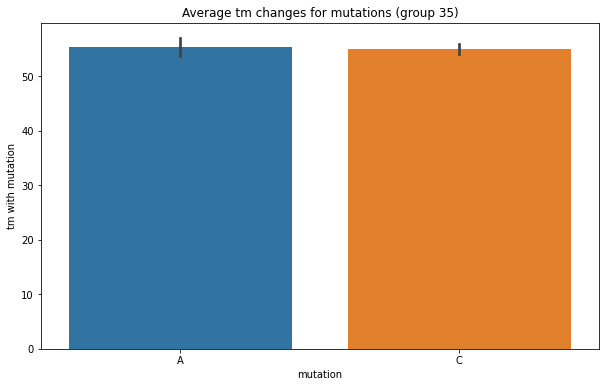

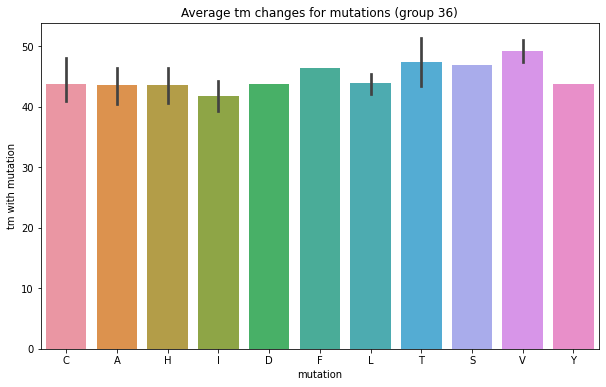

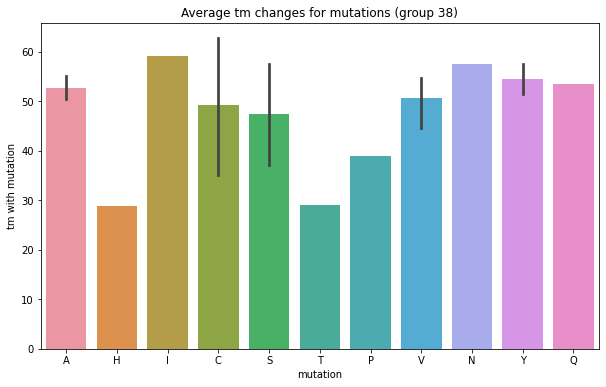

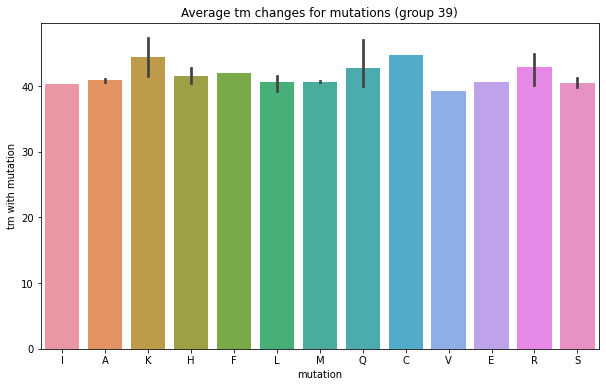

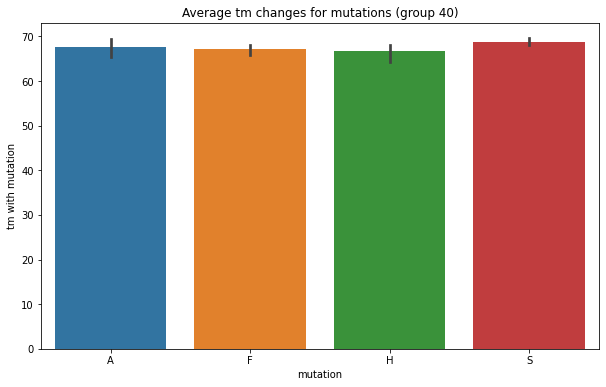

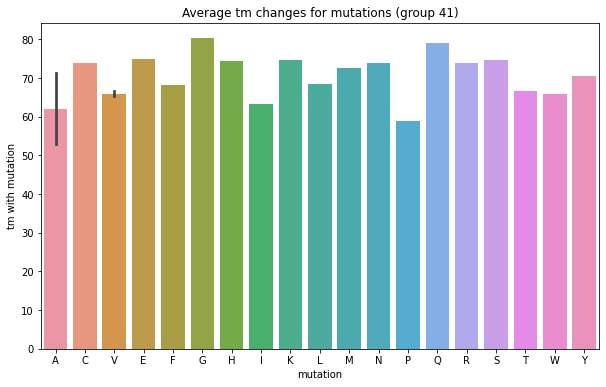

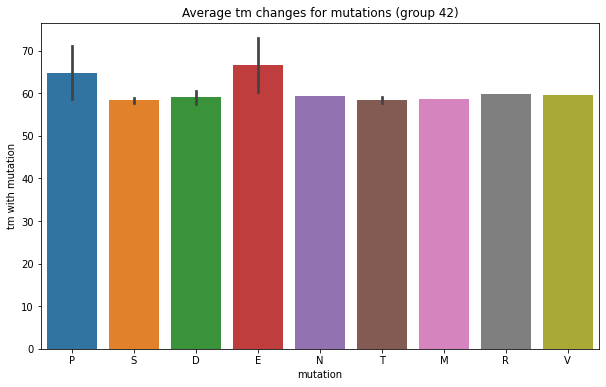

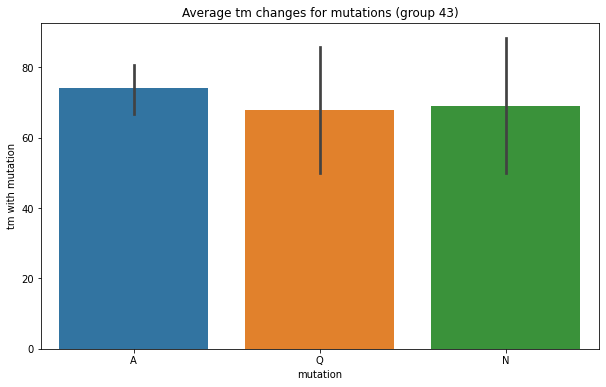

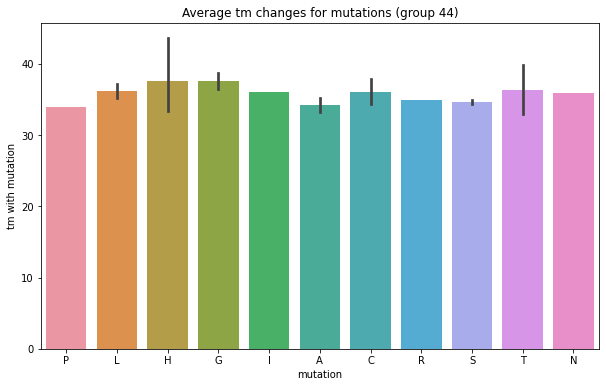

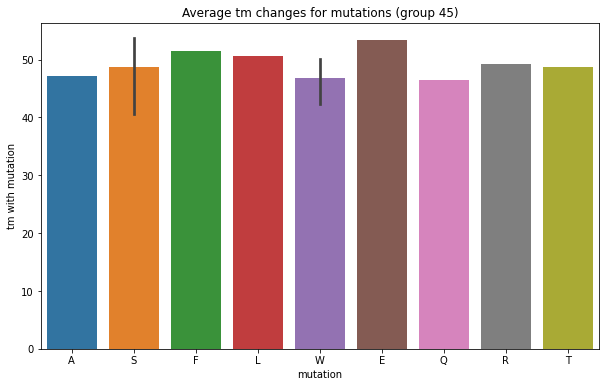

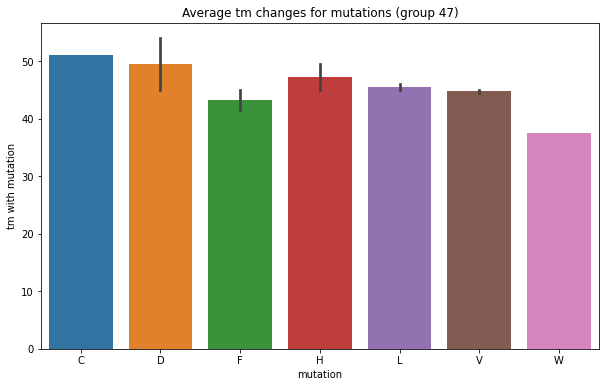

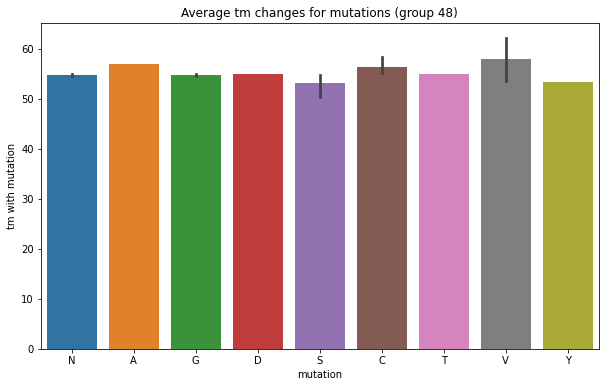

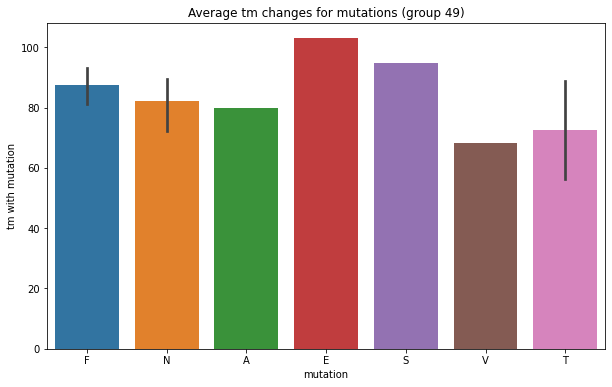

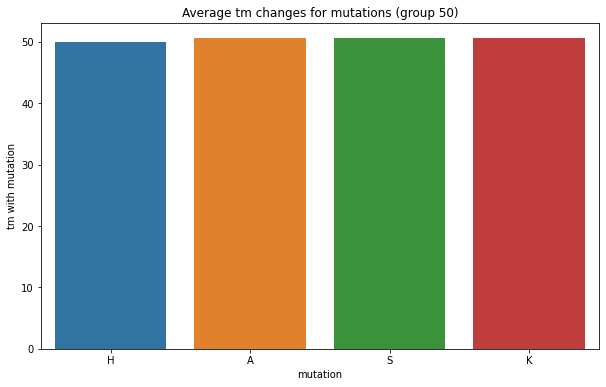

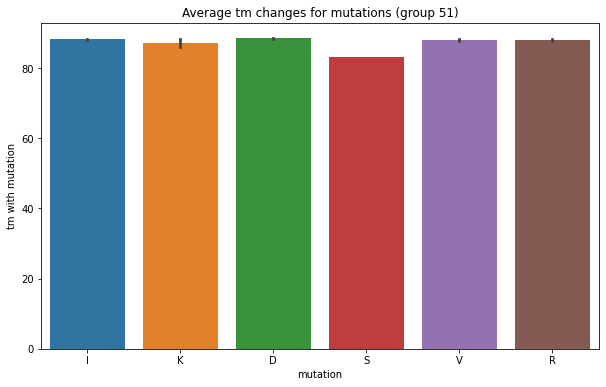

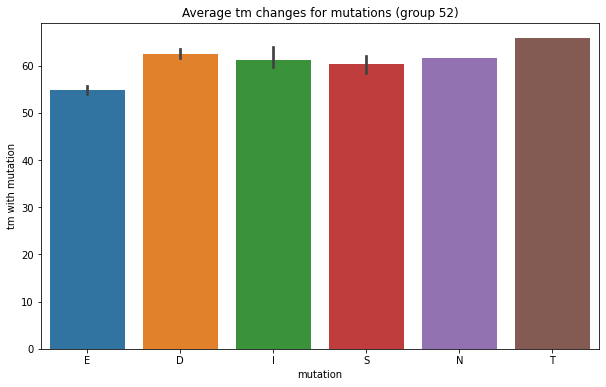

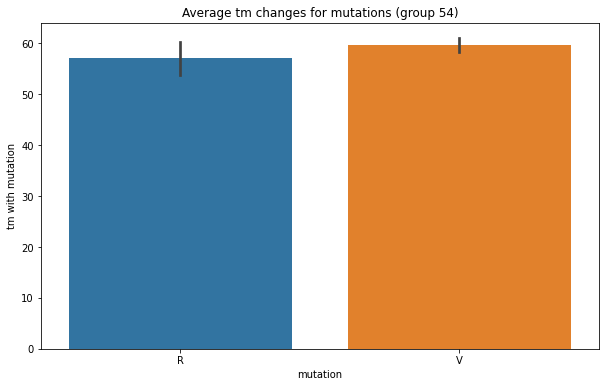

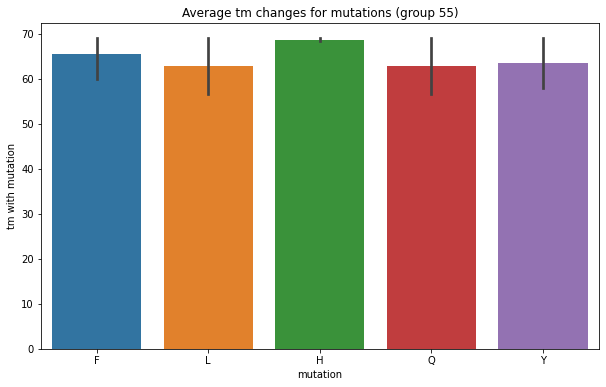

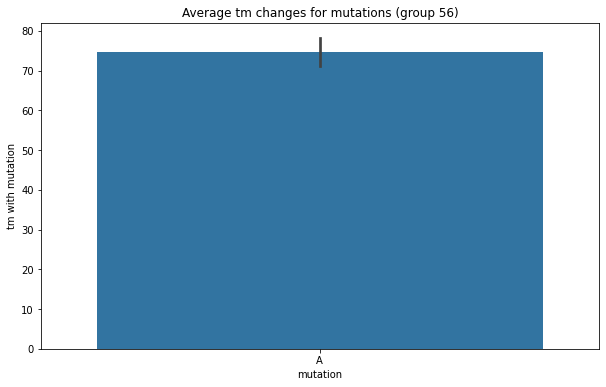

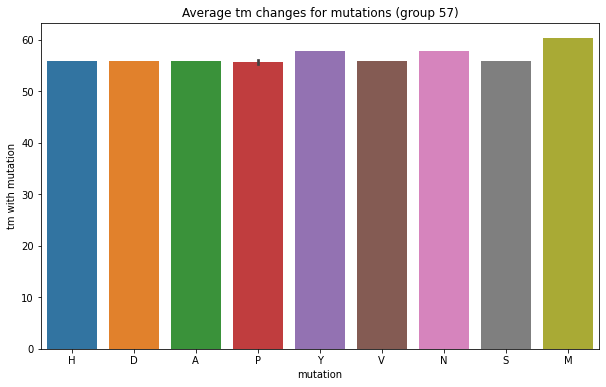

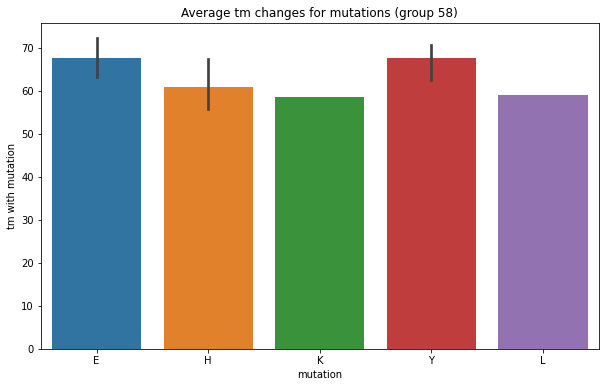

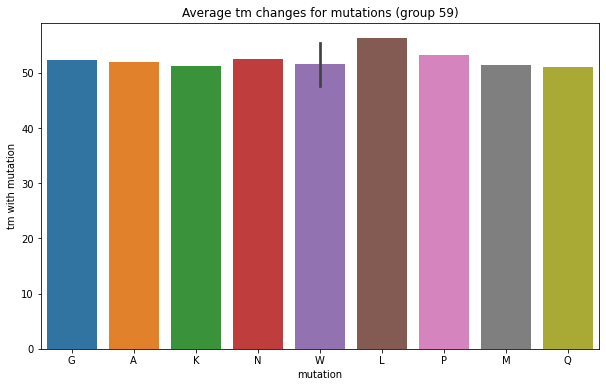

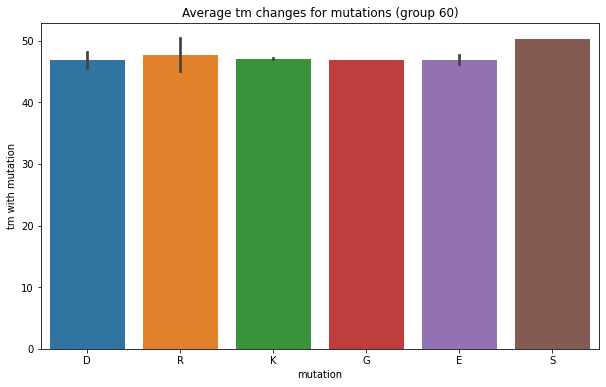

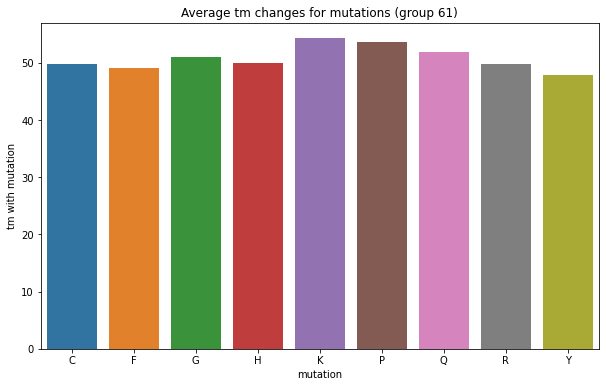

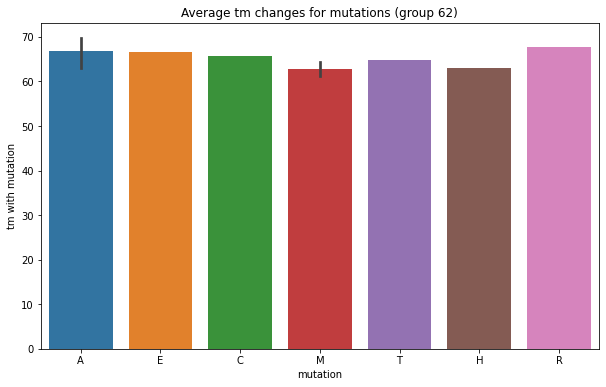

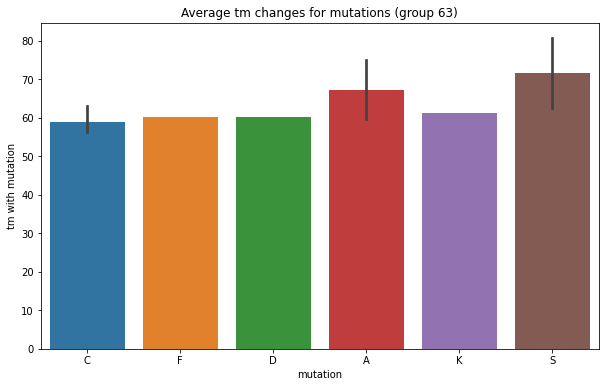

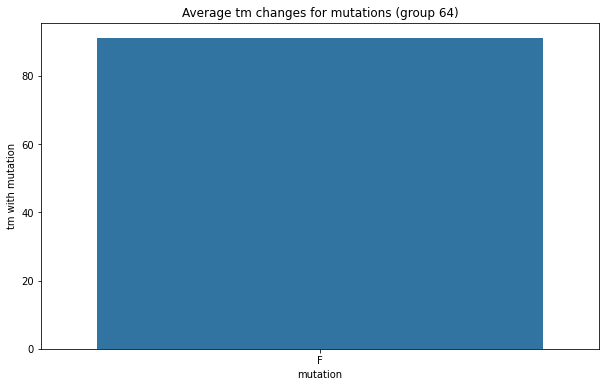

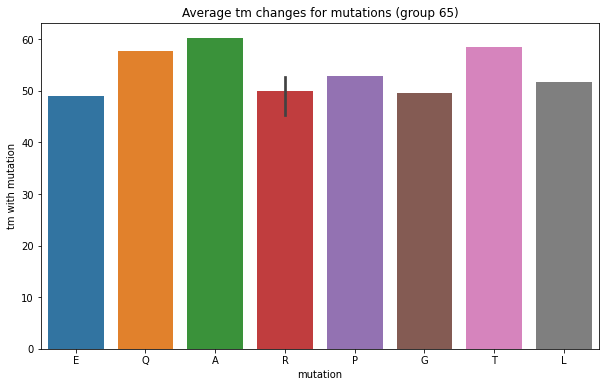

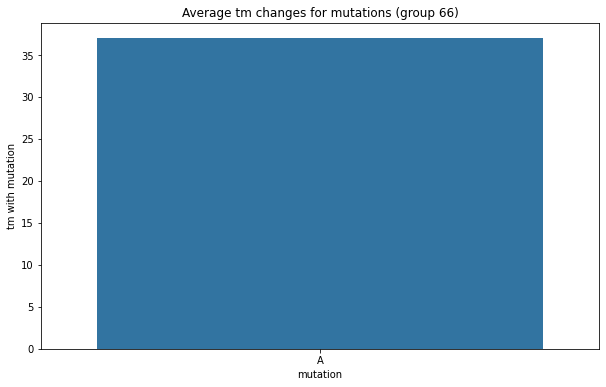

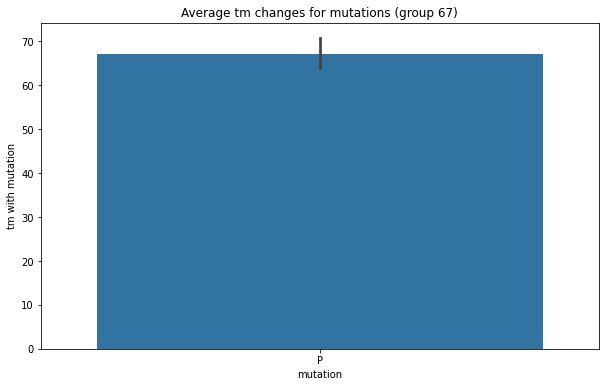

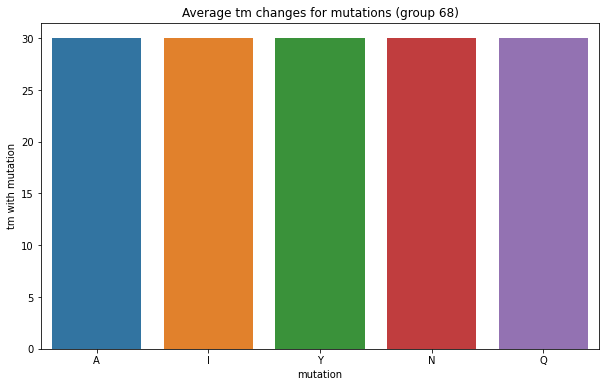

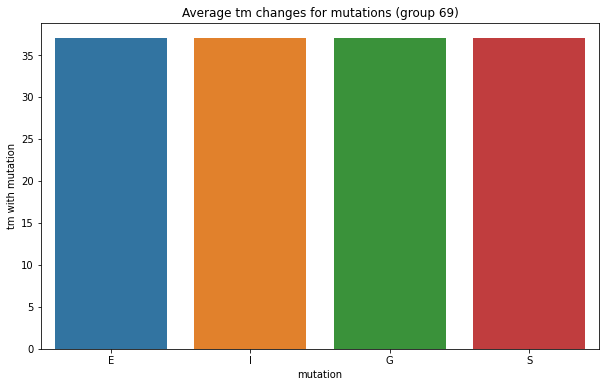

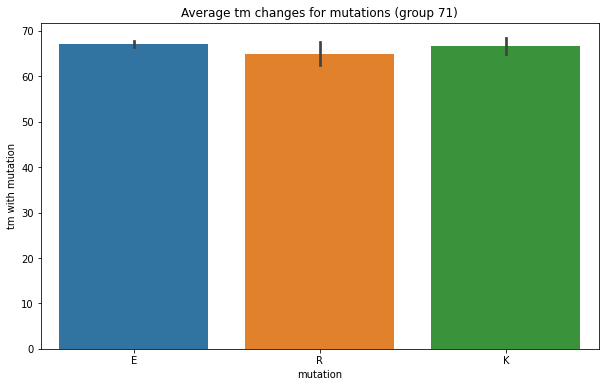

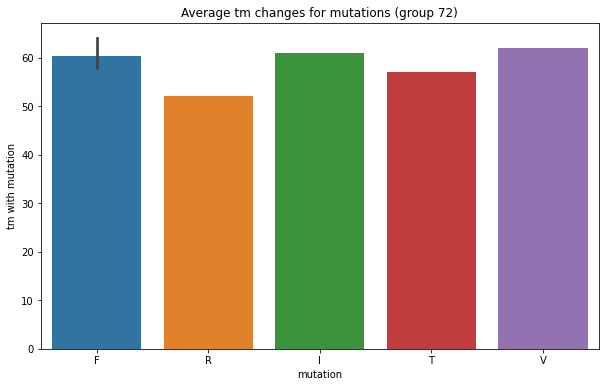

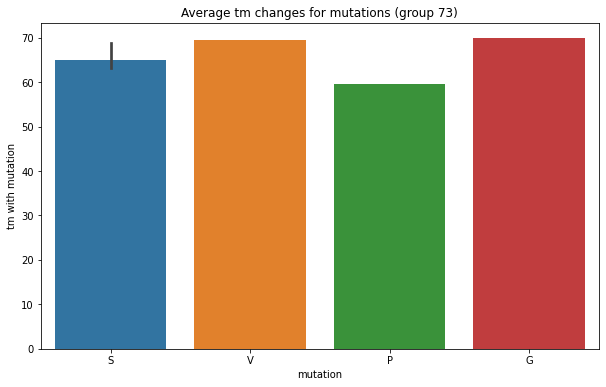

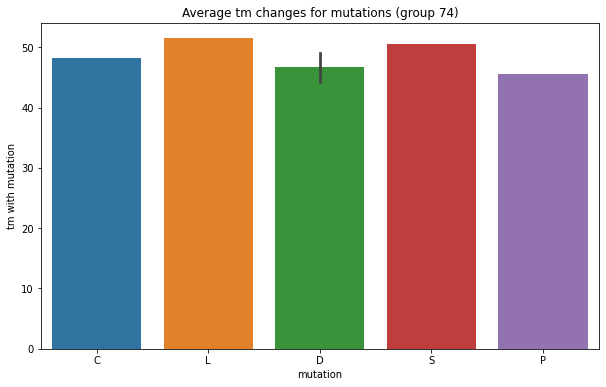

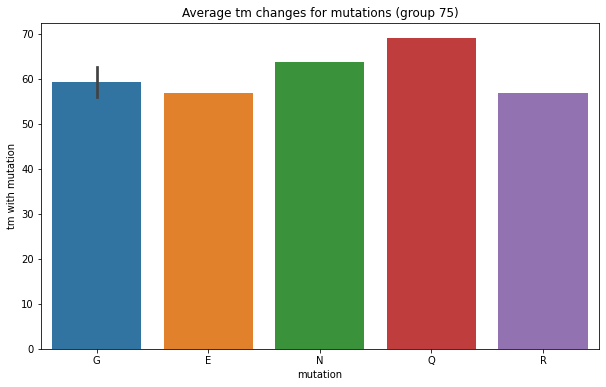

In [74]:
for group in pH_groups:
    # Set the width and height of the figure
    plt.figure(figsize=(10,6))

    # Add title
    plt.title(f"Average tm changes for mutations (group {group})")

    # Bar chart showing average arrival delay for Spirit Airlines flights by month
    sns.barplot(x=pH_df.loc[pH_df.group == group].mutation, y=pH_df.loc[pH_df.group == group]['tm'])

    # Add label for vertical axis
    plt.ylabel("tm with mutation")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


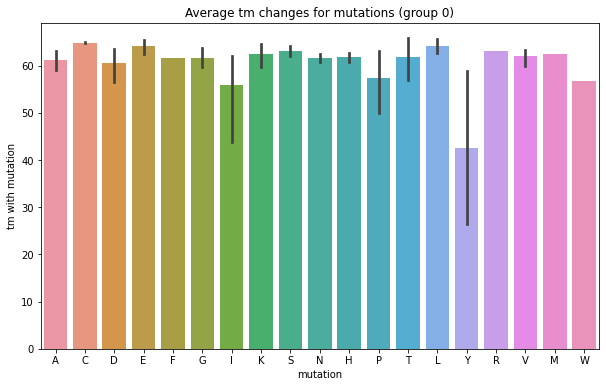

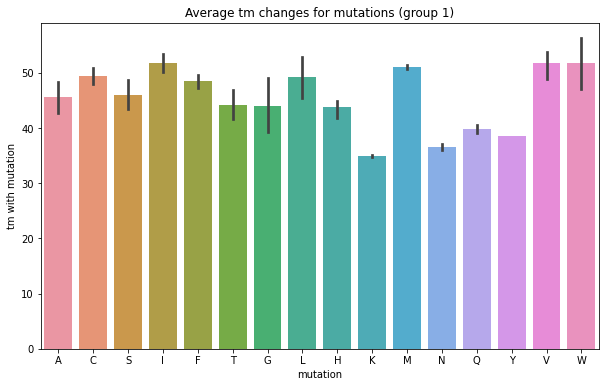

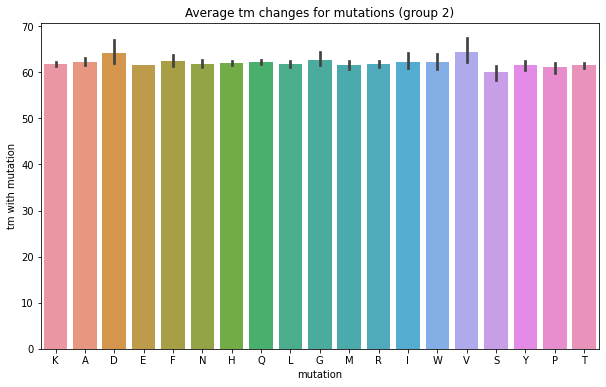

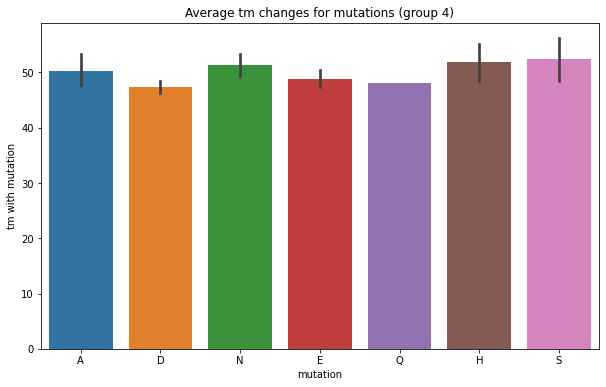

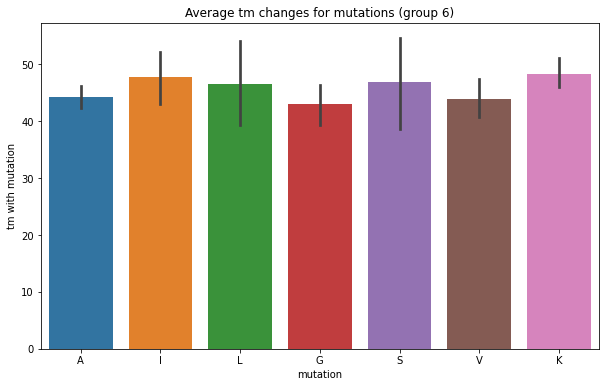

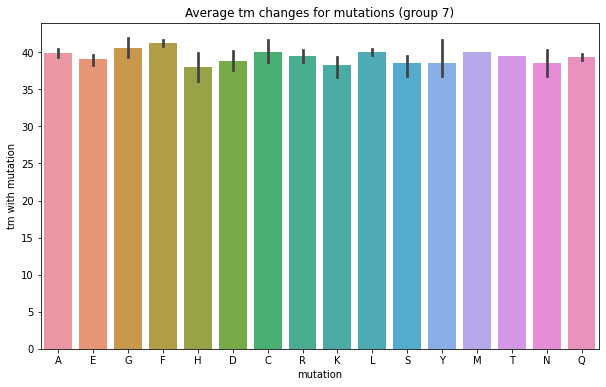

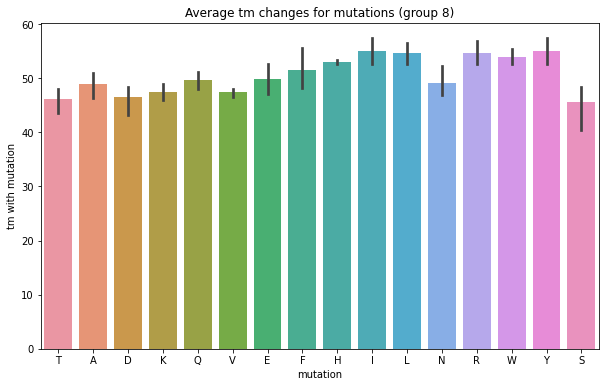

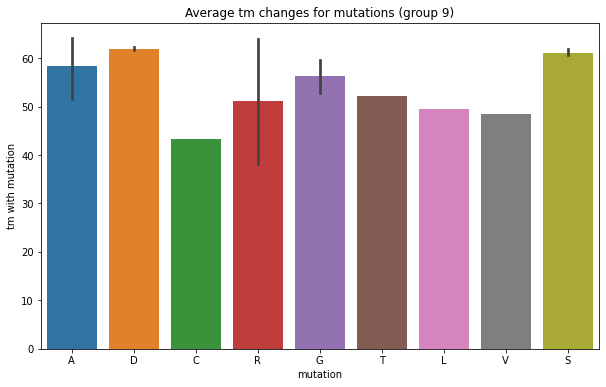

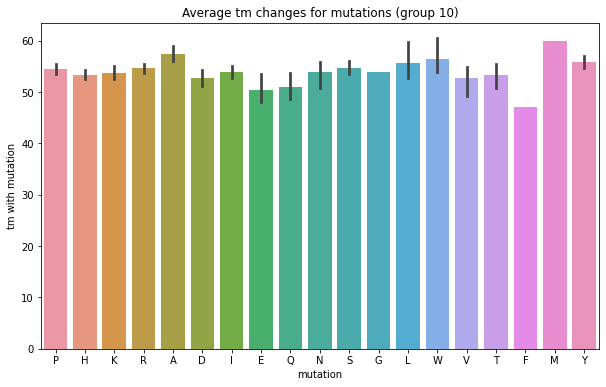

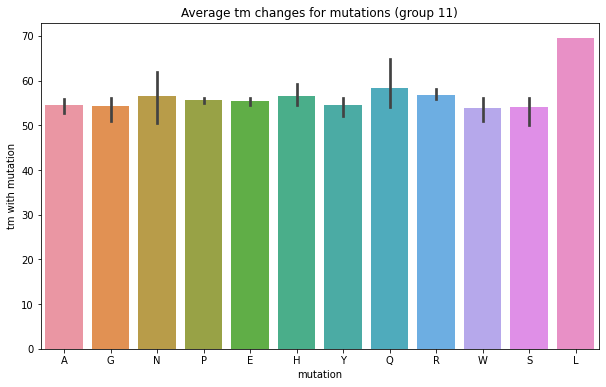

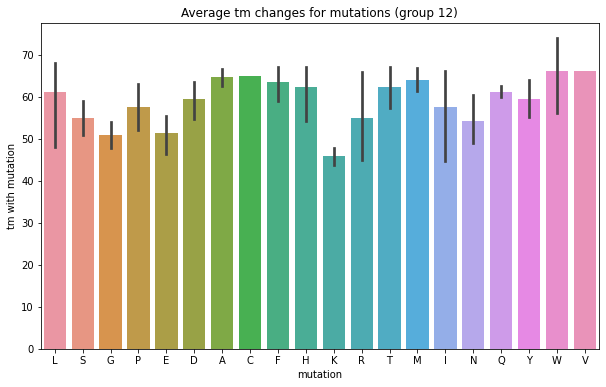

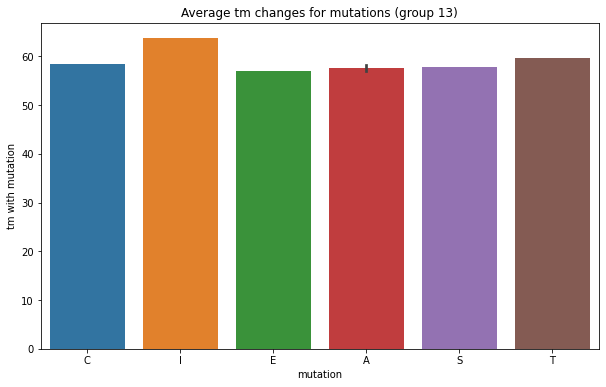

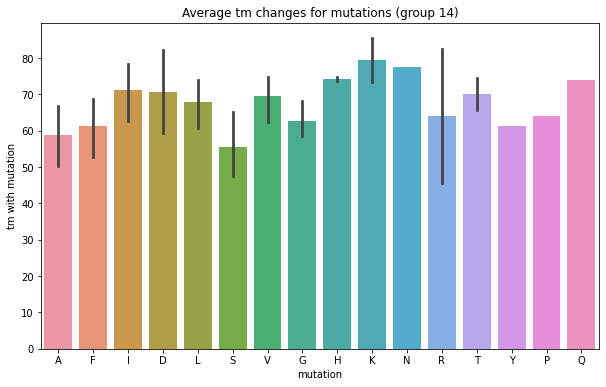

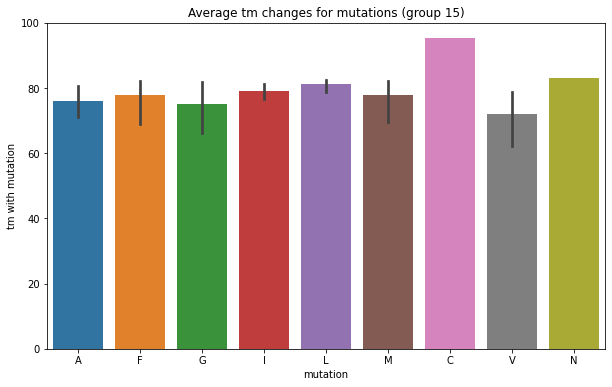

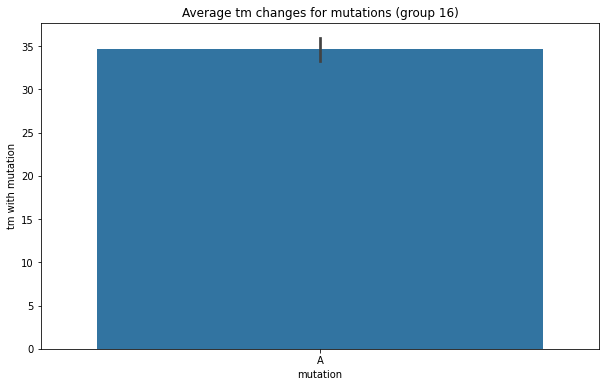

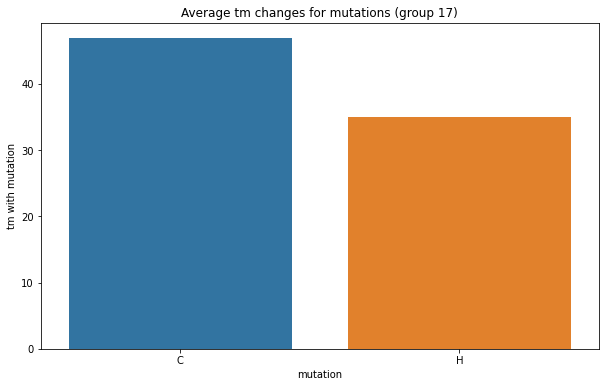

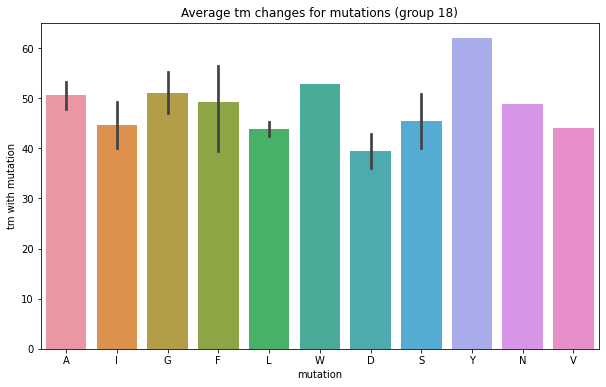

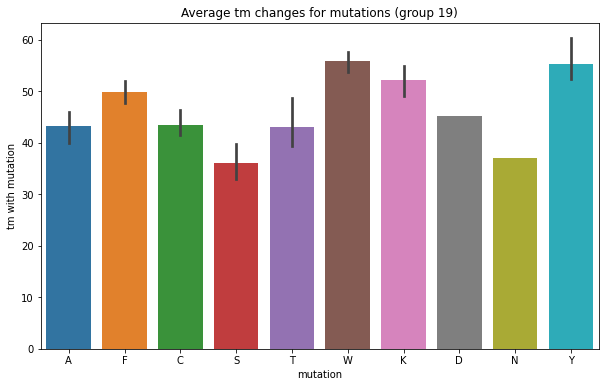

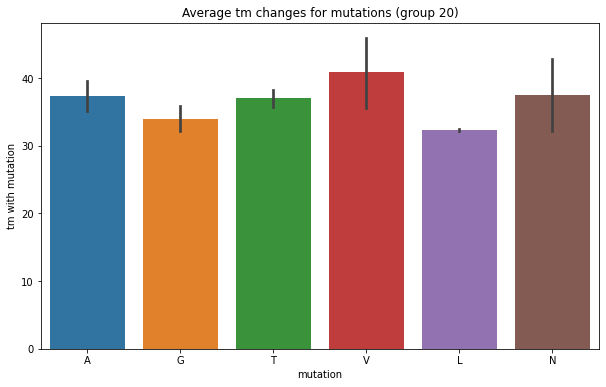

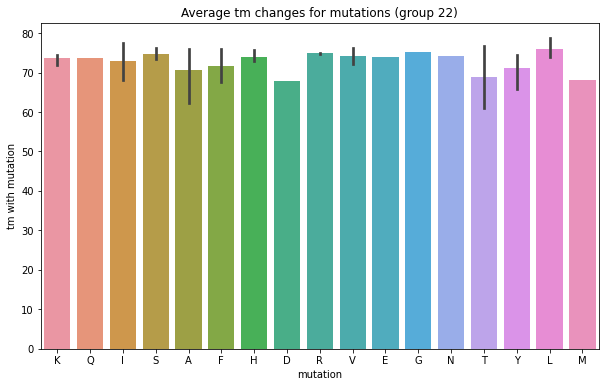

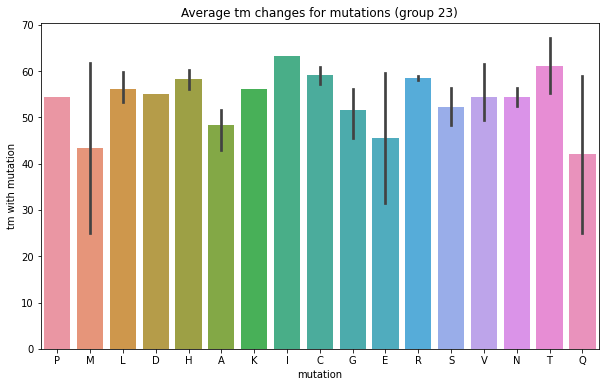

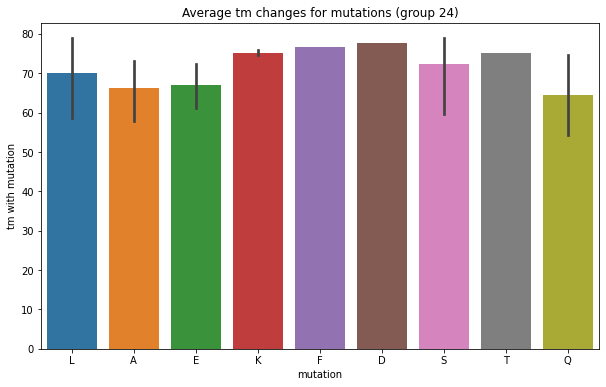

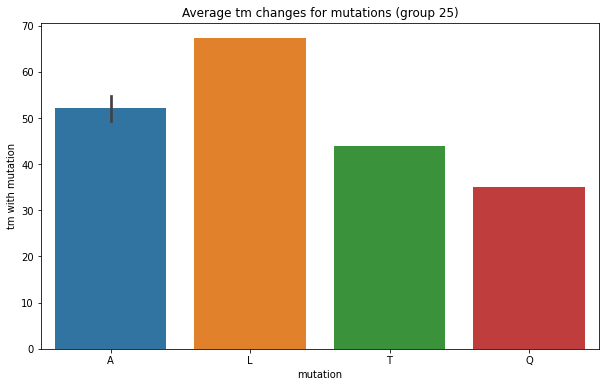

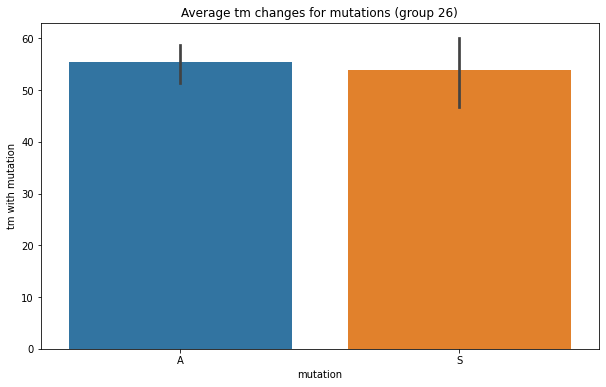

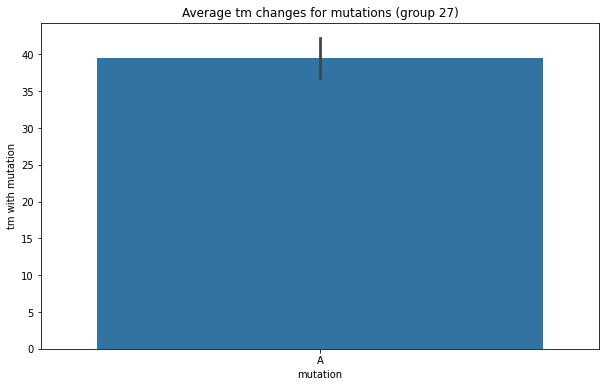

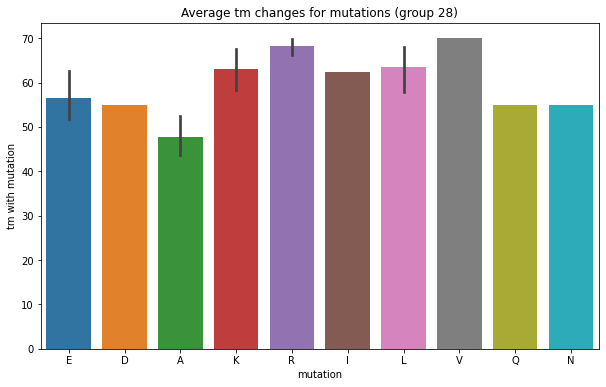

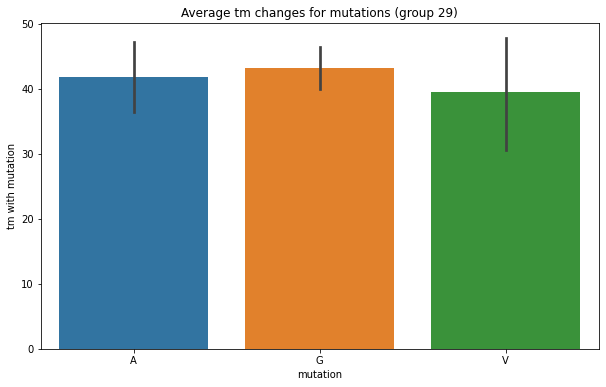

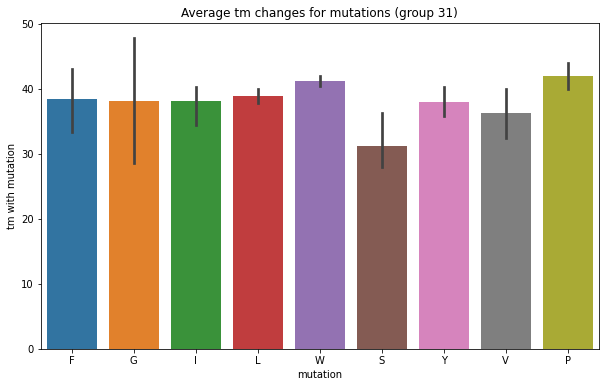

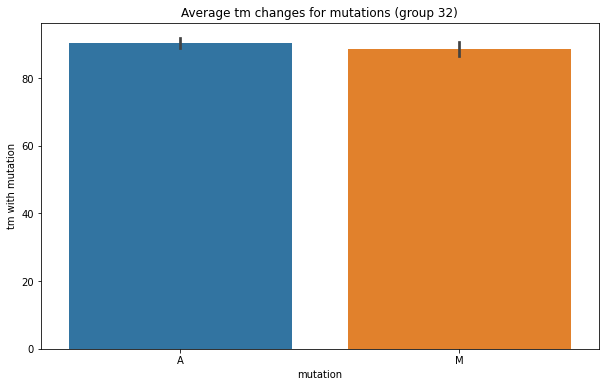

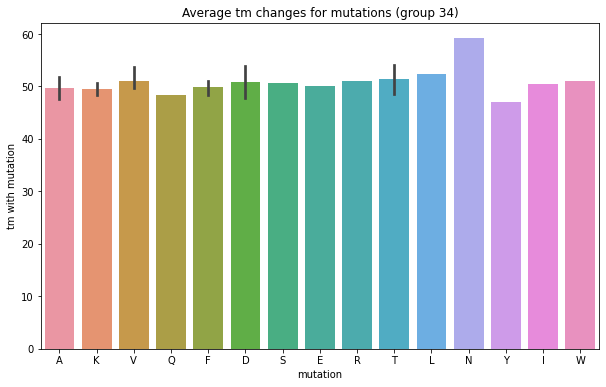

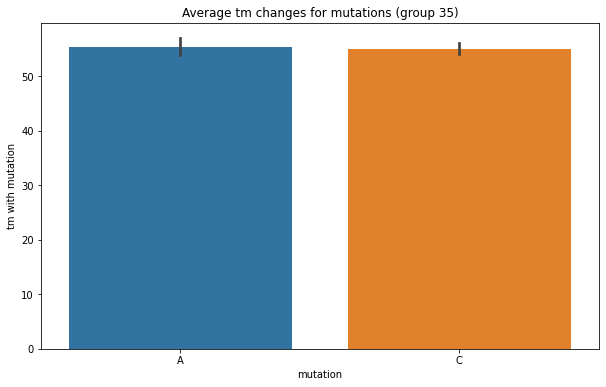

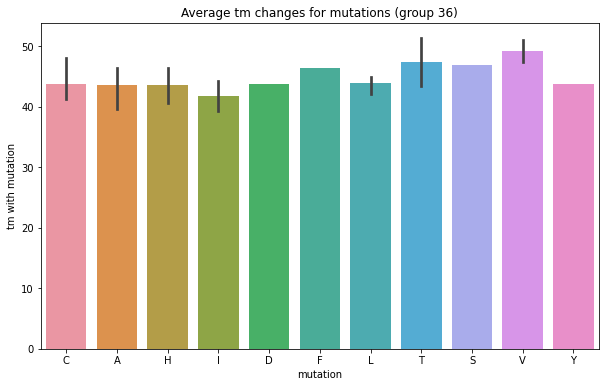

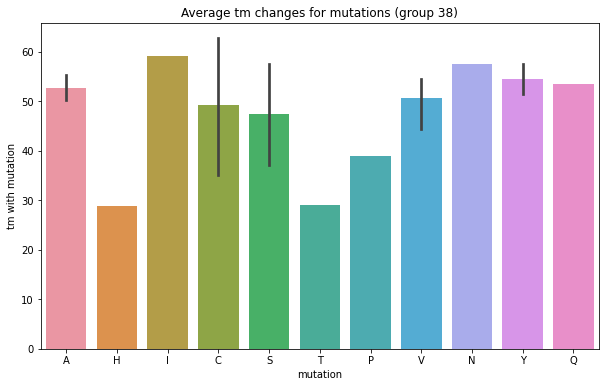

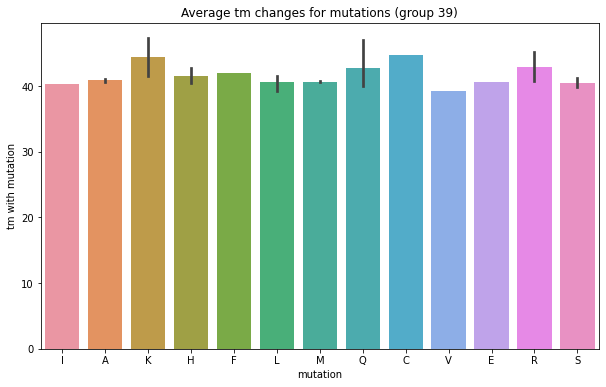

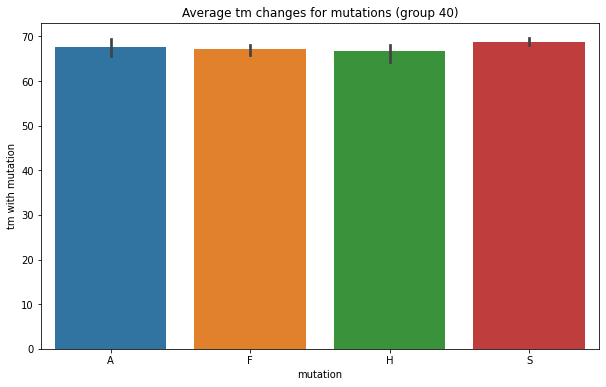

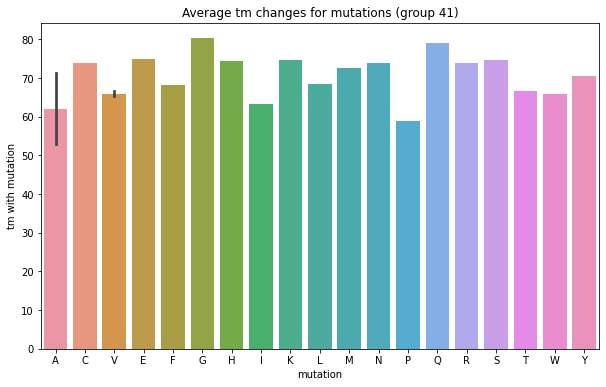

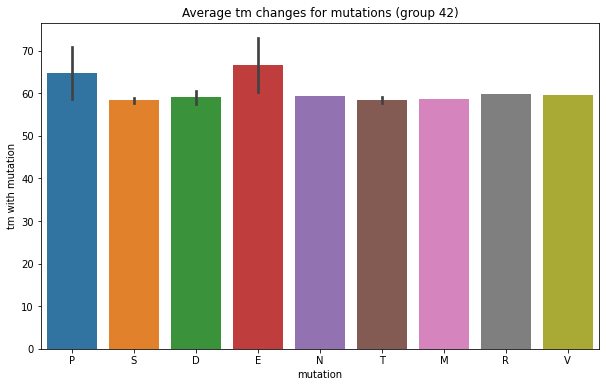

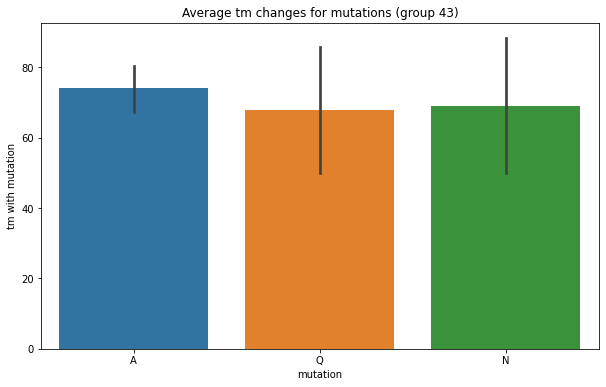

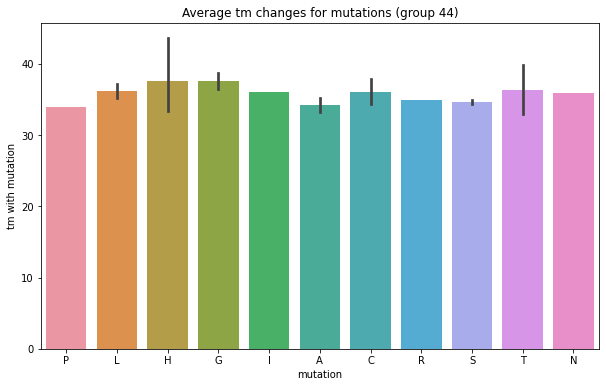

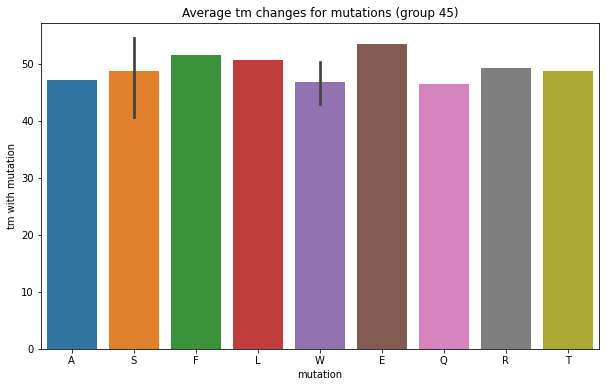

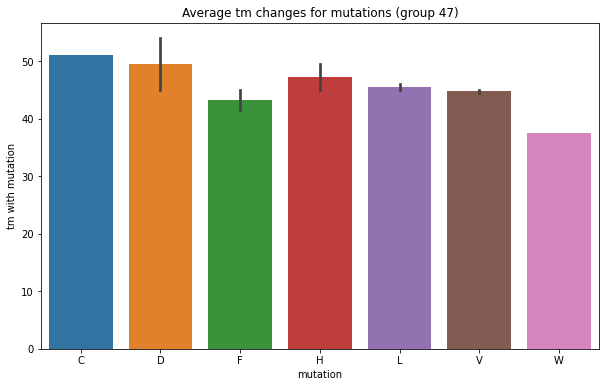

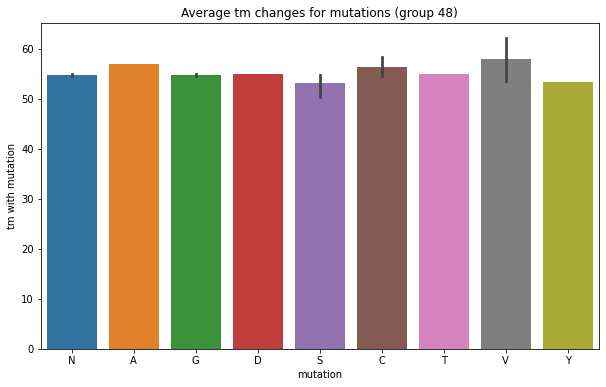

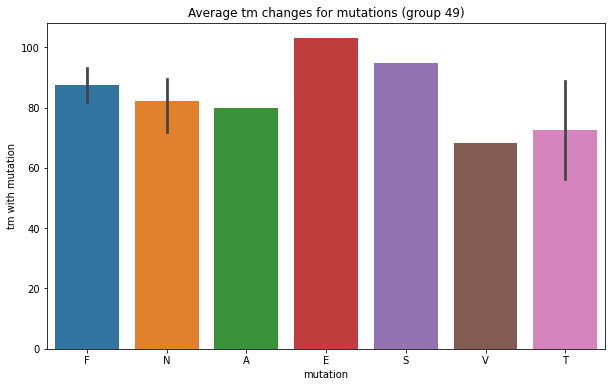

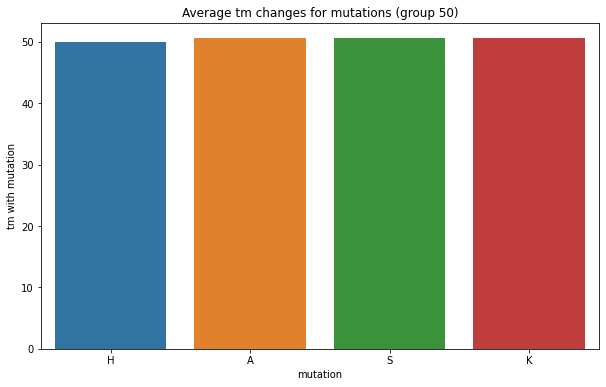

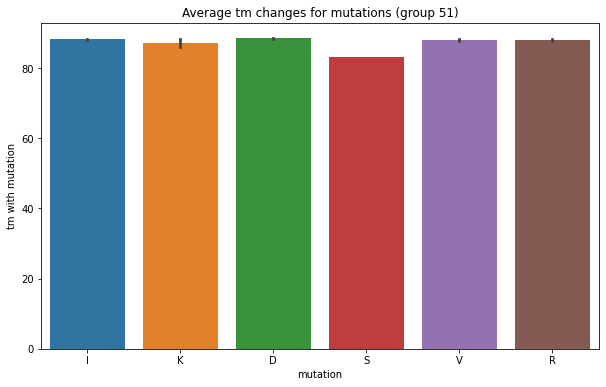

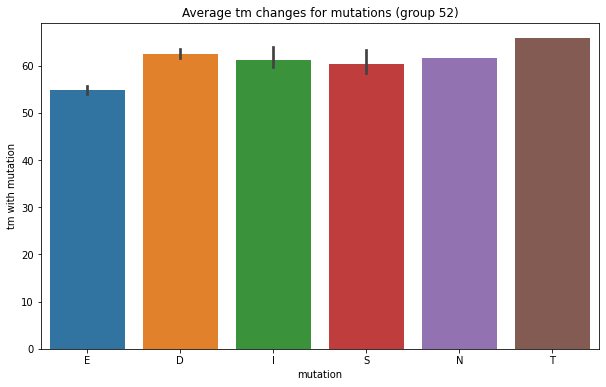

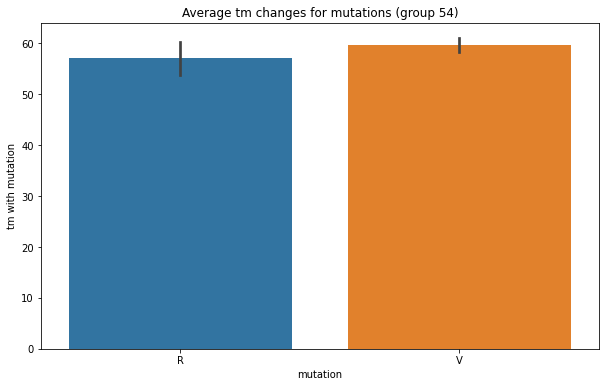

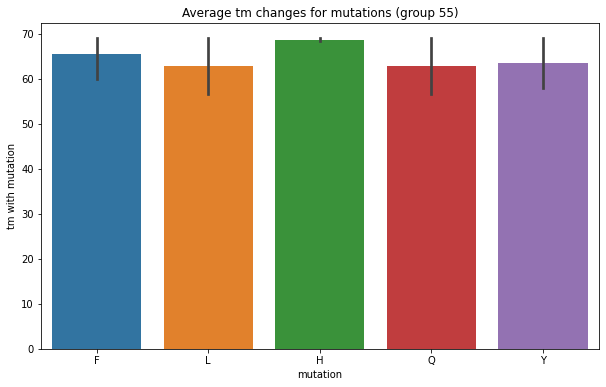

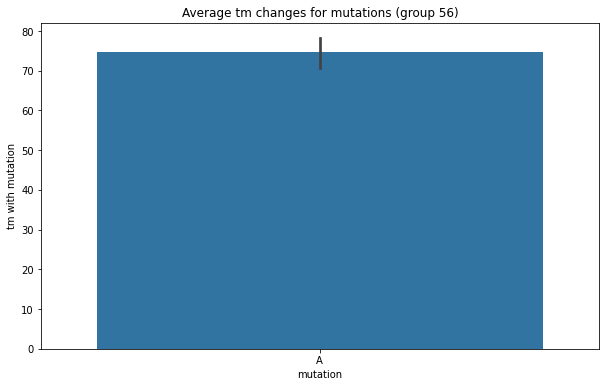

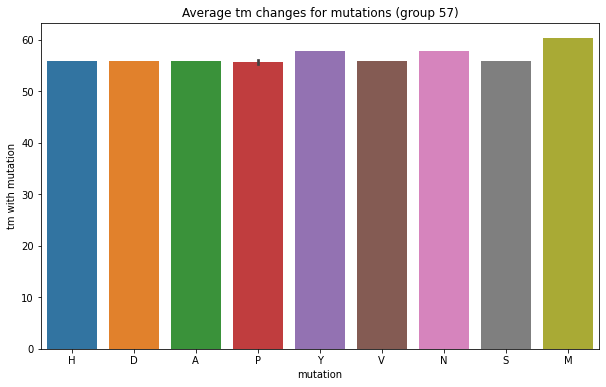

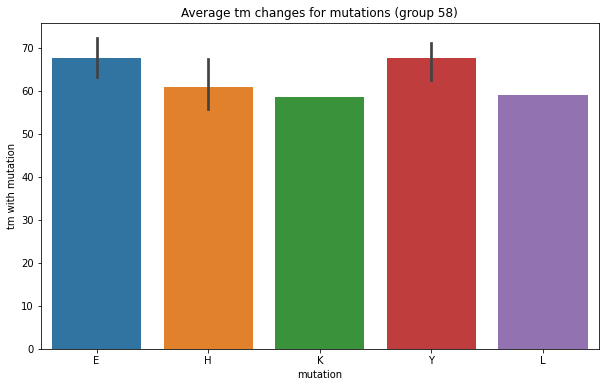

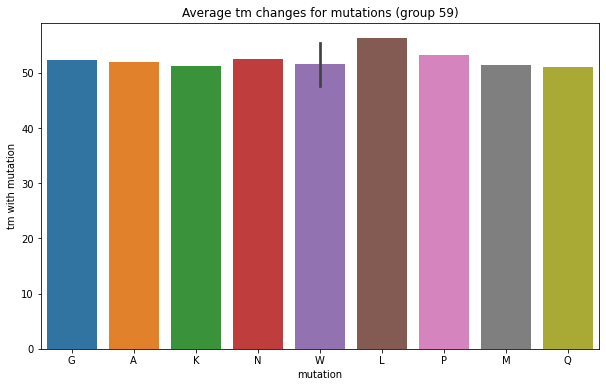

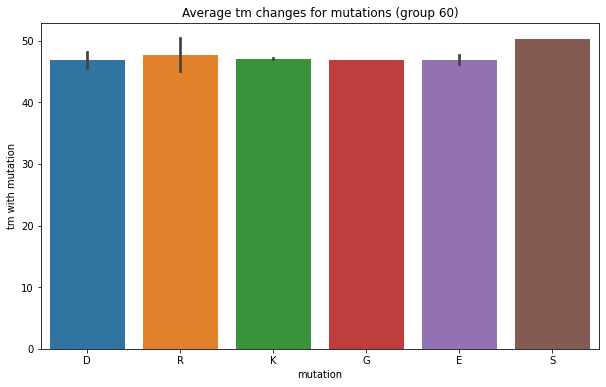

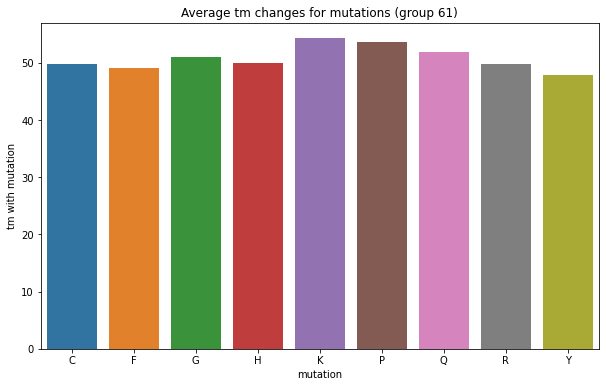

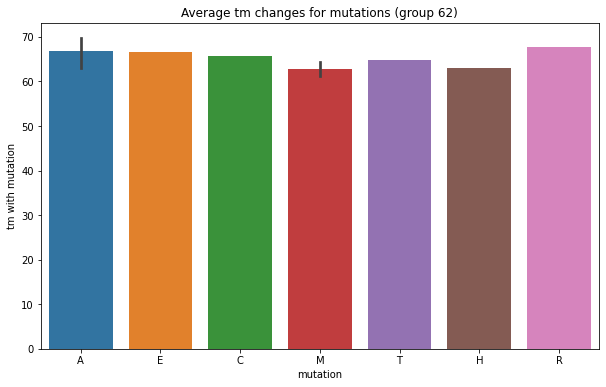

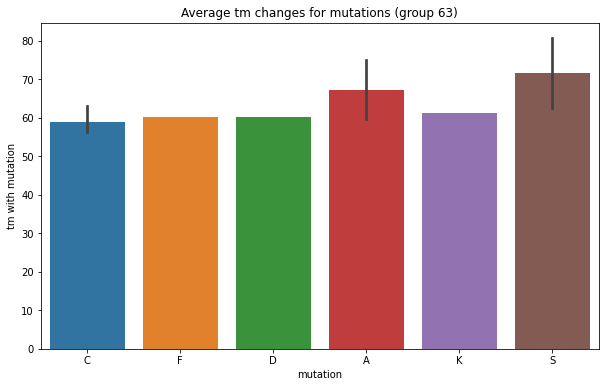

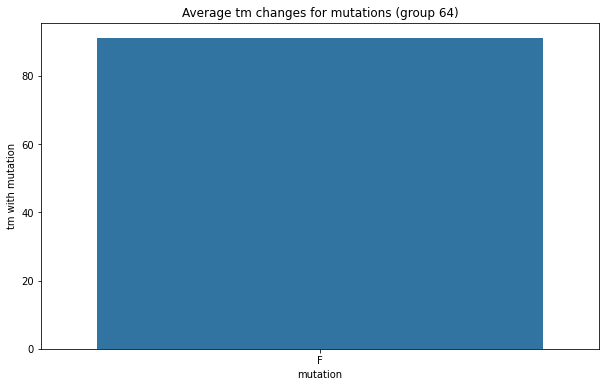

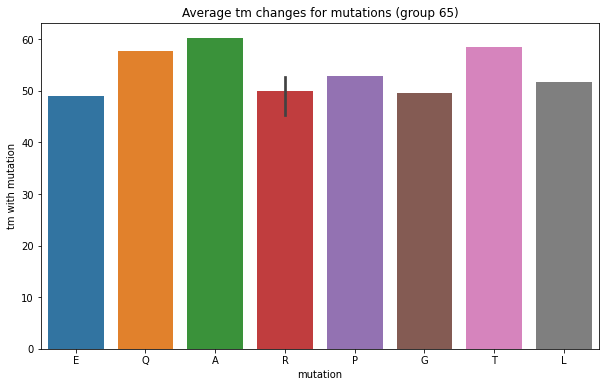

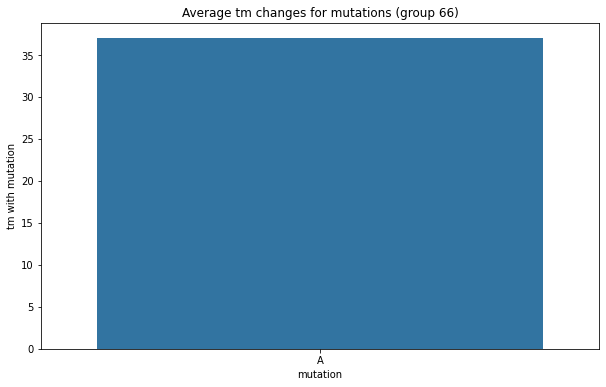

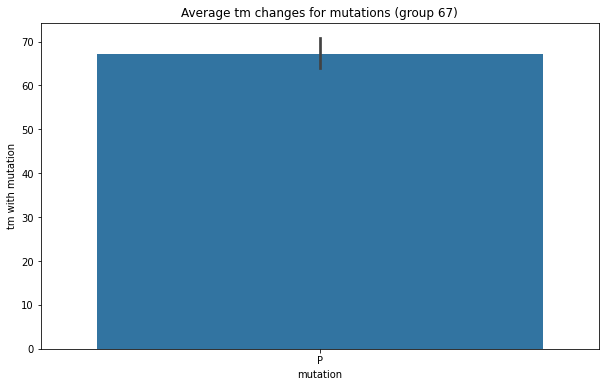

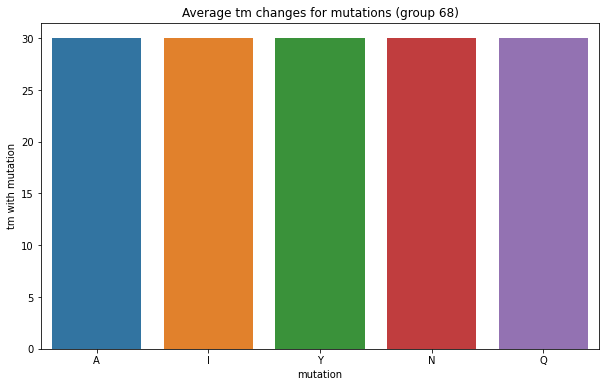

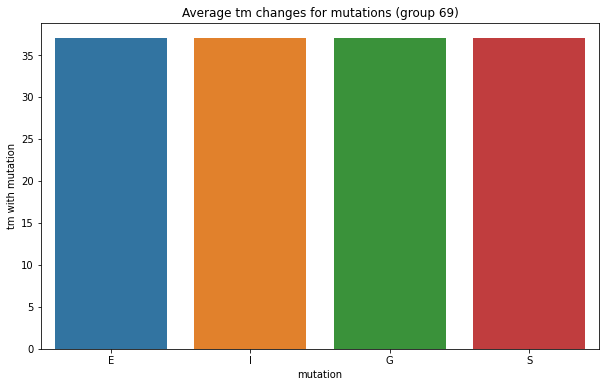

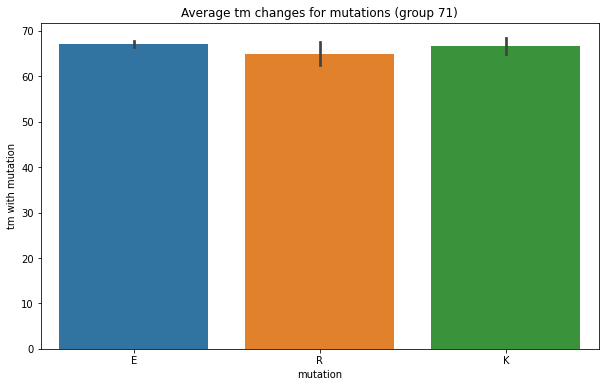

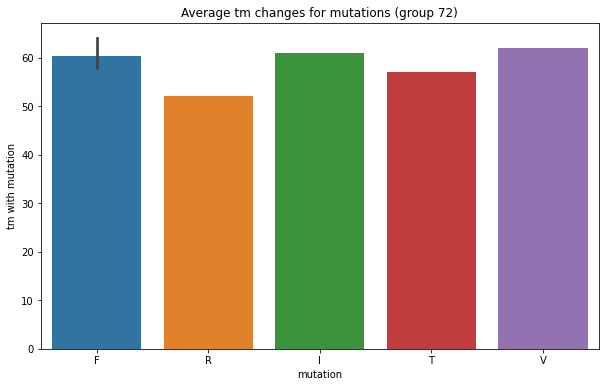

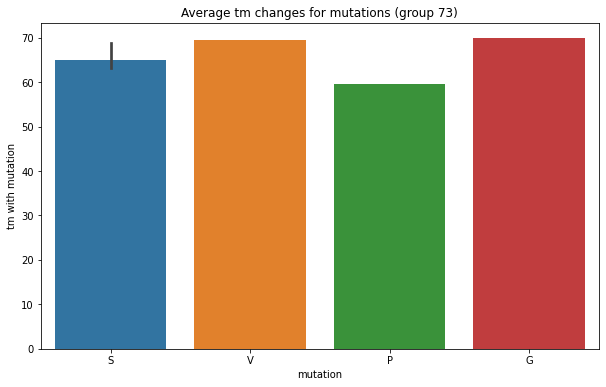

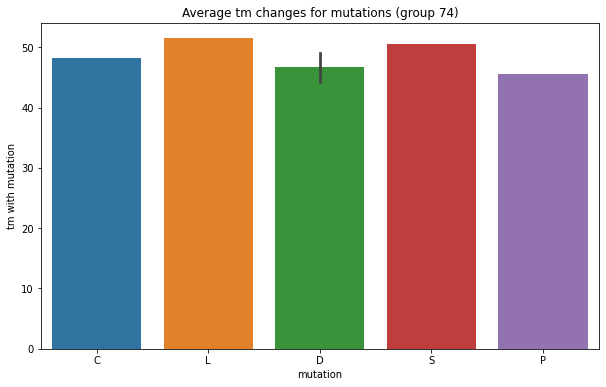

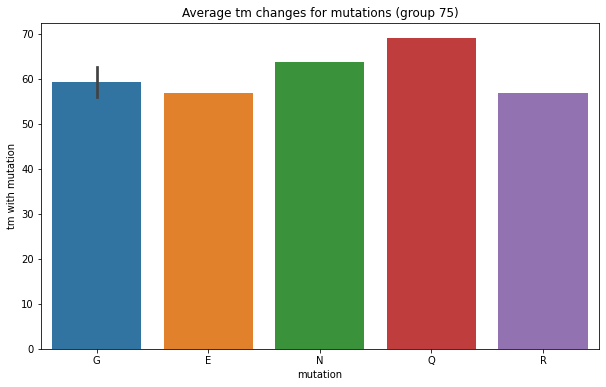

In [75]:
for group in pH_groups:
    # Set the width and height of the figure
    plt.figure(figsize=(10,6))

    # Add title
    plt.title(f"Average tm changes for mutations (group {group})")

    # Bar chart showing average arrival delay for Spirit Airlines flights by month
    sns.barplot(x=pH_df.loc[pH_df.group == group].mutation, y=pH_df.loc[pH_df.group == group]['tm'])

    # Add label for vertical axis
    plt.ylabel("tm with mutation")

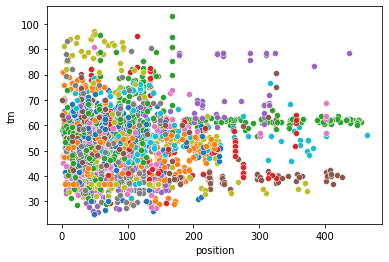

In [76]:
for group in pH_groups:
    sns.scatterplot(x=pH_df.loc[pH_df.group == group]['position'], y=pH_df.loc[pH_df.group == group]['tm'])
# sns.scatterplot(x=experiment_df['position'], y=experiment_df['tm'])

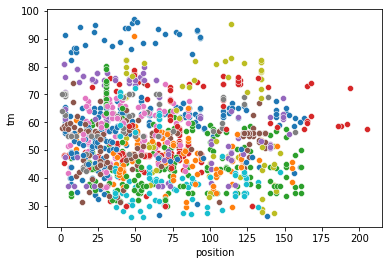

In [84]:
for group in pH_groups:
    sns.scatterplot(x=pH_df.loc[(pH_df.group == group) & (pH_df.x <= 221)]['position'], y=pH_df.loc[(pH_df.group == group) & (pH_df.x <= 221)]['tm'])

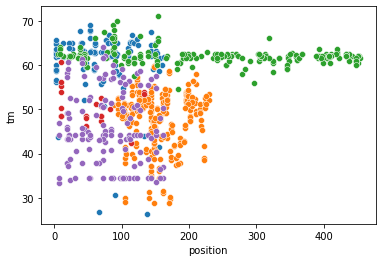

In [82]:
for group in pH_groups[:5]:
    sns.scatterplot(x=pH_df.loc[(pH_df.group == group)]['position'], y=pH_df.loc[(pH_df.group == group)]['tm'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


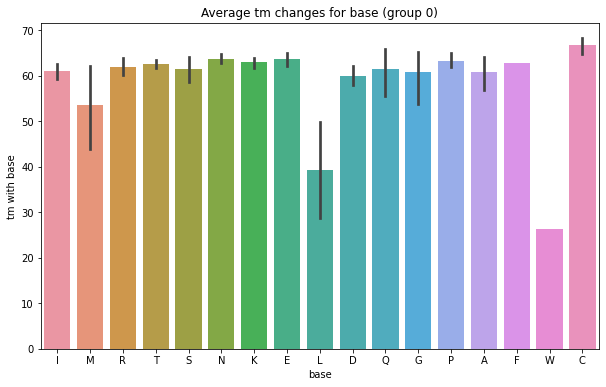

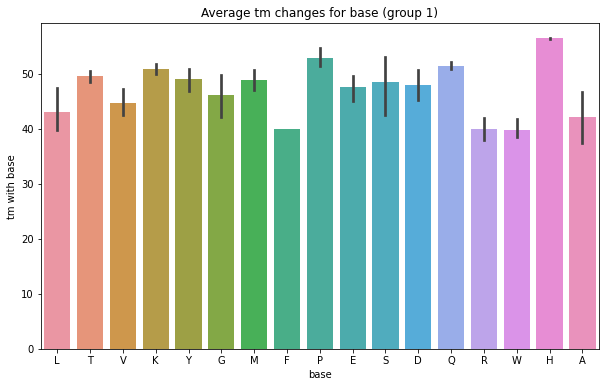

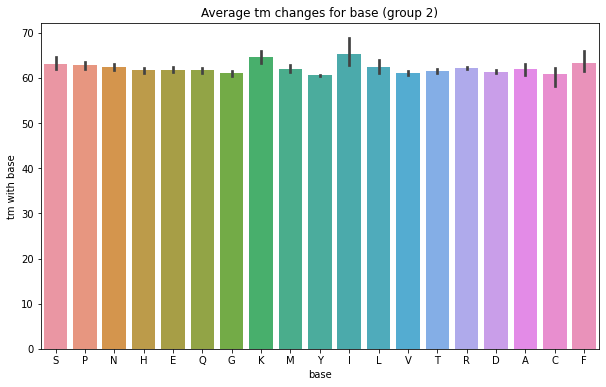

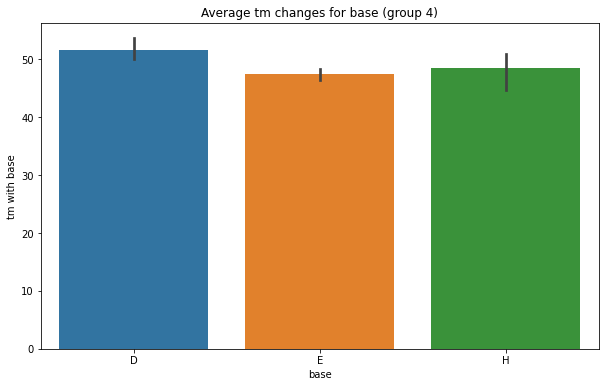

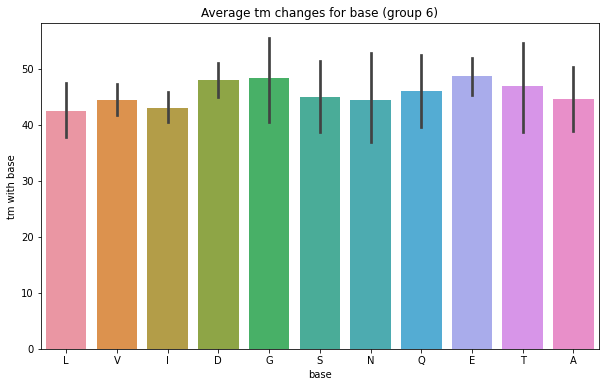

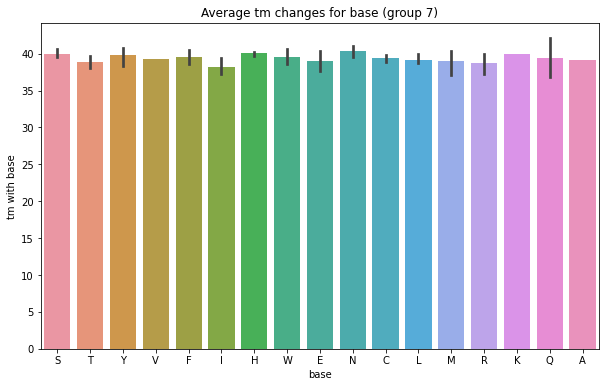

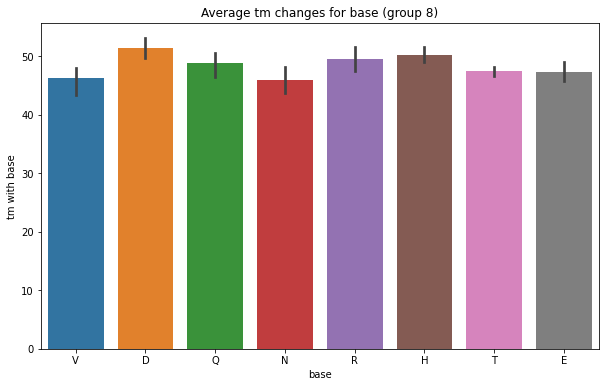

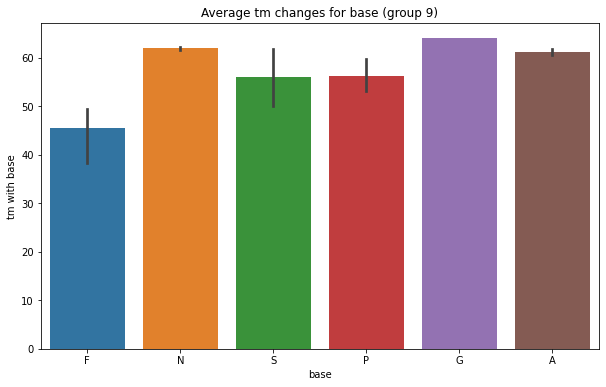

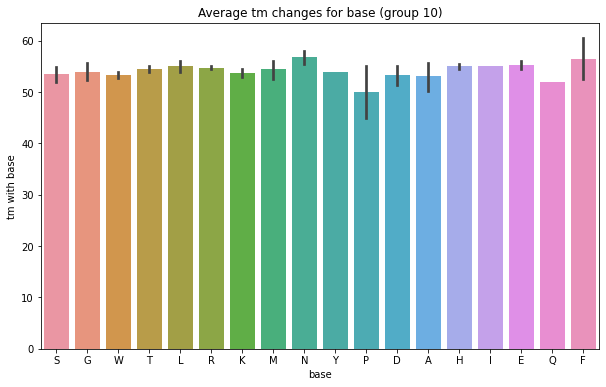

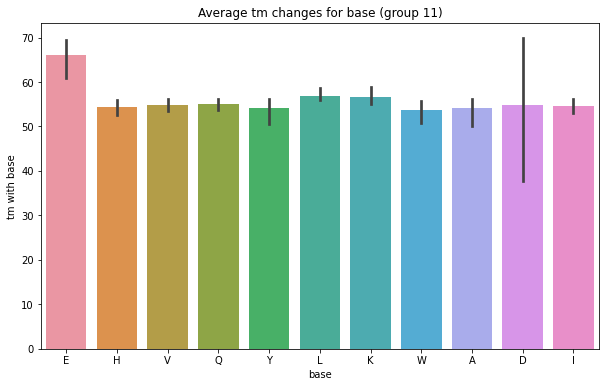

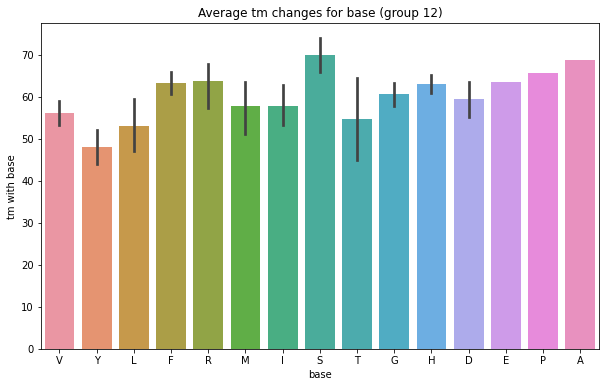

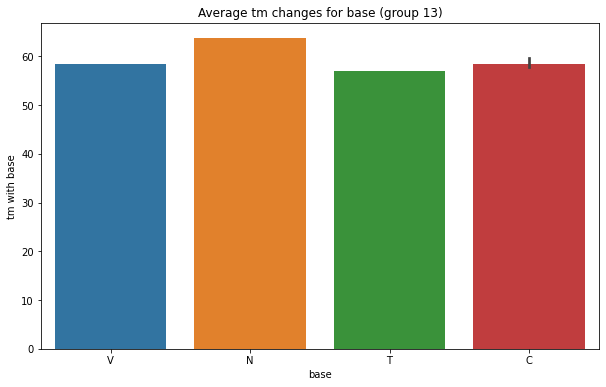

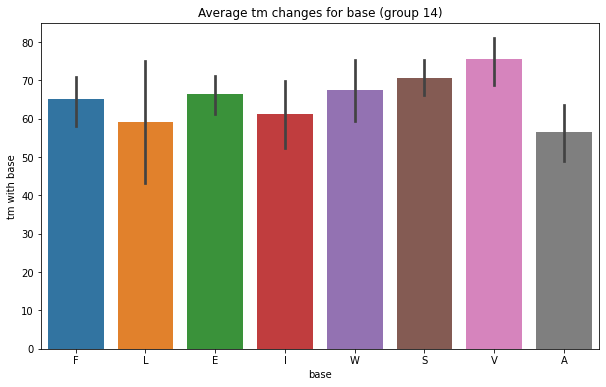

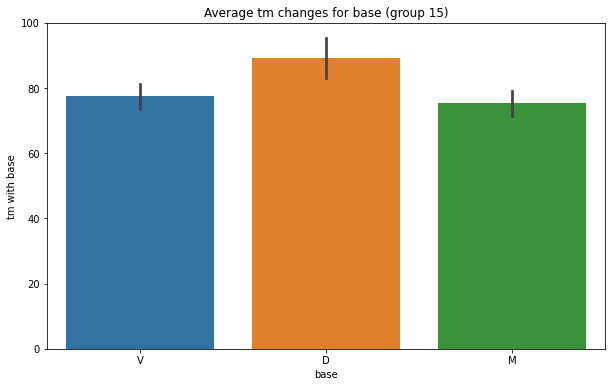

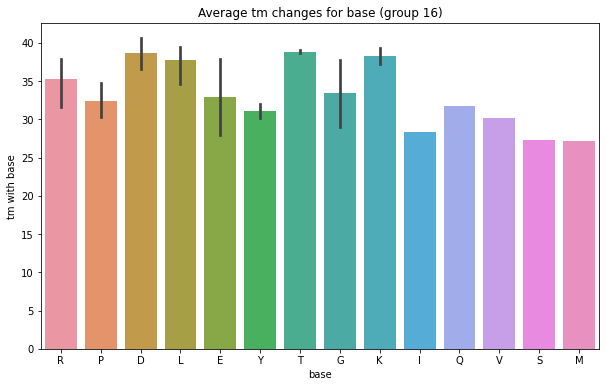

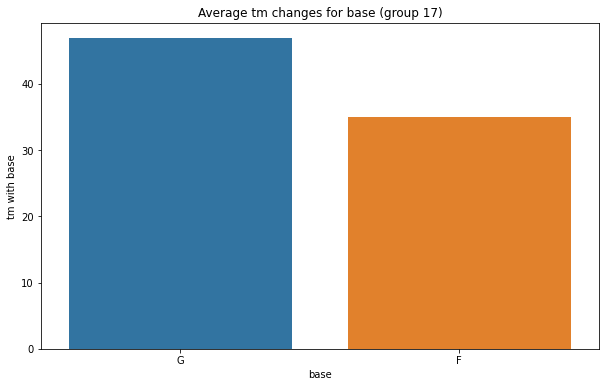

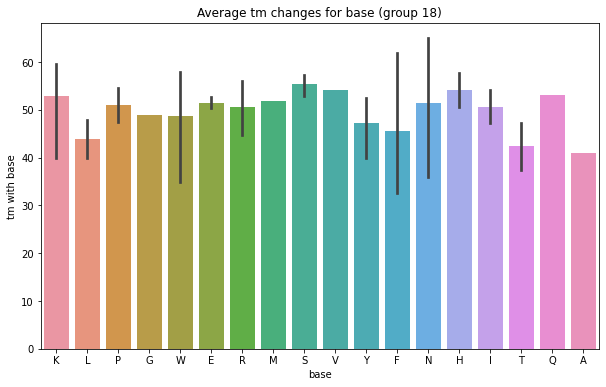

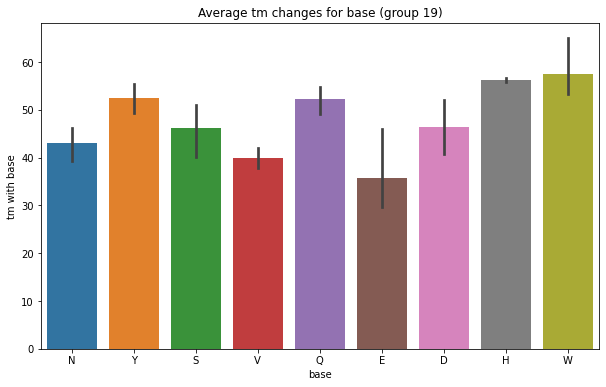

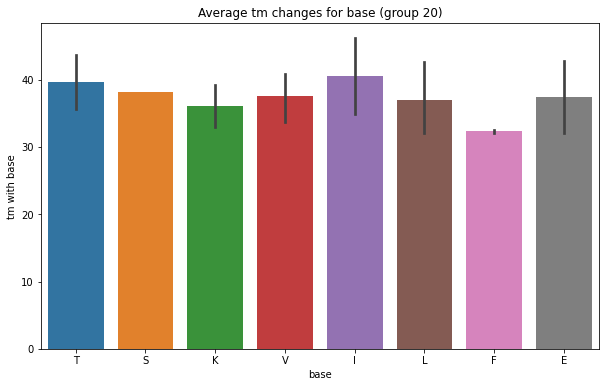

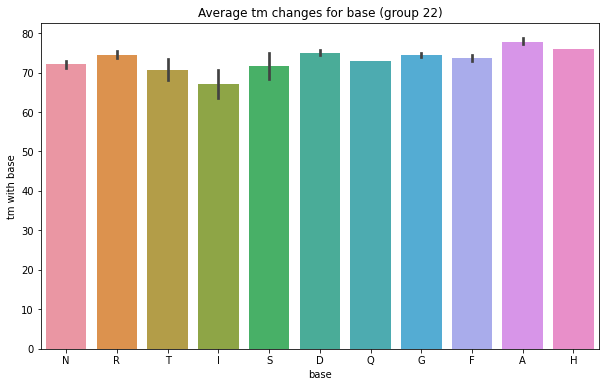

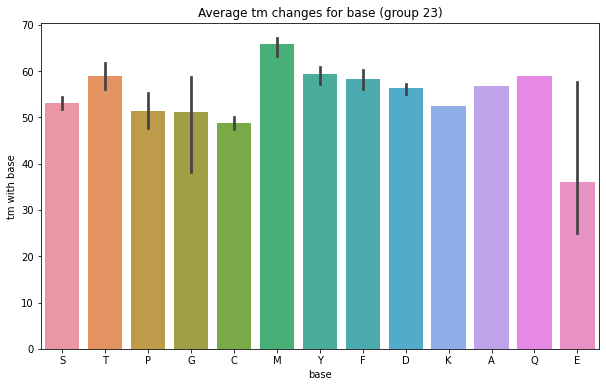

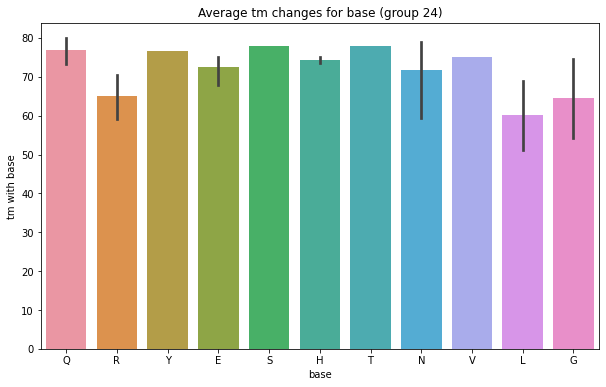

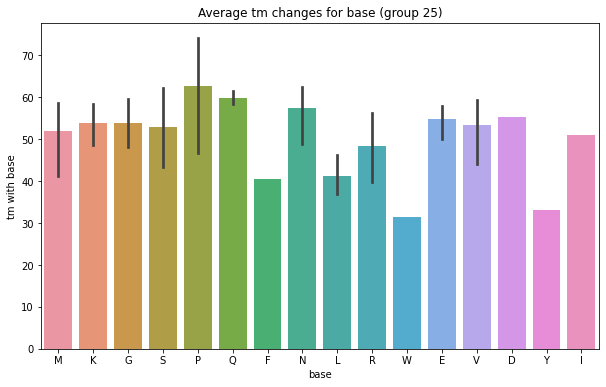

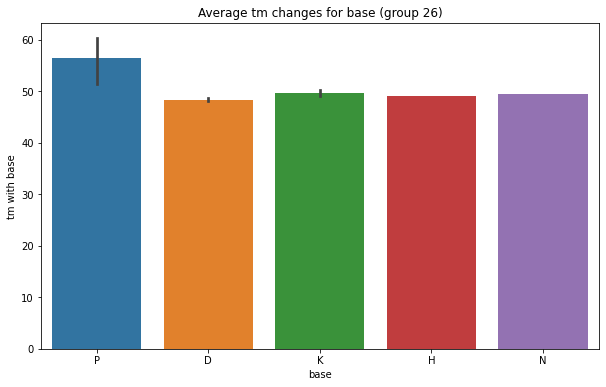

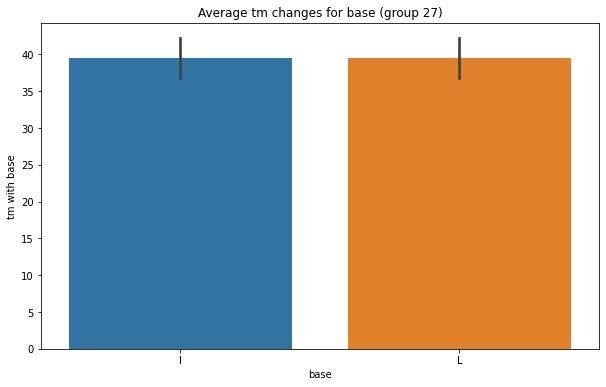

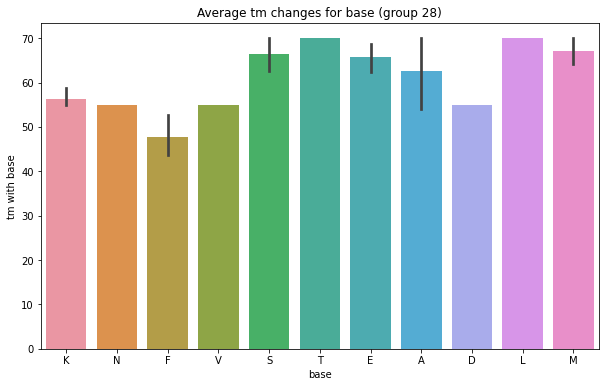

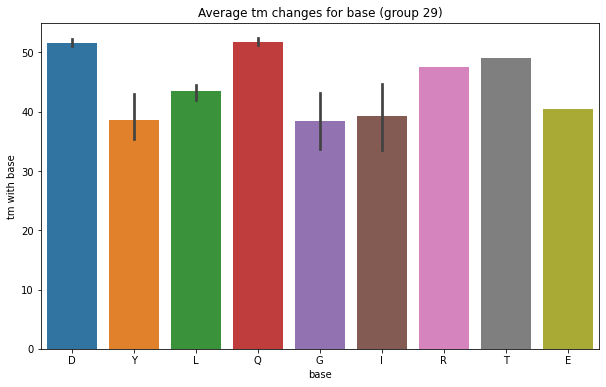

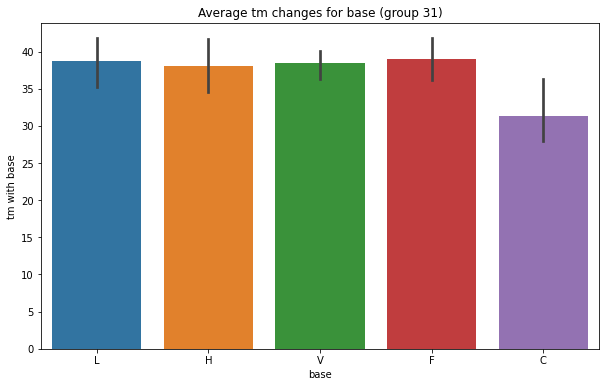

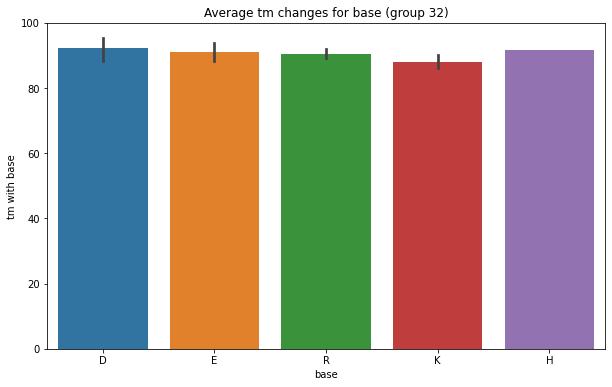

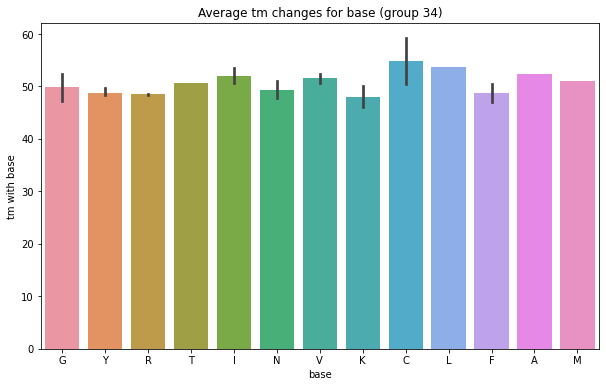

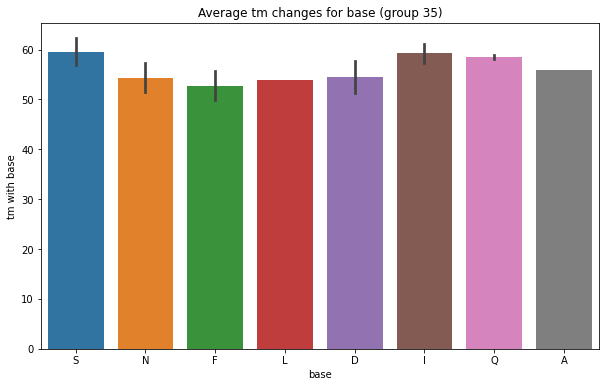

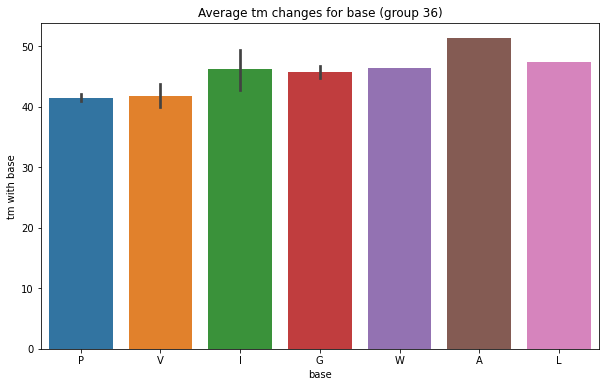

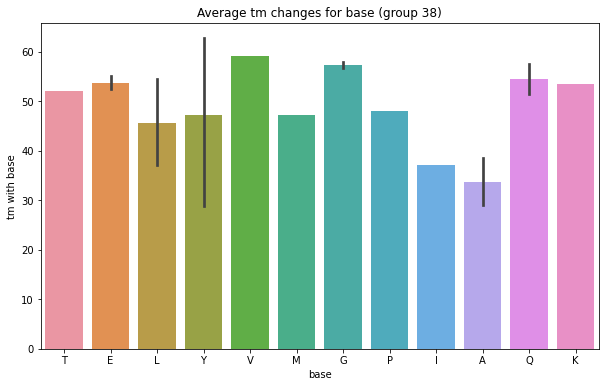

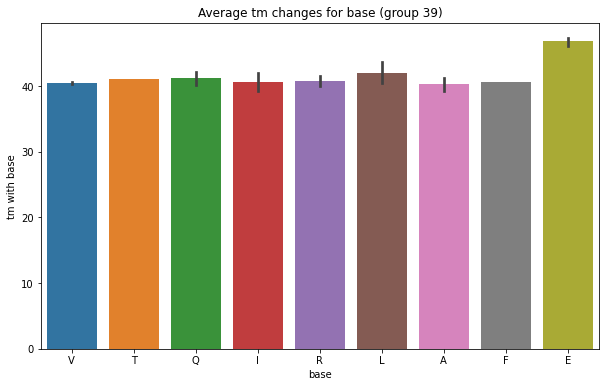

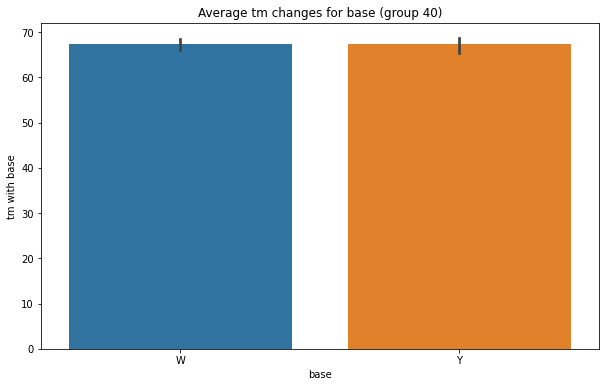

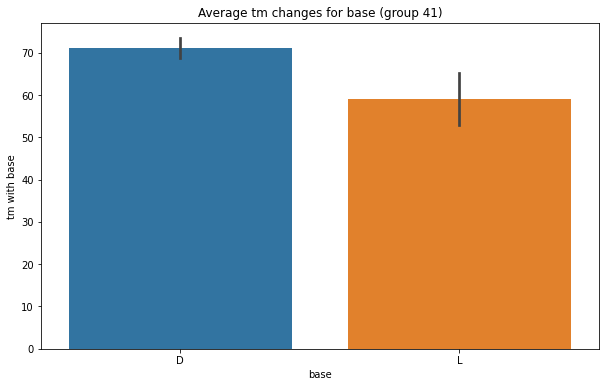

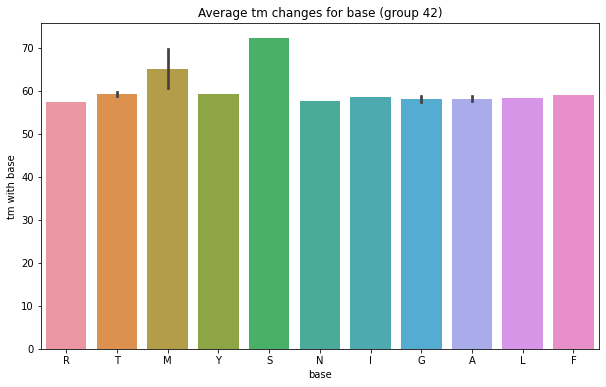

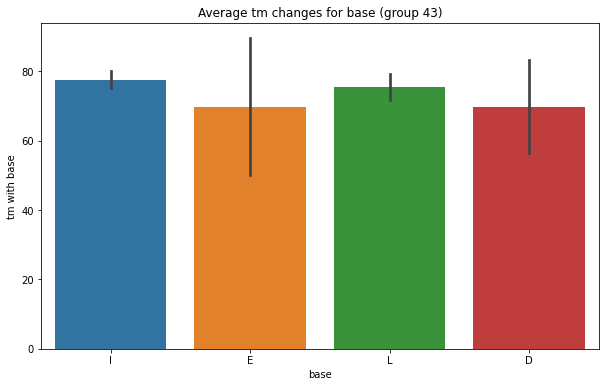

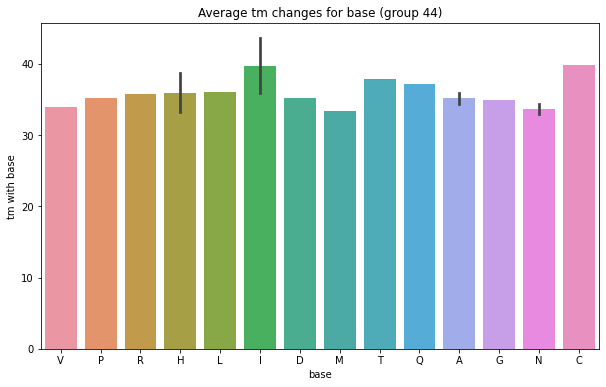

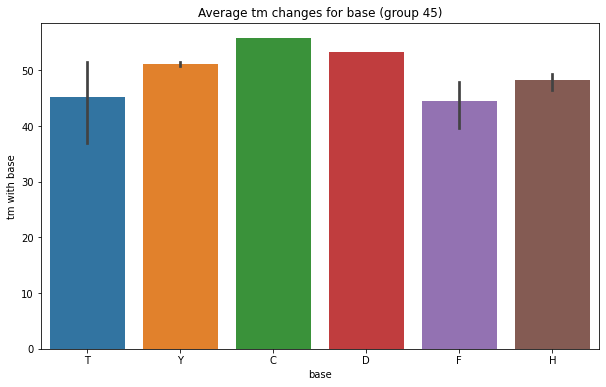

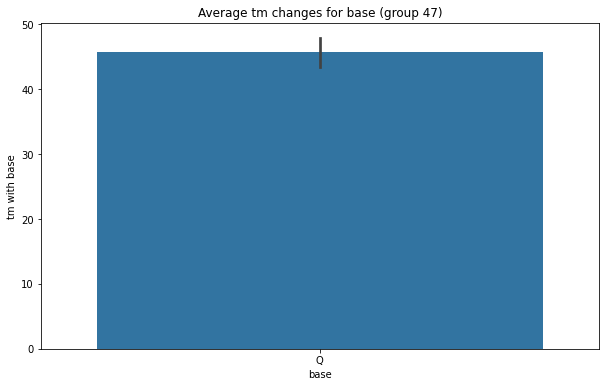

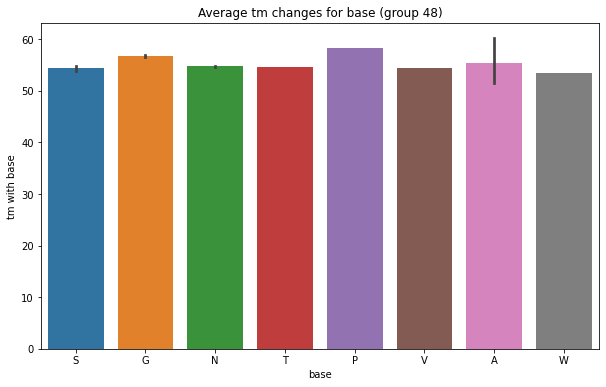

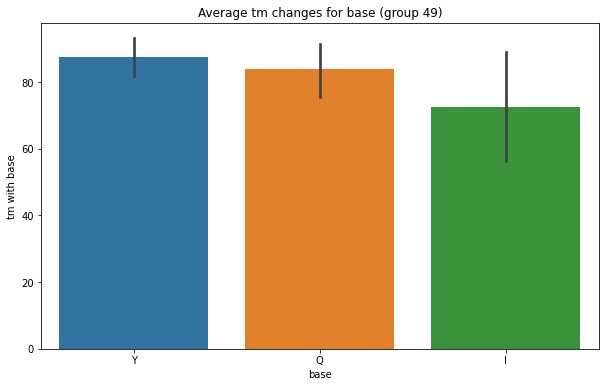

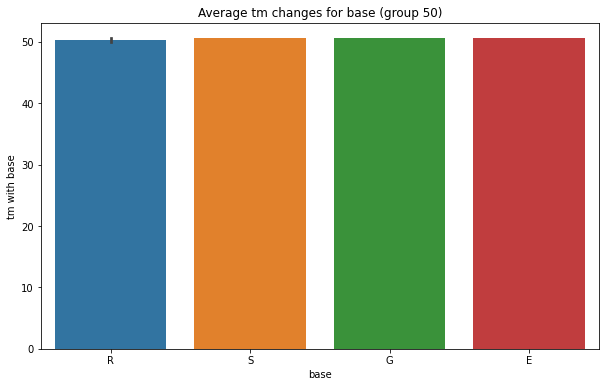

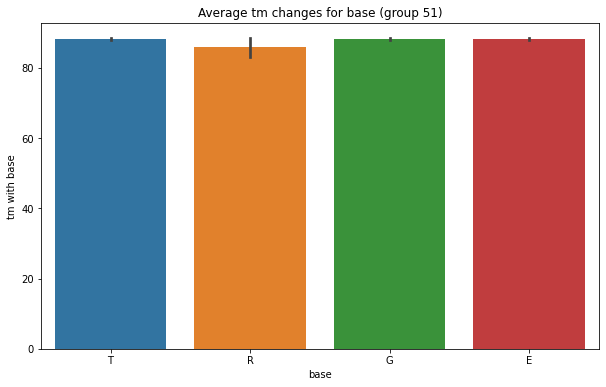

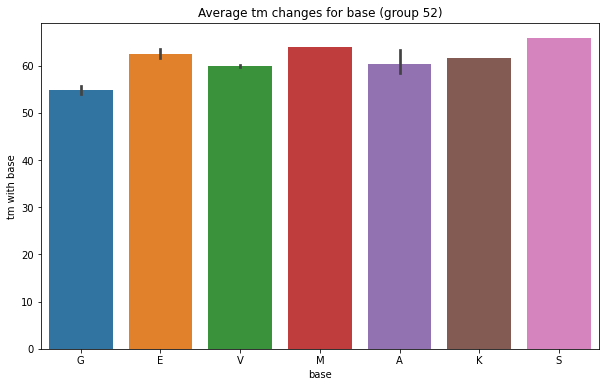

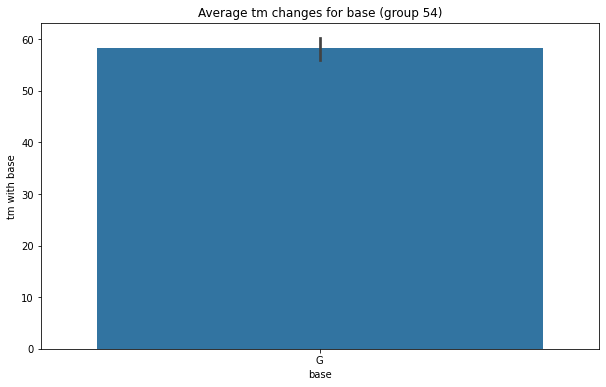

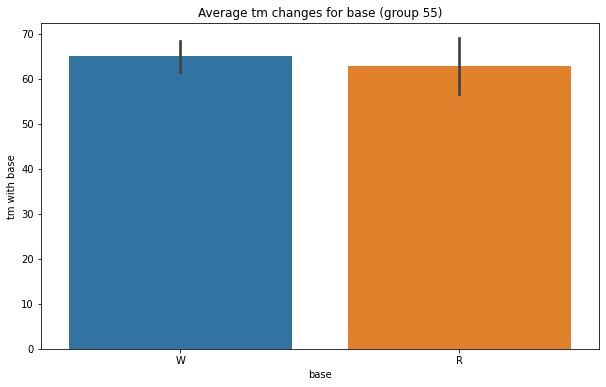

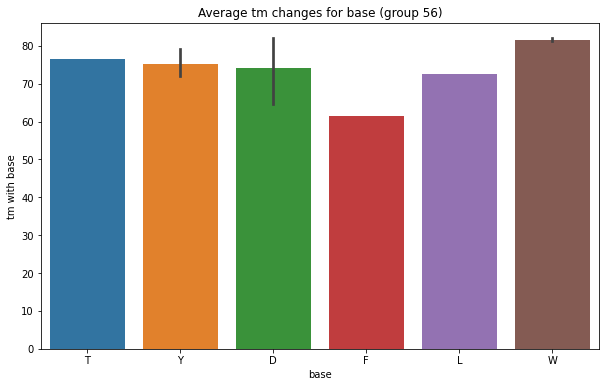

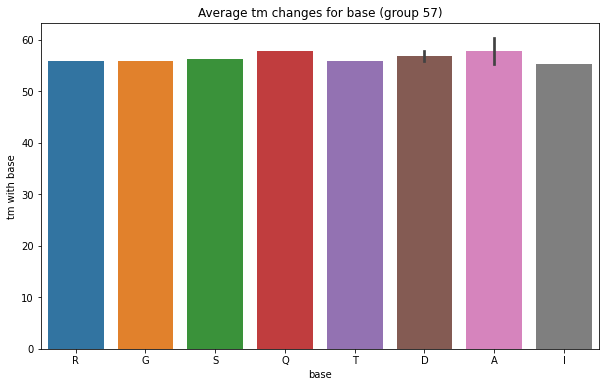

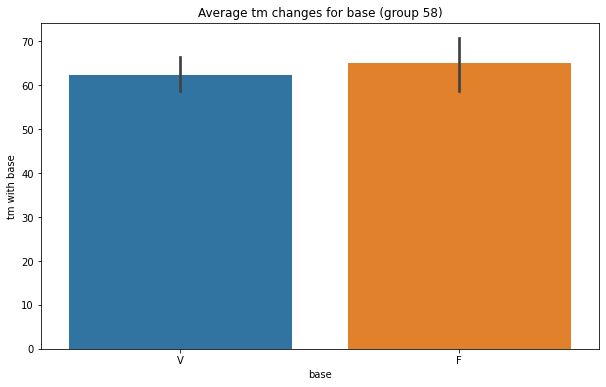

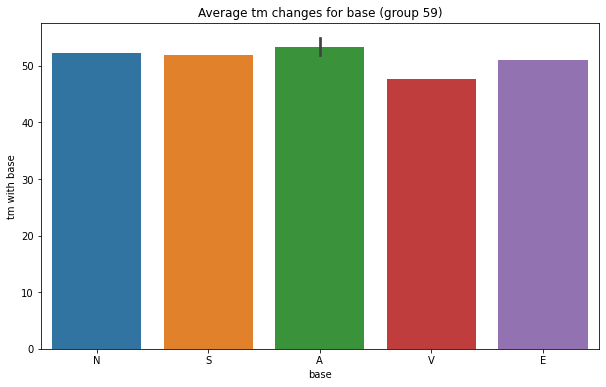

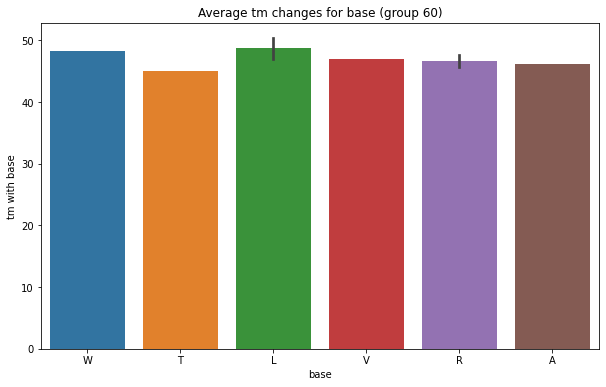

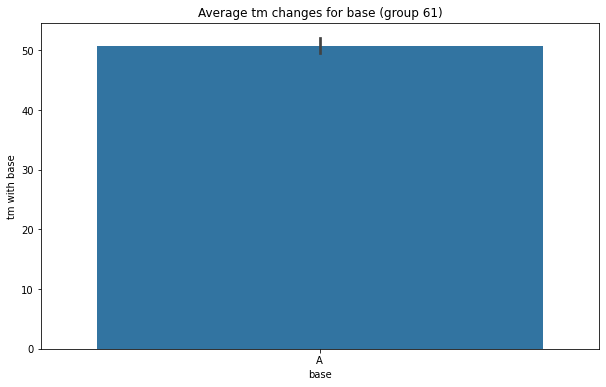

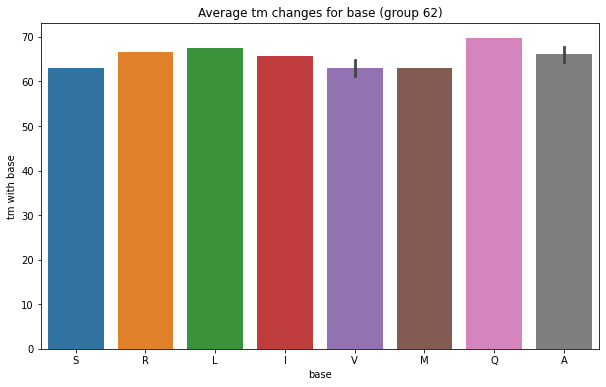

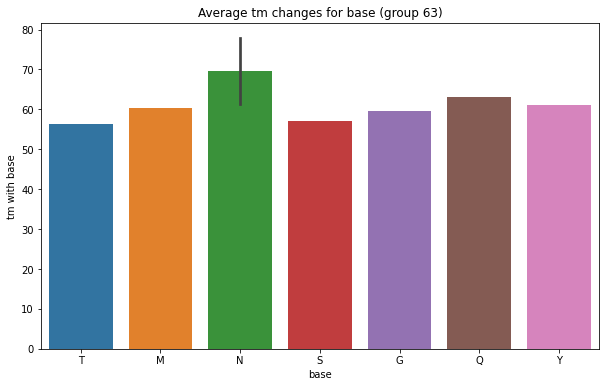

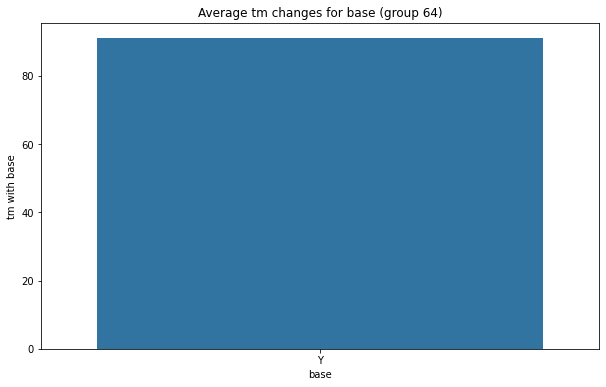

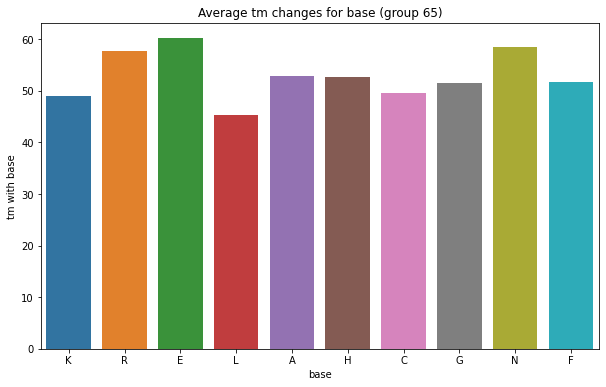

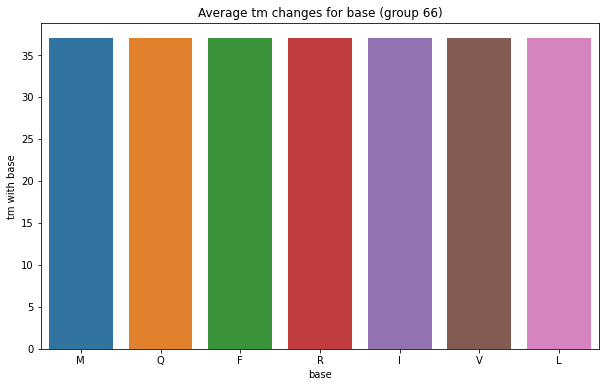

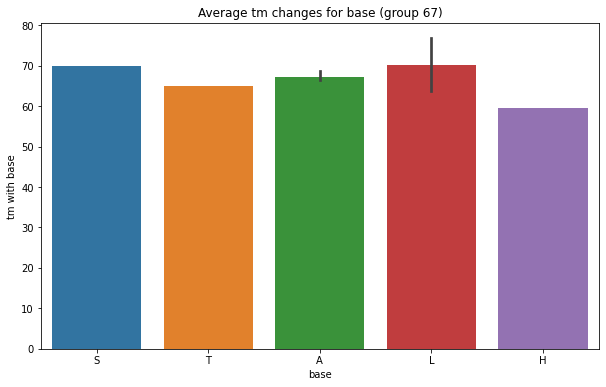

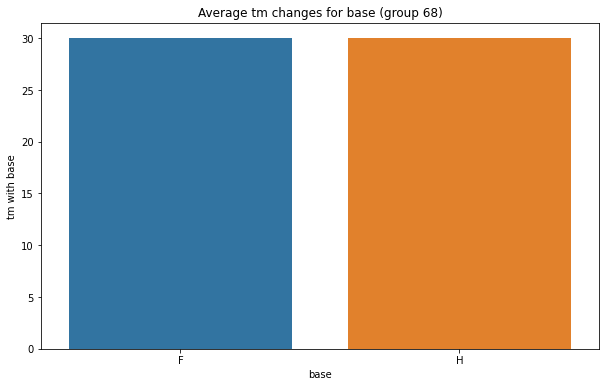

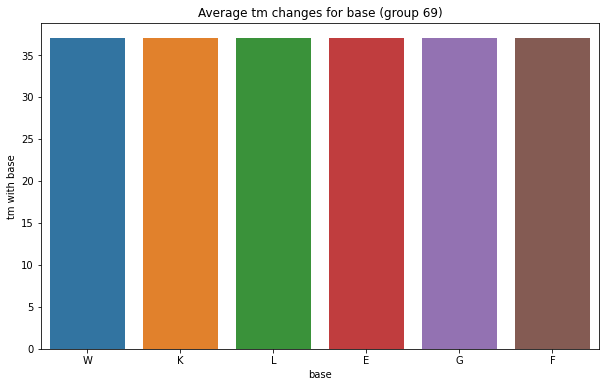

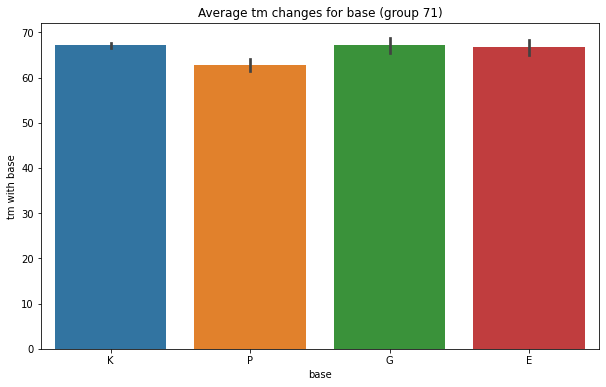

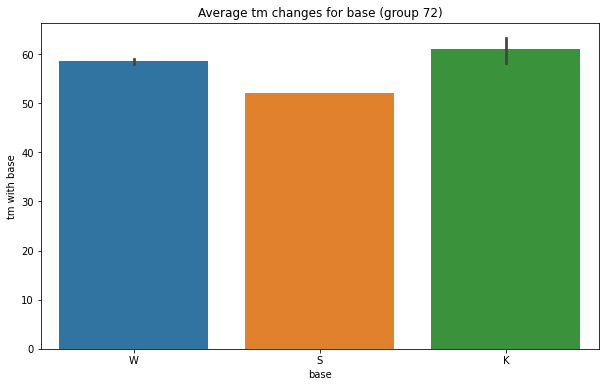

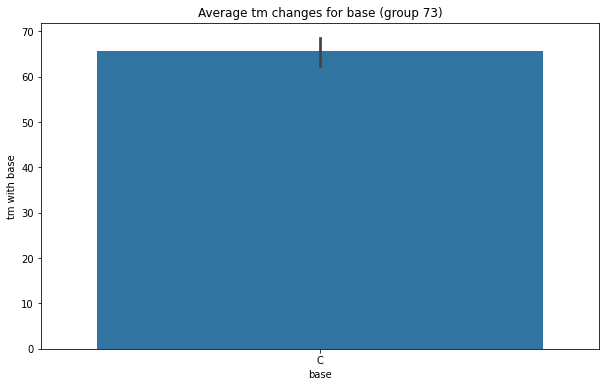

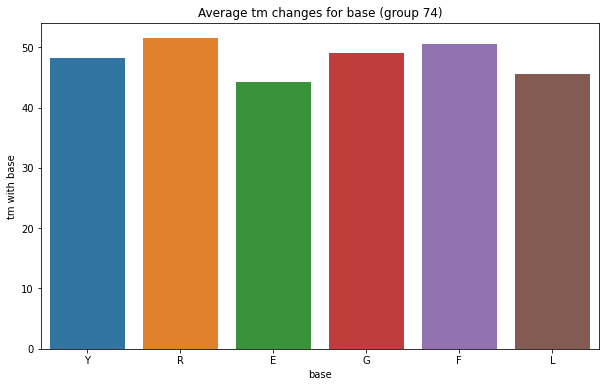

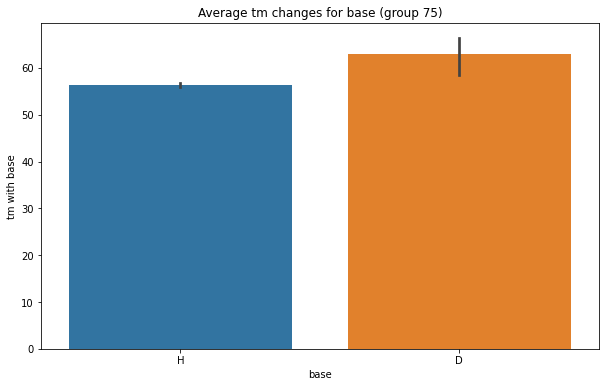

In [78]:
for group in pH_groups:
    # Set the width and height of the figure
    plt.figure(figsize=(10,6))

    # Add title
    plt.title(f"Average tm changes for base (group {group})")

    # Bar chart showing average arrival delay for Spirit Airlines flights by month
    sns.barplot(x=pH_df.loc[pH_df.group == group].base, y=pH_df.loc[pH_df.group == group]['tm'])

    # Add label for vertical axis
    plt.ylabel("tm with base")

Text(0, 0.5, 'tm with x')

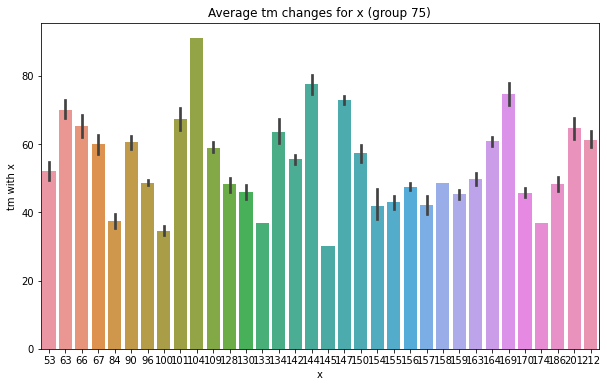

In [79]:
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title(f"Average tm changes for x (group {group})")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=pH_df.loc[pH_df.x <= 221].x, y=pH_df.loc[pH_df.x <= 221]['tm'])

# Add label for vertical axis
plt.ylabel("tm with x")

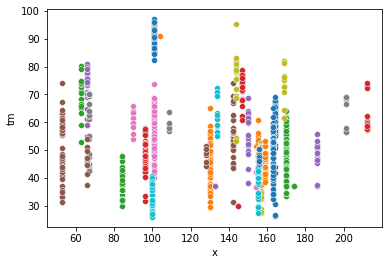

In [80]:
for group in pH_groups:
    sns.scatterplot(x=pH_df.loc[(pH_df.group == group) & (pH_df.x <= 220)]['x'], y=pH_df.loc[(pH_df.group == group) & (pH_df.x <= 220)]['tm'])

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


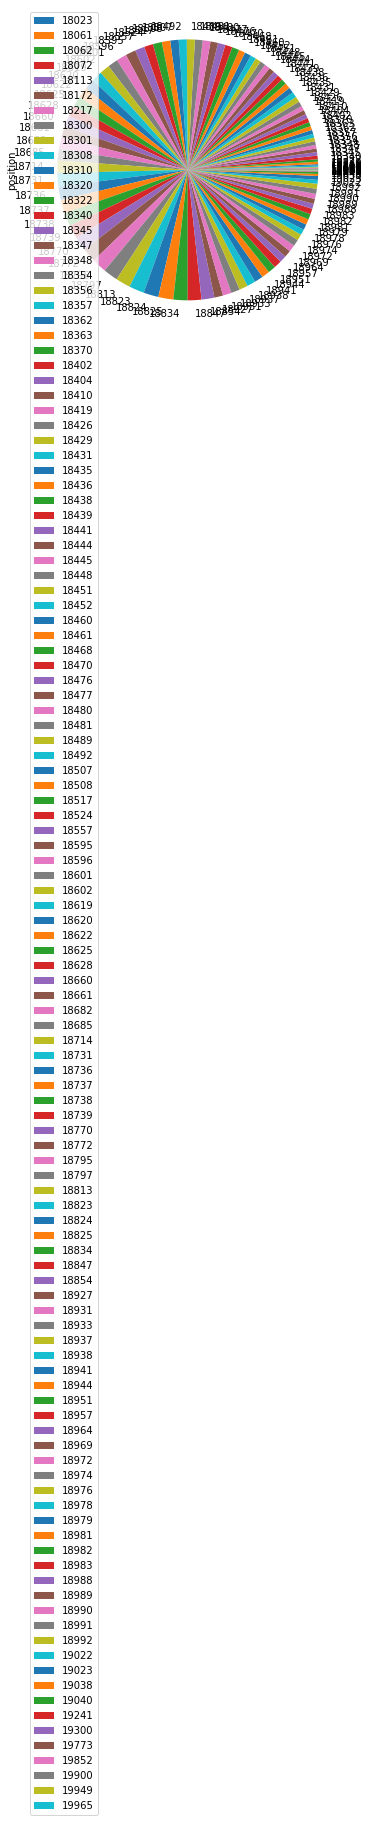

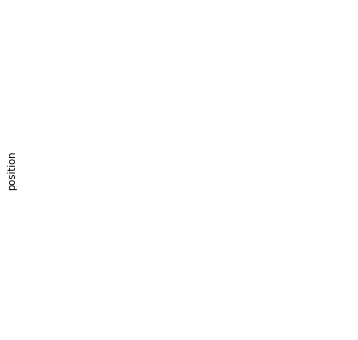

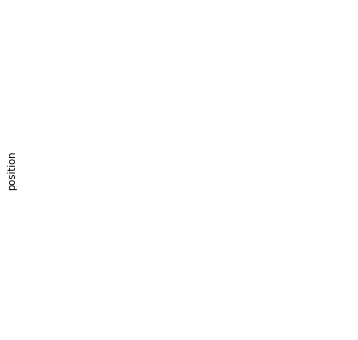

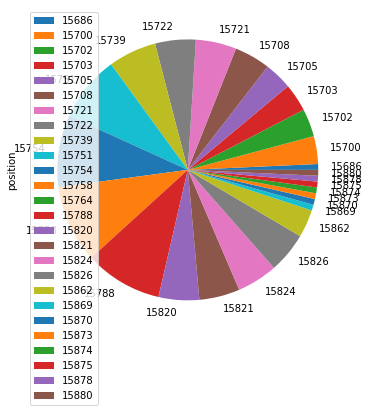

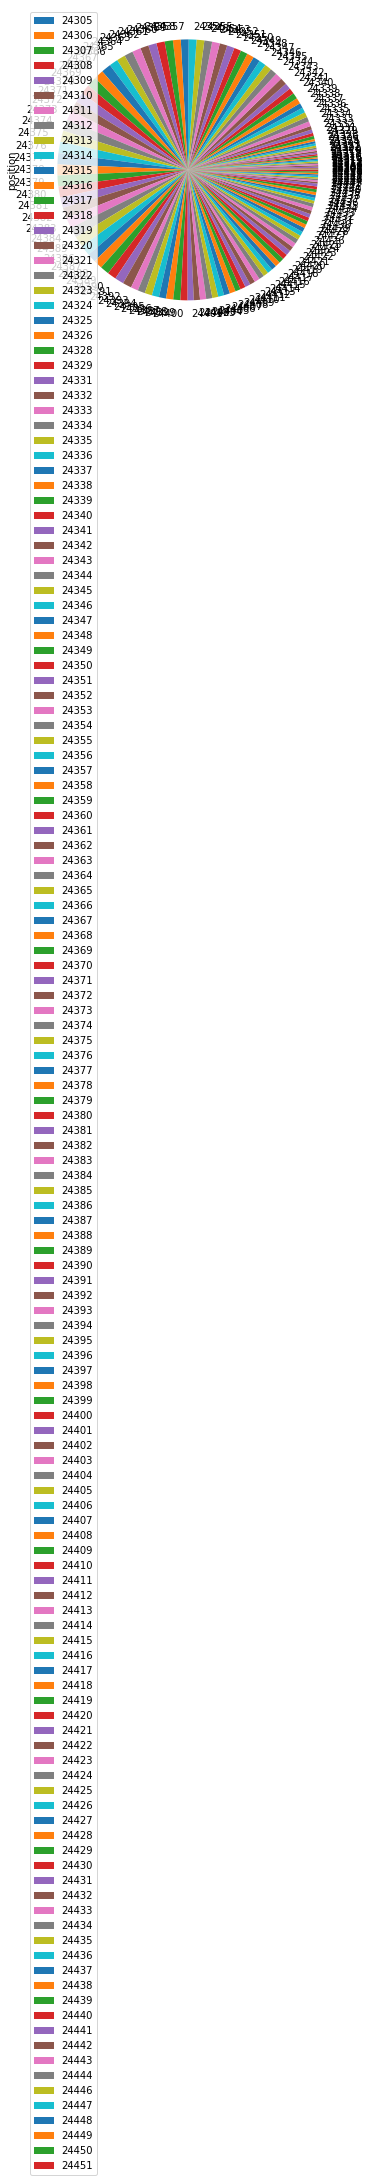

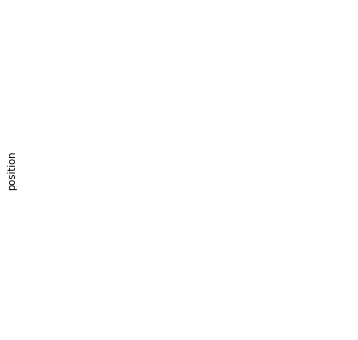

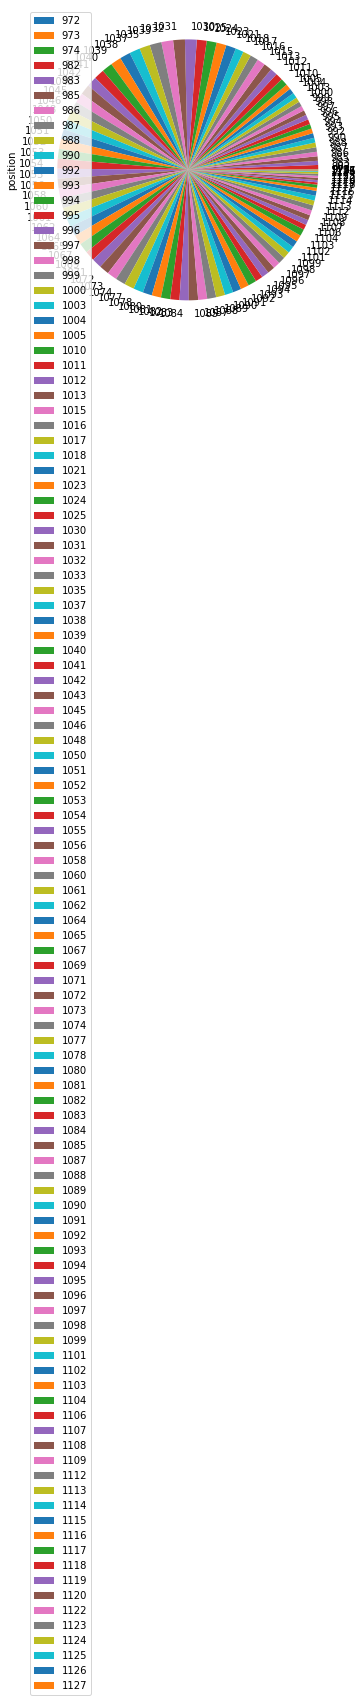

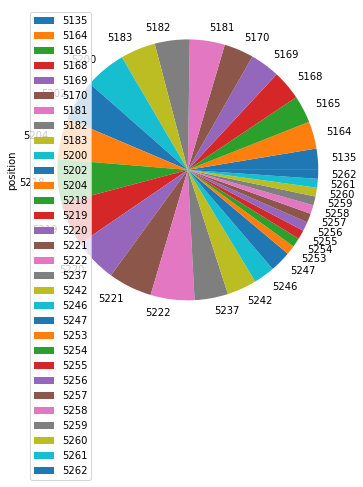

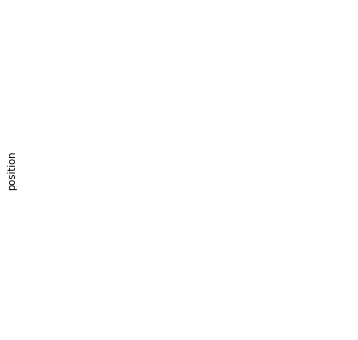

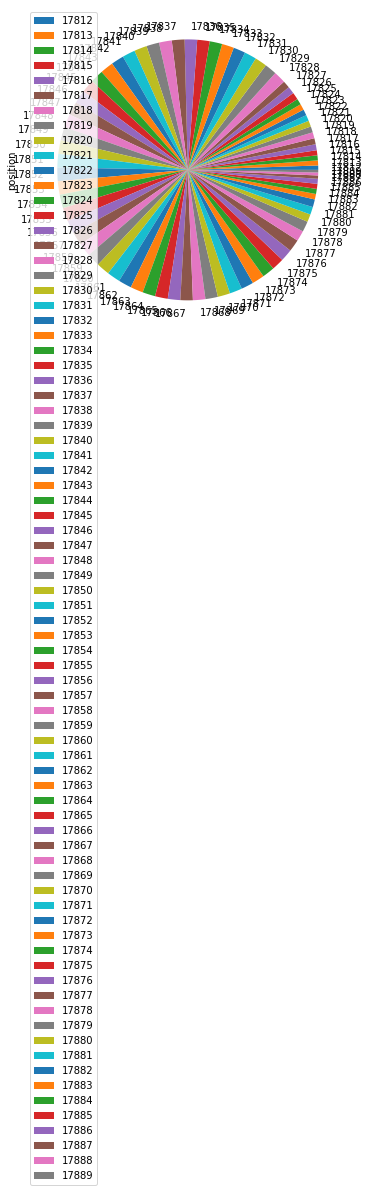

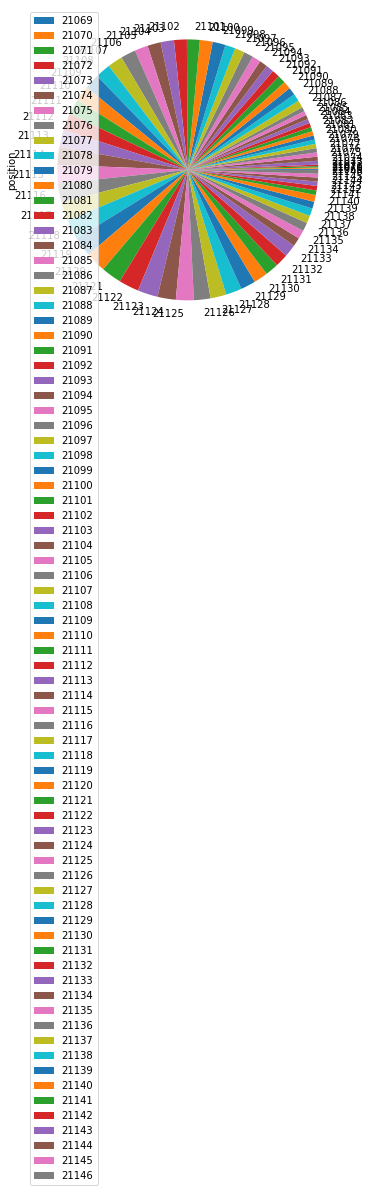

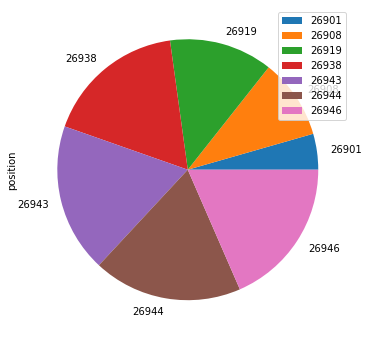

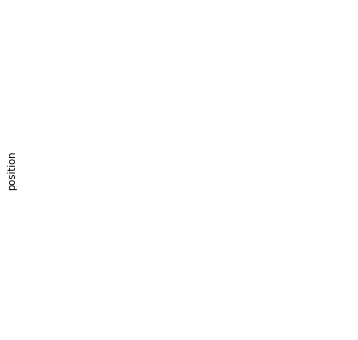

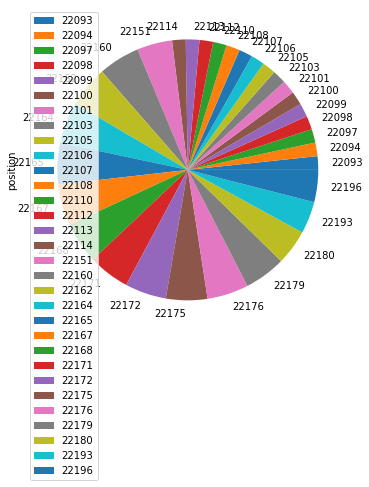

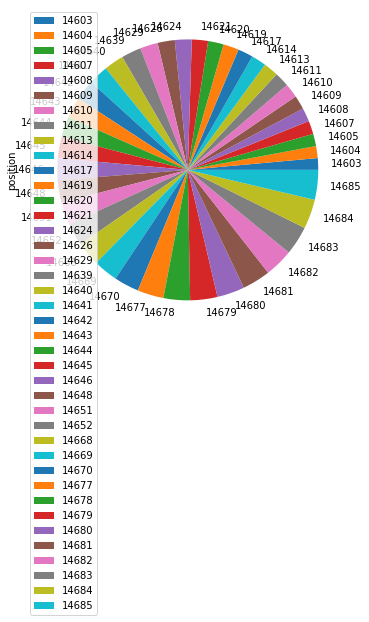

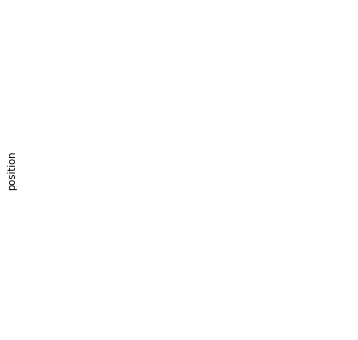

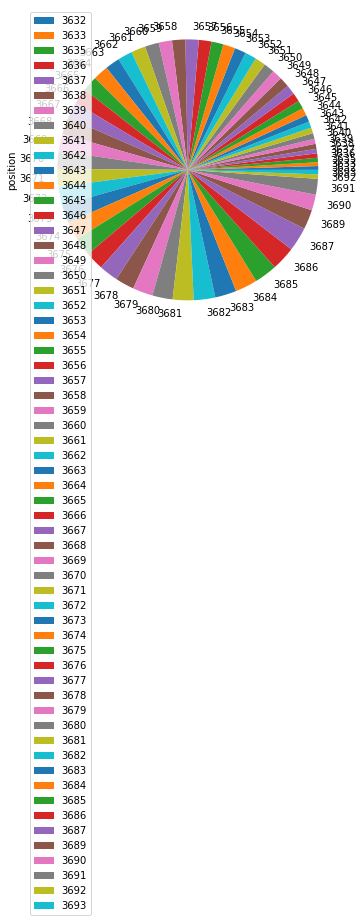

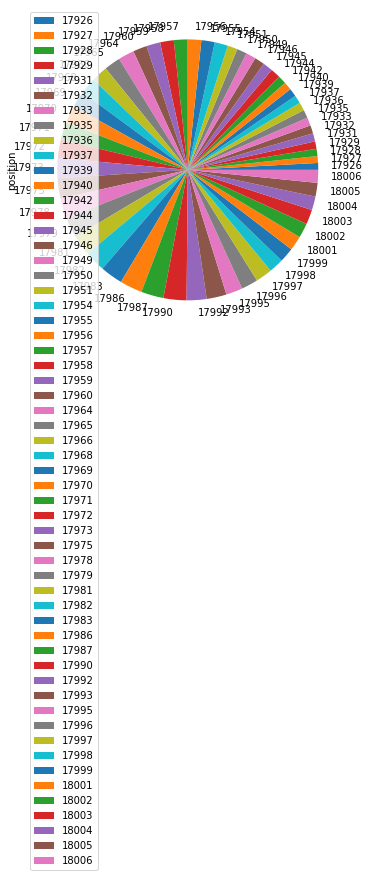

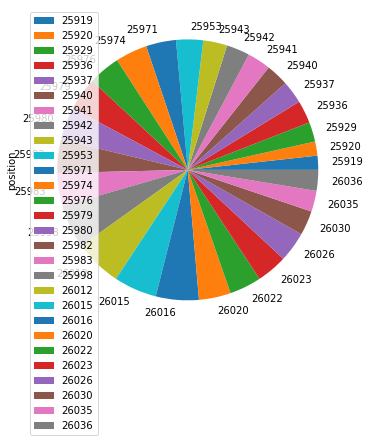

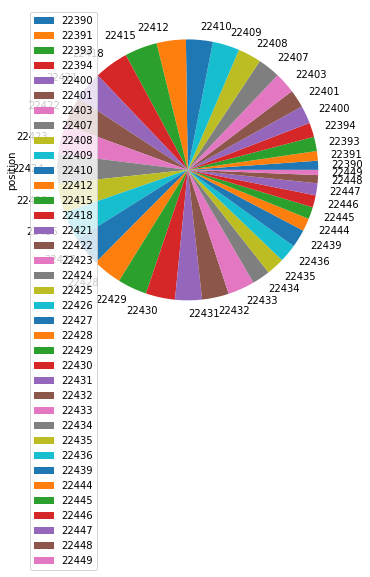

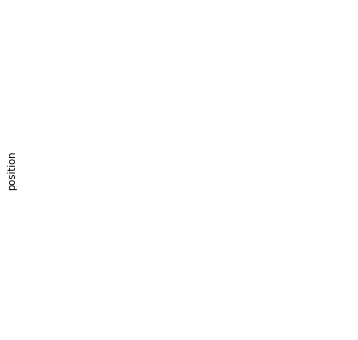

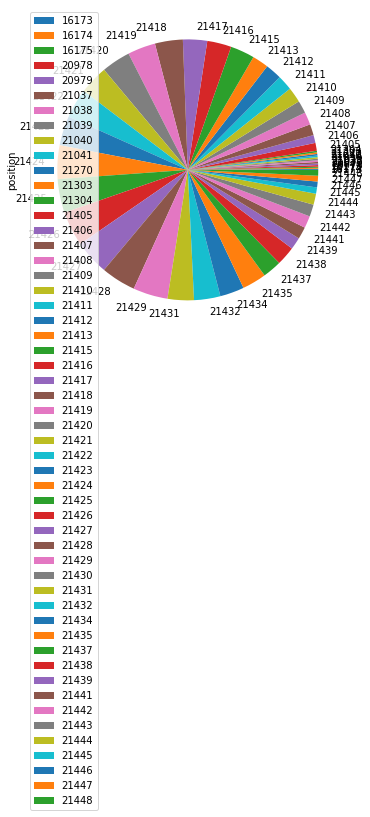

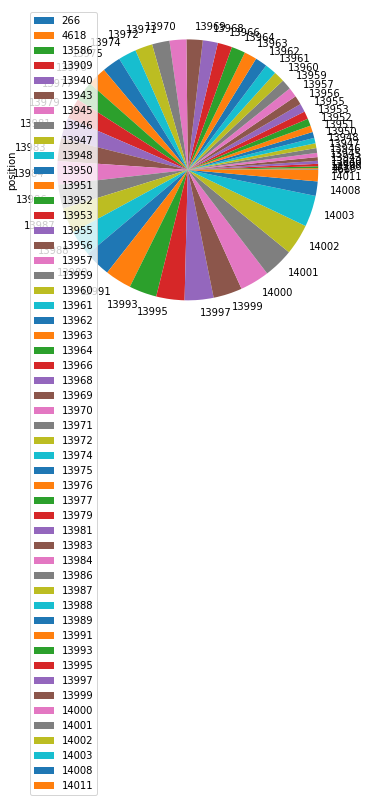

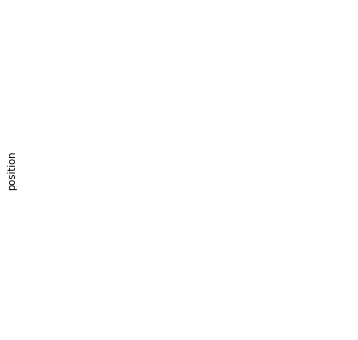

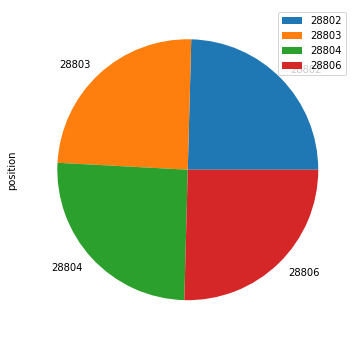

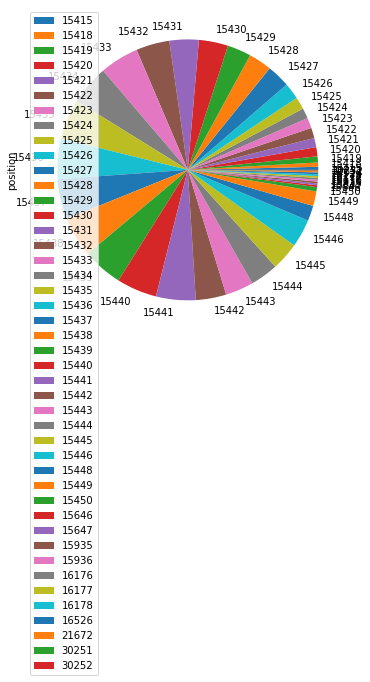

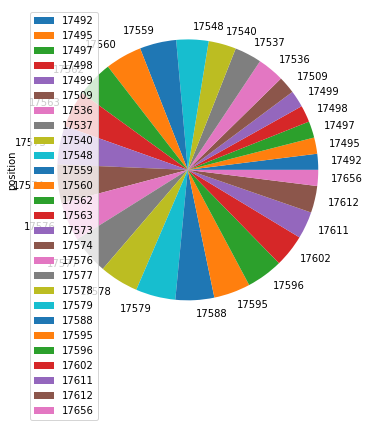

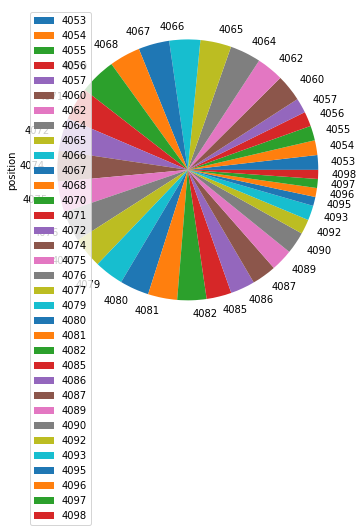

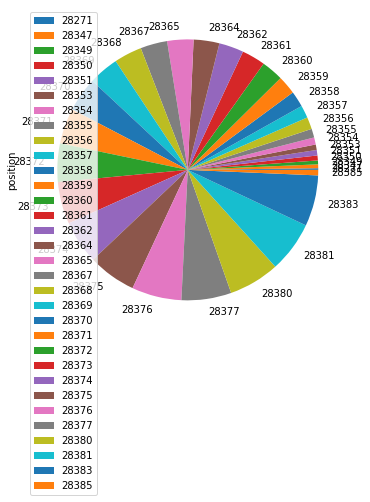

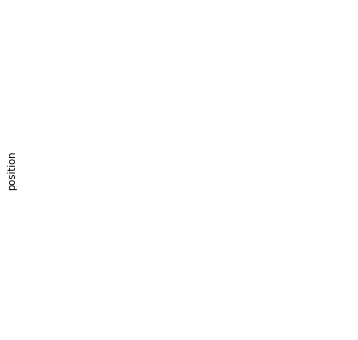

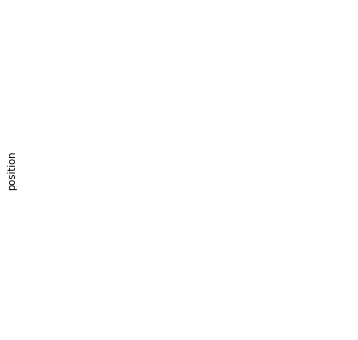

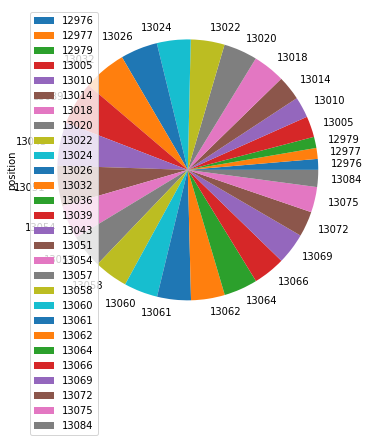

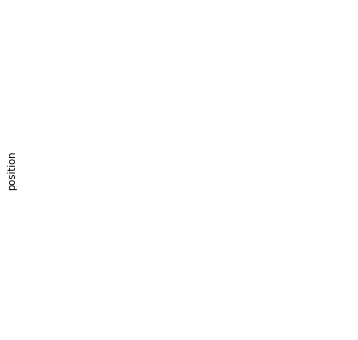

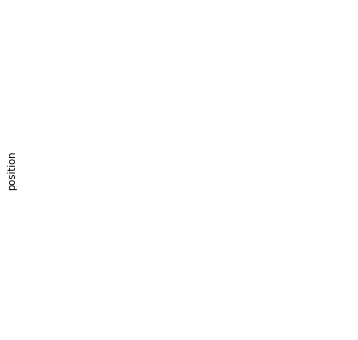

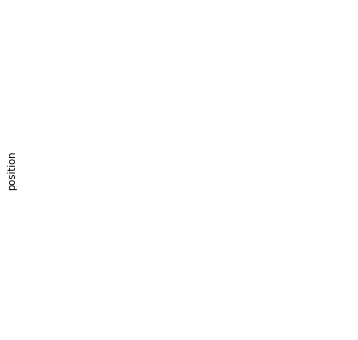

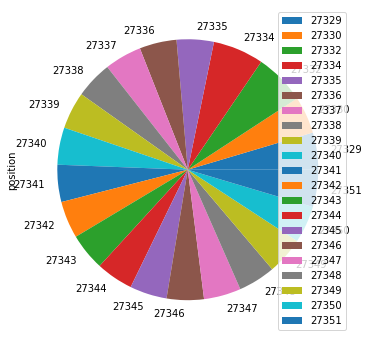

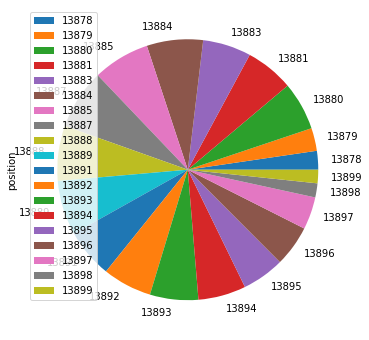

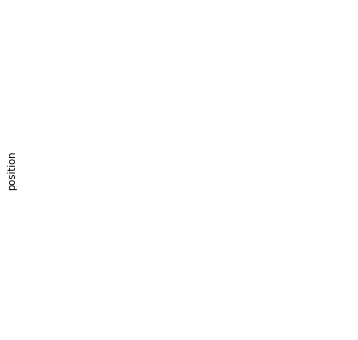

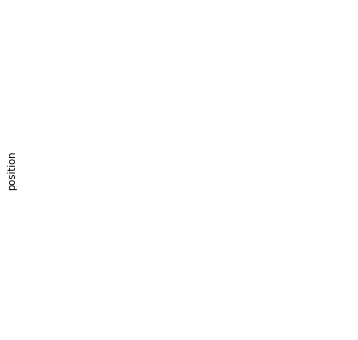

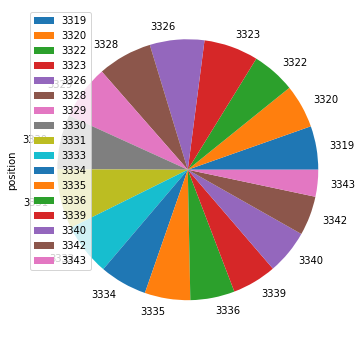

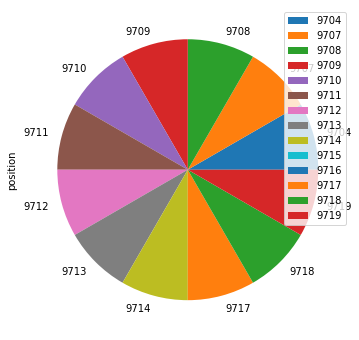

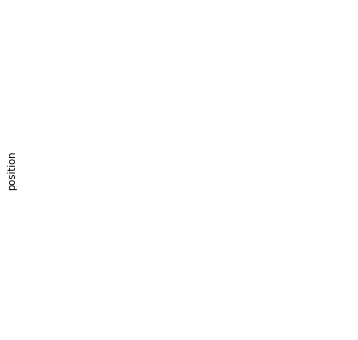

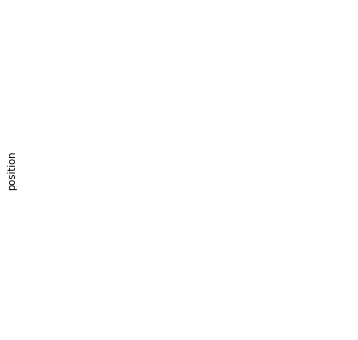

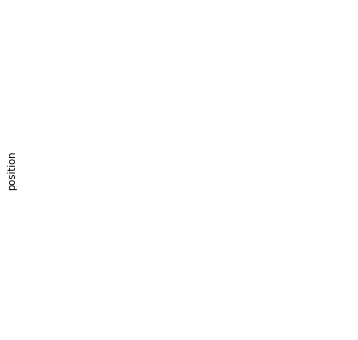

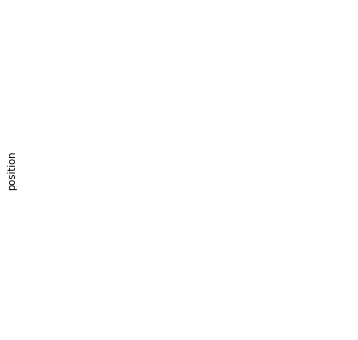

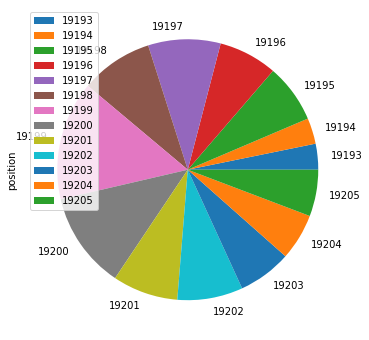

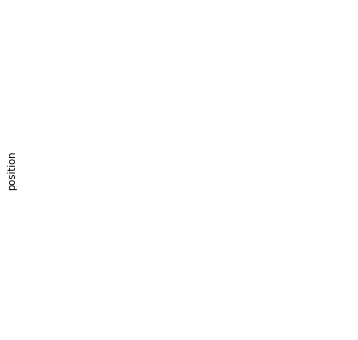

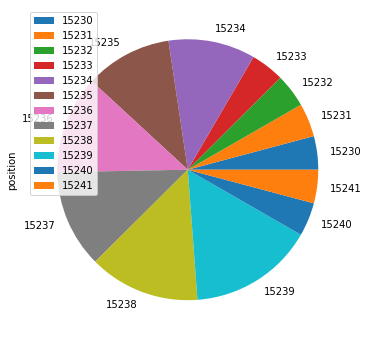

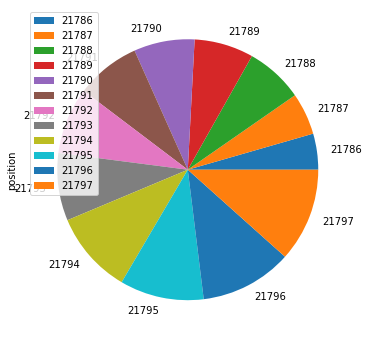

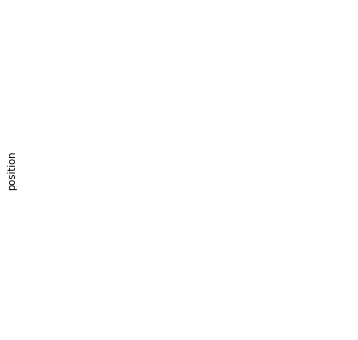

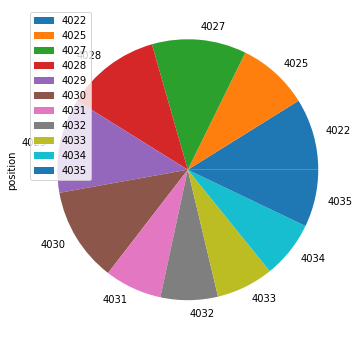

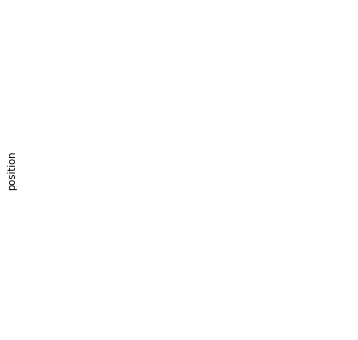

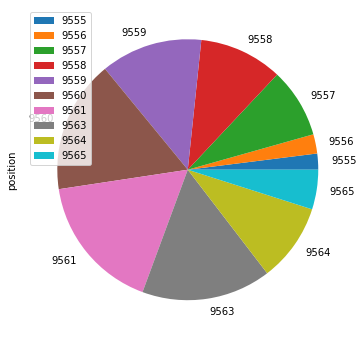

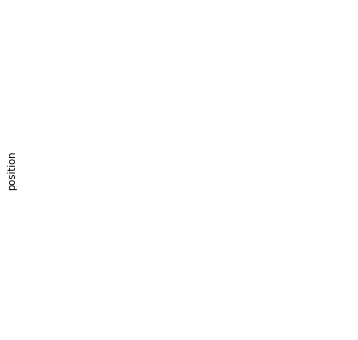

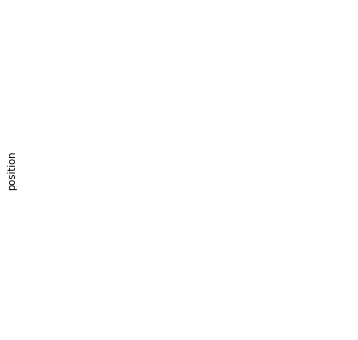

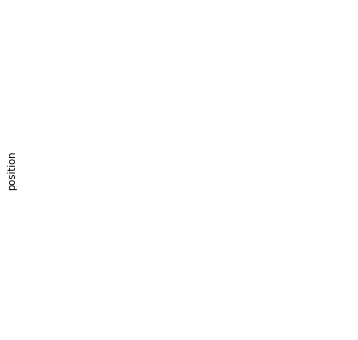

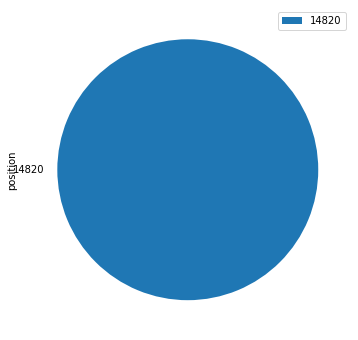

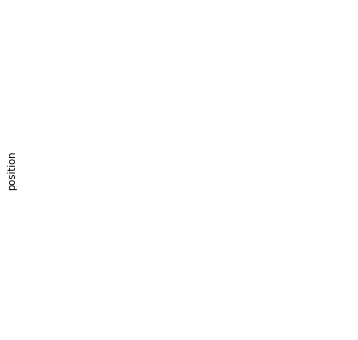

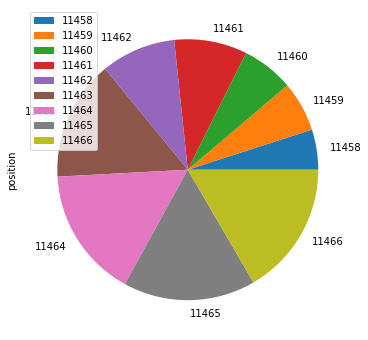

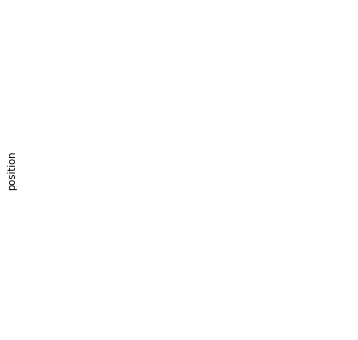

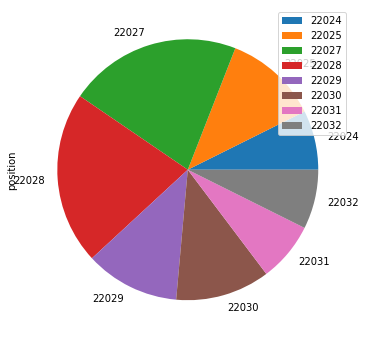

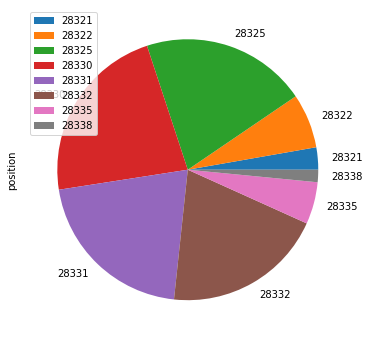

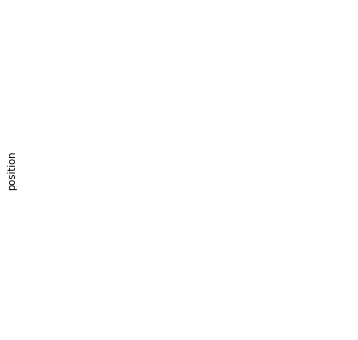

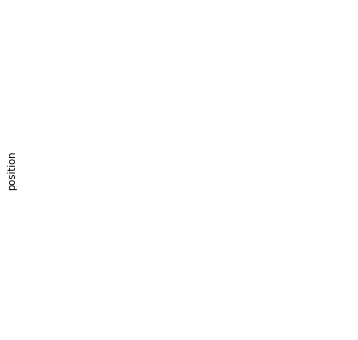

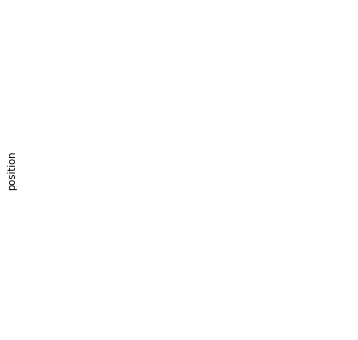

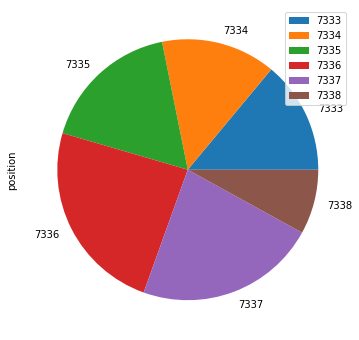

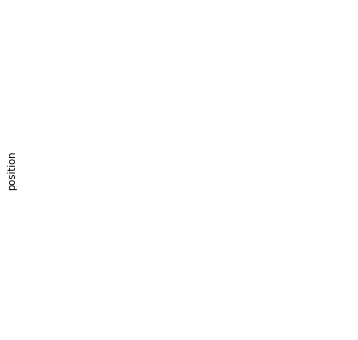

In [81]:
for group in pH_groups:
#     tmp_df = pd.DataFrame(experiment_df.loc[(experiment_df.group == group) & (experiment_df.x <= 220)], index=experiment_df.loc[(experiment_df.group == group) & (experiment_df.x <= 220)]['position'])
    pH_df.loc[(pH_df.group == group) & (pH_df.x <= 220)].plot.pie(y='position', figsize=(6, 6))

In [17]:
import string
AcidNums = dict(zip(string.ascii_uppercase, range(1, len(string.ascii_uppercase) + 1)))
AcidNums['None'] = 0

mutations_dtm = {
    'mutation_0': [],
    'position_0': [],
    'mutation_1': [],
    'position_1': [],
    'mut_00': [],
    'mut_01': [],
    'mut_10': [],
    'mut_11': [],
    'pH': [],
    'dtm': []
}
groups = experiment_df.group.unique()
for _ in groups:
    group = experiment_df.loc[experiment_df.group == _]
    for i, row_i in group.iterrows():
        for j, row_j in group.iterrows():
            if i == j:
                continue
            row = {
                'mutation_0': 'None->None',
                'position_0': 0,
                'mutation_1': 'None->None',
                'position_1': 0,
                'mut_00': 0,
                'mut_01': 0,
                'mut_10': 0,
                'mut_11': 0,
                'pH': -1,
                'dtm': 0
            }
            try:
                if row_i.protein_sequence == row_j.protein_sequence:
                    pass
                elif row_i.position == row_j.position:
                    row['mutation_0'] = f'{row_i.mutation}->{row_j.mutation}'
                    row['position_0'] = int(row_i.position)
                else:
                    row['mutation_0'] = f'{row_i.mutation}->{row_j.wildtype[int(row_i.position)-1]}'
                    row['position_0'] = int(row_i.position)
                    row['mutation_1'] = f'{row_i.wildtype[int(row_j.position)-1]}->{row_j.mutation}'
                    row['position_1'] = int(row_j.position)
                row['pH'] = row_j.pH
                row['dtm'] = row_j.tm - row_i.tm
                
                row['mut_00'], row['mut_01'] = AcidNums[row['mutation_0'].split('->')[0]], AcidNums[row['mutation_0'].split('->')[-1]]
                row['mut_10'], row['mut_11'] = AcidNums[row['mutation_1'].split('->')[0]], AcidNums[row['mutation_1'].split('->')[-1]]
                
                if row['position_0'] != 0 or row['position_1'] != 0:
                    for key in row:
                        mutations_dtm[key].append(row[key])
            except Exception as e:
                pass
mutations_dtm_df = pd.DataFrame(mutations_dtm)
mutations_dtm_df.head()

mutation_0  position_0  mutation_1  position_1  mut_00  mut_01  mut_10  \
0       A->C           3  None->None           0       1       3       0   
1       A->C           3  None->None           0       1       3       0   
2       A->C           3  None->None           0       1       3       0   
3       A->C           3  None->None           0       1       3       0   
4       A->D           3  None->None           0       1       4       0   

   mut_11   pH   dtm  
0       0  2.0   3.8  
1       0  6.5  26.9  
2       0  6.5  26.6  
3       0  4.2  15.2  
4       0  4.2  15.2

In [18]:
mutations_dtm_df.to_csv('experiment_mutations_dtm.csv')

In [19]:
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt      
import seaborn as sn

from sklearn.neighbors       import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.datasets        import make_moons
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold

def norm(X):
    """ Нормализация данных в единичный куб [0...1]^n в пространстве признаков"""
    return (X - X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))   

def plot_data(X, Y, lim=(0.,1.), clf = None, num = 100, prob = True, title=""):                
    """
    Рисуем 2D график примереров вместе с разделяющей линией модели clf (если есть)
    """
    plt.figure (figsize=(4, 4), facecolor ='w')                                 
    
    if clf is not None:   
        x1 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
        x2 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
        x1, x2 =  np.meshgrid(x1, x2)            
        inp = np.c_[x1.ravel(), x2.ravel()]
        if prob:
            prob = clf.predict_proba(inp)[:,1].reshape(x1.shape)
            plt.imshow(prob, extent=[lim[0], lim[1], lim[0], lim[1]],  origin='lower', cmap='bwr', alpha=0.3)
            
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contour(x1, x2, label, cmap='gray')                
        else:        
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contourf(x1, x2, label, alpha=0.3, cmap='bwr')                
    
    plt.scatter(X[:,0], X[:,1], c=Y,  s=5, cmap='bwr')        
    plt.xlim(0, 1)
    plt.ylim(0, 1);
    plt.title(title)
    plt.show()  

def shuffle_data(X,Y):
    """ Перемешиваем данные """
    idx = np.random.permutation(len(Y)) 
    return X[idx], Y[idx] 

def eval_model(clf, X,Y, count=1, cv=5, info=""):
    """ 
    Оцениваем модель по кроссвалидации (t×q-fold cross-validation) с q=cv-фолдами, 
    повторяя эксперимент t=count раз, перемешивая перед эксперииментом данные.
    """
    count = max(1, count)
    cv    = max(2, cv)
    
    tm1 = time.process_time() 
    acc_val, acc_trn, rec_val, rec_trn = np.array([]), np.array([]), np.array([]), np.array([])
    for _ in range(count):
        X, Y = shuffle_data(X,Y)
        
        res = cross_validate(clf, X, Y, cv=cv, return_train_score=True, scoring=['accuracy', 'recall'])            
        
        acc_val = np.concatenate([acc_val, res['test_accuracy']])
        acc_trn = np.concatenate([acc_trn, res['train_accuracy']])    
        rec_val = np.concatenate([rec_val, res['test_recall']])
        rec_trn = np.concatenate([rec_trn, res['train_recall']])
    
    tm2 = time.process_time() 
    
    print(f"({count}×{cv})  val: acc={acc_val.mean():.3f} recall={rec_val.mean():.3f}  acc(trn-val)={acc_trn.mean()-acc_val.mean():.3f};   trn: acc={acc_trn.mean():.3f}  recall={rec_trn.mean():.3f};  {(tm2-tm1)/(cv*count):.2f}s   {info}")    

In [20]:
# from sklearn.datasets import load_iris
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import LeaveOneOut,cross_val_score

# mutations_dtm_df = mutations_dtm_df.dropna()
# X_cols = ['mut_00', 'mut_01', 'position_0', 'mut_10', 'mut_11', 'position_1', 'pH']
# X = mutations_dtm_df[X_cols]
# Y = mutations_dtm_df.dtm

# X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
# from sklearn.tree import DecisionTreeClassifier

# class CFG:
#     count            = 10      # train iterations  
#     cv               = 5       # kfold splits     
#     min_samples_leaf = 20       # Def:1
#     min_samples_split= 2       # Def:2
#     max_depth        = None    # Def:None

# clf = DecisionTreeClassifier(max_depth=CFG.max_depth, min_samples_split=CFG.min_samples_split, min_samples_leaf=CFG.min_samples_leaf)
# eval_model(clf, X_trn, Y_trn, count=CFG.count, cv=CFG.cv, info=f"leaf:{CFG.min_samples_leaf}, split:{CFG.min_samples_split}, depth:{CFG.max_depth}")  # count × cv fold


In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

mutations_dtm_df = mutations_dtm_df.dropna()
X_cols = ['mut_00', 'mut_01', 'position_0', 'mut_10', 'mut_11', 'position_1', 'pH']
X = mutations_dtm_df[X_cols]
X = X.dropna()
Y = mutations_dtm_df.dtm

X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_trn, Y_trn)

In [23]:
from sklearn.metrics import accuracy_score
Y_val = reg.predict(X_tst)
mean_squared_error(Y_tst, Y_val)
# accuracy_score(Y_tst, Y_val)

160.8637743162799

In [24]:
from sklearn.linear_model import Ridge
import numpy as np
clf = Ridge(alpha=1.0)
clf.fit(X_trn, Y_trn)

Y_val = clf.predict(X_tst)
mean_squared_error(Y_tst, Y_val)

160.86377406939278

In [25]:
from sklearn import linear_model
clf.fit(X_trn, Y_trn)

Y_val = clf.predict(X_tst)
mean_squared_error(Y_tst, Y_val)

160.86377406939278

In [26]:
# from sklearn.datasets import load_iris
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import LeaveOneOut,cross_val_score

# mutations_dtm_df = mutations_dtm_df.dropna()
# X_cols = ['mut_00', 'mut_01', 'position_0', 'mut_10', 'mut_11', 'position_1', 'pH']
# X = mutations_dtm_df[X_cols]
# X = X.dropna()
# Y = mutations_dtm_df.dtm

# # cols_with_missing = [col for col in X.columns
# #                      if X[col].isnull().any()]
# # print(cols_with_missing)

# loo=LeaveOneOut()
# tree=RandomForestClassifier(n_estimators=10,max_depth=5,n_jobs=-1)
# score=cross_val_score(tree,X,Y,cv=5)
# print("Cross Validation Scores are {}".format(score))
# print("Average Cross Validation score :{}".format(score.mean()))